# A Cognitive Model or Harmonic Types (Simplified Amortization)

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Thesis/probabilistic_harmony_model

Mounted at /content/drive
/content/drive/MyDrive/Thesis/probabilistic_harmony_model


In [2]:
!pip install pyro-api==0.1.2
!pip install pyro-ppl==1.8.4
!pip install pitchtypes==0.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 kB 6.7 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

from pyro.distributions import *
#from collections import Counter
import pyro.infer
import pyro.optim
import pyro.util
pyro.enable_validation(True)

import matplotlib.pyplot as plt
import tqdm

import numpy as np
import pandas as pd
import scipy.stats as stats

import os.path as path
from datetime import datetime
import json

import utils

import gc

In [4]:
gpu = torch.cuda.is_available()

gpu_n = 0

torch.set_default_dtype(torch.float64)

#torch.autograd.set_detect_anomaly(True)

device = torch.device(f'cuda:{gpu_n}' if gpu else 'cpu')
print(device)

cpu


In [5]:
def save_rng_state(name):
    fn = name + '-' + datetime.today().isoformat() + '.state'
    state = pyro.util.get_rng_state()
    with open('rng-' + fn, 'w') as f:
        print(state, file=f)
    torch.save(state['torch'], 'torch-' + fn)

In [6]:
# set random seeds
pyro.set_rng_seed(0)
#torch.set_deterministic(True)
#torch.set_num_threads(1)
#torch.set_num_interop_threads(1)

# fix the range of pitches we consider
fifth_range = 2*7                  # 2 diatonics
npcs = 2*fifth_range+1             # around C: Cbb to C## on LoF
utils.set_fifth_range(fifth_range) # used to make helper functions work correctly

# **1. Amortization**



## Step 1: Model

**Notations:**
- $h$: probablity distribution of chords (harmony)
- $\Phi$: chord profile for all chord types, where each $\phi_i$ conntains weights for each chord
- $npcs$: range of line of fifths, which is the number of pitches we consider
- $n_{harmonies}$: number of different chord types
- $n_{chords}$: length of dataset (how many chords we observe in the dataset)

**Generating Process:**

For all $i$:

- $\phi_i \sim Dirichlet(0.5, npcs)$
- $h \sim Dirichlet(0.5, n_{harmonies})$

    For each chord j:
    - Choose chords: $c_i \sim Categorical(h)$
    - Choose pitches: $p_j \sim Multinomial(\phi_{cj}, N_j)$

where $p_j$ and $N_j$ are observed, other variables are unobserved.

In [7]:
def simplified_chord_model(npcs, nharmonies, data, subsamples=500, **kwargs):
    # parameters priors:
    # distribution of the harmonies
    p_harmony = pyro.sample('p_harmony', dist.Dirichlet(0.8 * torch.ones(nharmonies, device=device)))
    # distribution of notes in the harmonies (chord profiles)
    with pyro.plate('harmonies', nharmonies):
        chord_profiles = pyro.sample('chord_profiles', dist.Dirichlet(0.8 * torch.ones(npcs, device=device)))

    # Sampling the data:
    nchords = len(data['c'])
    subs = torch.arange(min(nchords, subsamples), device=device) if subsamples is not None else torch.arange(nchords, device=device)

    with pyro.plate('data', nchords, subsample=subs) as ind:
        # sample a chord type based on the harmony distribution (to be inferred)
        c = pyro.sample('c', dist.Categorical(p_harmony))

        # sampling pitches for the chord based on the selected chord type profile
        pitches = pyro.sample('pitches', dist.Multinomial(1, probs=chord_profiles[c], validate_args=False), obs=data['pitches'][ind])

    return {"p_harmony": p_harmony, "chord_profiles": chord_profiles, "c": c, "pitches": pitches}

## Step 2: Amortization Guide for Inference


In [8]:
# simpler
class AmortizationNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

In [9]:
# # with regulation
# class AmortizationNetwork(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super().__init__()
#         self.fc1 = nn.Linear(input_dim, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, output_dim)
#         self.dropout = nn.Dropout(p=0.5)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x.float()))
#         x = self.dropout(x)
#         x = torch.softmax(self.fc2(x), dim=-1)
#         return x

In [10]:
# # more complex
# class AmortizationNetwork(nn.Module):
#     def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
#         super().__init__()
#         self.fc1 = nn.Linear(input_dim, hidden_dim1)
#         self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
#         self.fc3 = nn.Linear(hidden_dim2, output_dim)
#         # self.dropout = nn.Dropout(p=0.5)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x.float()))
#         # x = self.dropout(x)
#         x = torch.softmax(self.fc3(x), dim=-1)
#         return x

In [11]:
def amortization_guide(npcs, nharmonies, data, subsamples=500, **kwargs):
    # for the distribution of the harmonies
    # initialize alpha parameters with more information, assuming some harmonies might be more probable
    alpha_h = pyro.param('alpha_h', (torch.ones(nharmonies, device=device) * 0.8), constraint=constraints.positive)

    pyro.sample('p_harmony', dist.Dirichlet(alpha_h))

    # for the chord profiles
    with pyro.plate('harmonies', nharmonies):
        alpha_phi = pyro.param('alpha_phi', (torch.ones([nharmonies, npcs], device=device) * 0.8), constraint=constraints.positive)
        pyro.sample('chord_profiles', dist.Dirichlet(alpha_phi))

    # for chord types
    net = AmortizationNetwork(input_dim=npcs, hidden_dim=128, output_dim=nharmonies)
    # net = AmortizationNetwork(input_dim=npcs, hidden_dim1=128, hidden_dim2=64, output_dim=nharmonies)
    net.to(device)
    pyro.module("net", net)

    nchords = len(data['c'])
    subs = torch.arange(min(nchords, subsamples), device=device) if subsamples is not None else torch.arange(nchords, device=device)

    with pyro.plate('data', nchords, subsample=subs) as ind:
        # Use NN to predict parameters for the chord types
        chord_features = data['pitches']
        chord_type_params = net(chord_features[ind])
        pyro.sample('c', dist.Categorical(probs=chord_type_params))

## Step 3: Data and Conditioning
**Data Format**


In [12]:
# def to_device_and_dtype(tensor, device):
#     return tensor.to(device).float()

In [13]:
def simplified_chord_tensor(notes):
    """Takes a list of fifths and returns a vector of counts for fifths."""
    chord = torch.zeros(npcs, device=device)
    #chord = torch.zeros(npcs).float()
    for fifth in notes:
        index = utils.fifth_to_index(fifth)
        chord[index] += 1
    return chord
    #return to_device_and_dtype(chord, device)

def simplified_annot_data_obs(chords):
    """Helper function to turn a list of chord dictionaries into a dictionary of observation vectors."""
    obs = {}
    obs["pitches"] = torch.cat([simplified_chord_tensor(c['notes']).reshape((1, -1)) for c in chords], dim=0)
    obs["c"] = torch.tensor([c['label'] for c in chords], device=device)
    obs["n"] = torch.tensor([len(c['notes']) - 1 for c in chords], device=device)
    return obs
    # obs["c"] = torch.tensor([c['label'] for c in chords]).long()
    # obs["n"] = torch.tensor([len(c['notes']) - 1 for c in chords]).long()
    # return {k: to_device_and_dtype(v, device) for k, v in obs.items()}

**Loading the Dataset**

The data is loaded from a TSV file that. The resulting dataframe is converted to the observation format that we pass to the model.

In [14]:
def load_dataset(filename):
    filename = path.join("data", filename)
    print("loading dataset...")
    df = utils.load_csv(filename)
    sizes = df.groupby(['chordid', 'label']).size()
    type_counts = sizes.groupby('label').size().sort_values(ascending=False)
    chordtypes = type_counts.index.tolist()
    df['numlabel'] = df.label.map(chordtypes.index)

    # check if precomputed tensor data is available:
    prefn = filename + "_precomp.pt"
    if path.exists(prefn) and path.getmtime(prefn) > path.getmtime(filename):
        print("using precomputed tensor data.")
        obs = torch.load(prefn, map_location=device)
    else:
        print('extracting chords...')
        chords = [{'label': numlabel, 'notes': [row['fifth'] for index, row in grp.iterrows()]}
                  for (_, numlabel), grp in tqdm.tqdm(df.groupby(['chordid', 'numlabel']))]
        print('converting chords to tensors...')
        obs = simplified_annot_data_obs(chords)
        torch.save(obs, prefn)

    print(len(chordtypes), "chord types")
    print(len(obs["c"]), "chords")
    return df, obs, chordtypes

In [15]:
def get_init_params(df, nharms, npcs):
    init = dict()

    # initialize params for harmonies
    init['harmonies'] = torch.tensor(df.groupby('numlabel').size().sort_values(ascending=False), device=device) + 0.5

    # initialize params for chord profiles
    init['chord_profiles'] = torch.zeros([nharms, npcs], device=device) + 0.5
    for (numlabel, fifth), grp in df.groupby(['numlabel', 'fifth']):
        init['chord_profiles'][numlabel, utils.fifth_to_index(fifth)] += grp.fifth.count()

    chord_sizes = df.groupby('chordid').size()
    init['sum_chords'] = torch.tensor(sum(chord_sizes), device=device)
    init['n_chords'] = torch.tensor(len(chord_sizes), device=device)
    return init

After inferring the parameters we save them for easier inspection and reuse.



In [16]:
def save_params(params, nharmonies, npcs, name):
    # Save the PyTorch parameters
    torch.save(params , path.join("results", name + '.pt'))

    # Save the parameters in a JSON file for easy access
    with open(path.join("results", name + '.json'), 'w') as f:
        json.dump({'params': {key: val.tolist() for key, val in params.items()},
                   'nharmonies': nharmonies,
                   'npcs': npcs},
                  f)

## Step 4: Inference

In [17]:
def infer_amortized_posteriors(npcs, nharmonies, data, nsteps=5000, lr=0.01, step_size=100, clip_grad=0.1, plot_loss=True, save_as=None, collect_history=False):
    pyro.clear_param_store()
    pyro.set_rng_seed(1625)

    svi = pyro.infer.SVI(model=simplified_chord_model,
                         guide=lambda npcs, nharmonies, data: amortization_guide(npcs, nharmonies, data),
                         optim=pyro.optim.Adam({"lr": lr, "betas": (0.95, 0.999)}),
                         loss=pyro.infer.Trace_ELBO())

    losses = []
    alpha_h_history = []
    alpha_phi_history = []

    for step in tqdm.trange(nsteps):
        loss = svi.step(npcs, nharmonies, data)

        # check for NaNs and infs in gradients
        for name, param in pyro.get_param_store().items():
            if param.grad is not None:
                if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                    raise ValueError(f'Gradient for {name} has NaN/inf values.')

        # apply gradient clipping
        for p in pyro.get_param_store().values():
            p.register_hook(lambda grad: torch.clamp(grad, -clip_grad, clip_grad))

        losses.append(loss)

        if collect_history:
            # collect parameter histories
            alpha_h_history.append(pyro.param('alpha_h').detach().cpu().numpy())
            alpha_phi_history.append(pyro.param('alpha_phi').detach().cpu().numpy())

        if step % 100 == 0:
            print(f"Step {step} : loss = {loss}")

    # plot the loss
    if plot_loss:
        plt.figure(figsize=(12, 5))
        plt.plot(losses)
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.title(f"SVI Convergence ({save_as})")
        plt.show()

    # save inferred parameters
    params = {name: value.detach().cpu().numpy() for name, value in pyro.get_param_store().items()}

    if save_as is not None:
        save_params(params, nharmonies, npcs, save_as)

    return params, (alpha_h_history, alpha_phi_history) if collect_history else params

## Step 5: Plotting

In [18]:
def plot_param_histories(alpha_h_history, alpha_phi_history):
    # Plot alpha_h history
    plt.figure(figsize=(12, 5))
    plt.plot(alpha_h_history)
    plt.title('Alpha_h parameter history')
    plt.xlabel('Iteration')
    plt.ylabel('Alpha_h values')
    plt.show()

    # Plot alpha_phi history (for simplicity, here we just plot the mean over the pitch classes)
    alpha_phi_mean_history = np.mean(alpha_phi_history, axis=-1)  # Compute the mean over pitch classes
    plt.figure(figsize=(12, 5))
    plt.plot(alpha_phi_mean_history)
    plt.title('Mean Alpha_phi parameter history')
    plt.xlabel('Iteration')
    plt.ylabel('Mean Alpha_phi values')
    plt.show()

In [19]:
def plot_amortized_inference_results(params, nharmonies, npcs, save_as=None):
    # Extract harmony and chord profile parameters
    harmony_params = params['alpha_h']
    chord_profile_params = params['alpha_phi']

    # Normalize the parameters
    harmony_normalized = harmony_params / np.sum(harmony_params)
    chord_profile_normalized = np.array([cp / np.sum(cp) for cp in chord_profile_params])

    num_subplots = nharmonies + 1

    fig, axs = plt.subplots(num_subplots, 1, figsize=(12, 3 * num_subplots))

    # Plot harmony distribution
    axs[0].bar(np.arange(len(harmony_normalized)), harmony_normalized)
    axs[0].set_title('Harmony Distribution')
    axs[0].set_xlabel('Harmony Types')
    axs[0].set_ylabel('Probability')

    # Plot chord profile parameters for each harmony
    for i in range(nharmonies):
        axs[i + 1].bar(np.arange(npcs), chord_profile_normalized[i])
        axs[i + 1].set_title(f'Chord Profile for Harmony {i}')
        axs[i + 1].set_xlabel('Pitches')
        axs[i + 1].set_ylabel('Probability')

    plt.tight_layout()
    if save_as:
        plt.savefig(f"{save_as}.png")
    plt.show()

# **2. Experiment**

In [20]:
dcml_df, dcml_obs, dcml_chordtypes = load_dataset('dcml.tsv')
dcml_init = get_init_params(dcml_df, len(dcml_chordtypes), npcs)

loading dataset...
using precomputed tensor data.
14 chord types
113771 chords


  0%|          | 0/200000 [00:00<?, ?it/s]<ipython-input-17-390aaa289ab3>:19: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  if param.grad is not None:
  0%|          | 4/200000 [00:00<3:51:23, 14.40it/s]

Step 0 : loss = 3727527.740960735


  0%|          | 106/200000 [00:03<1:42:03, 32.64it/s]

Step 100 : loss = 1913268.143297119


  0%|          | 206/200000 [00:06<1:45:34, 31.54it/s]

Step 200 : loss = 1876694.9396154908


  0%|          | 309/200000 [00:08<1:14:45, 44.52it/s]

Step 300 : loss = 1824524.2777314957


  0%|          | 409/200000 [00:11<1:18:06, 42.59it/s]

Step 400 : loss = 1830412.121077614


  0%|          | 509/200000 [00:13<1:14:54, 44.39it/s]

Step 500 : loss = 1844310.935343006


  0%|          | 609/200000 [00:15<1:15:38, 43.93it/s]

Step 600 : loss = 1802700.9836081816


  0%|          | 705/200000 [00:18<1:39:17, 33.46it/s]

Step 700 : loss = 1797449.0070959658


  0%|          | 805/200000 [00:21<1:46:25, 31.20it/s]

Step 800 : loss = 1811645.7077880027


  0%|          | 904/200000 [00:24<1:20:34, 41.19it/s]

Step 900 : loss = 1801612.5870756244


  1%|          | 1009/200000 [00:26<1:16:00, 43.64it/s]

Step 1000 : loss = 1807409.79153311


  1%|          | 1104/200000 [00:29<1:21:53, 40.48it/s]

Step 1100 : loss = 1807506.868748914


  1%|          | 1210/200000 [00:31<1:16:01, 43.58it/s]

Step 1200 : loss = 1802047.9550763704


  1%|          | 1304/200000 [00:34<1:40:17, 33.02it/s]

Step 1300 : loss = 1804000.3289574352


  1%|          | 1407/200000 [00:37<1:45:41, 31.32it/s]

Step 1400 : loss = 1798009.3288254524


  1%|          | 1509/200000 [00:40<1:16:41, 43.14it/s]

Step 1500 : loss = 1802647.901040993


  1%|          | 1609/200000 [00:42<1:20:41, 40.98it/s]

Step 1600 : loss = 1795650.1140994285


  1%|          | 1709/200000 [00:44<1:14:40, 44.25it/s]

Step 1700 : loss = 1804384.37594035


  1%|          | 1809/200000 [00:47<1:15:49, 43.56it/s]

Step 1800 : loss = 1798994.8717052075


  1%|          | 1908/200000 [00:50<1:37:55, 33.72it/s]

Step 1900 : loss = 1823923.8461622675


  1%|          | 2004/200000 [00:52<1:40:58, 32.68it/s]

Step 2000 : loss = 1798031.1856685674


  1%|          | 2108/200000 [00:55<1:27:58, 37.49it/s]

Step 2100 : loss = 1798036.2999801734


  1%|          | 2209/200000 [00:58<1:17:10, 42.72it/s]

Step 2200 : loss = 1801610.5368152342


  1%|          | 2309/200000 [01:00<1:14:43, 44.09it/s]

Step 2300 : loss = 1789964.6794468153


  1%|          | 2409/200000 [01:02<1:13:29, 44.81it/s]

Step 2400 : loss = 1808858.1983744088


  1%|▏         | 2507/200000 [01:05<1:37:31, 33.75it/s]

Step 2500 : loss = 1806527.2989830822


  1%|▏         | 2607/200000 [01:08<1:41:17, 32.48it/s]

Step 2600 : loss = 1796941.2507511275


  1%|▏         | 2708/200000 [01:11<1:15:08, 43.76it/s]

Step 2700 : loss = 1806659.394594719


  1%|▏         | 2808/200000 [01:13<1:17:20, 42.50it/s]

Step 2800 : loss = 1784635.7783121546


  1%|▏         | 2908/200000 [01:15<1:16:07, 43.15it/s]

Step 2900 : loss = 1789486.630952848


  2%|▏         | 3008/200000 [01:18<1:15:45, 43.34it/s]

Step 3000 : loss = 1798591.6415197402


  2%|▏         | 3107/200000 [01:20<1:37:38, 33.61it/s]

Step 3100 : loss = 1805362.6299967968


  2%|▏         | 3207/200000 [01:23<1:39:34, 32.94it/s]

Step 3200 : loss = 1803404.1553980317


  2%|▏         | 3307/200000 [01:26<1:14:49, 43.81it/s]

Step 3300 : loss = 1791879.2512499702


  2%|▏         | 3407/200000 [01:28<1:20:11, 40.86it/s]

Step 3400 : loss = 1803480.411953473


  2%|▏         | 3507/200000 [01:30<1:16:44, 42.67it/s]

Step 3500 : loss = 1806901.1944529843


  2%|▏         | 3607/200000 [01:33<1:16:21, 42.87it/s]

Step 3600 : loss = 1810638.114981004


  2%|▏         | 3708/200000 [01:35<1:29:55, 36.38it/s]

Step 3700 : loss = 1803035.0210311576


  2%|▏         | 3804/200000 [01:38<1:34:08, 34.73it/s]

Step 3800 : loss = 1802308.8296658564


  2%|▏         | 3910/200000 [01:41<1:16:47, 42.55it/s]

Step 3900 : loss = 1800582.3239382936


  2%|▏         | 4010/200000 [01:43<1:11:54, 45.42it/s]

Step 4000 : loss = 1805442.7120791236


  2%|▏         | 4106/200000 [01:45<1:10:49, 46.10it/s]

Step 4100 : loss = 1794264.6690940661


  2%|▏         | 4206/200000 [01:47<1:11:20, 45.74it/s]

Step 4200 : loss = 1792281.1846584042


  2%|▏         | 4306/200000 [01:50<1:08:30, 47.61it/s]

Step 4300 : loss = 1792361.607350723


  2%|▏         | 4406/200000 [01:52<1:30:14, 36.12it/s]

Step 4400 : loss = 1808836.3690819293


  2%|▏         | 4507/200000 [01:55<1:28:16, 36.91it/s]

Step 4500 : loss = 1810273.068050196


  2%|▏         | 4606/200000 [01:57<1:10:47, 46.01it/s]

Step 4600 : loss = 1791031.6093768517


  2%|▏         | 4706/200000 [02:00<1:13:22, 44.36it/s]

Step 4700 : loss = 1792561.6351798584


  2%|▏         | 4806/200000 [02:02<1:13:30, 44.25it/s]

Step 4800 : loss = 1790873.9313173883


  2%|▏         | 4906/200000 [02:04<1:12:26, 44.89it/s]

Step 4900 : loss = 1810983.6890337844


  3%|▎         | 5006/200000 [02:07<1:35:21, 34.08it/s]

Step 5000 : loss = 1807186.539067604


  3%|▎         | 5106/200000 [02:10<1:36:10, 33.78it/s]

Step 5100 : loss = 1805738.2916318506


  3%|▎         | 5205/200000 [02:12<1:18:53, 41.15it/s]

Step 5200 : loss = 1800106.5518083475


  3%|▎         | 5310/200000 [02:15<1:12:46, 44.59it/s]

Step 5300 : loss = 1799906.0728116923


  3%|▎         | 5410/200000 [02:17<1:13:27, 44.15it/s]

Step 5400 : loss = 1810509.2452086965


  3%|▎         | 5505/200000 [02:19<1:12:27, 44.73it/s]

Step 5500 : loss = 1789626.1296002427


  3%|▎         | 5606/200000 [02:22<1:12:46, 44.52it/s]

Step 5600 : loss = 1804295.91520201


  3%|▎         | 5705/200000 [02:24<1:39:20, 32.60it/s]

Step 5700 : loss = 1837188.10391832


  3%|▎         | 5806/200000 [02:27<1:32:02, 35.16it/s]

Step 5800 : loss = 1807567.9843394025


  3%|▎         | 5906/200000 [02:30<1:11:09, 45.46it/s]

Step 5900 : loss = 1796779.7607264952


  3%|▎         | 6006/200000 [02:32<1:13:41, 43.87it/s]

Step 6000 : loss = 1798949.4813220534


  3%|▎         | 6106/200000 [02:34<1:14:09, 43.57it/s]

Step 6100 : loss = 1812102.8856500078


  3%|▎         | 6206/200000 [02:36<1:12:00, 44.86it/s]

Step 6200 : loss = 1797096.8018081794


  3%|▎         | 6304/200000 [02:39<2:09:54, 24.85it/s]

Step 6300 : loss = 1796699.54354815


  3%|▎         | 6406/200000 [02:42<1:38:45, 32.67it/s]

Step 6400 : loss = 1793754.0165734338


  3%|▎         | 6509/200000 [02:45<1:10:01, 46.05it/s]

Step 6500 : loss = 1802546.379490303


  3%|▎         | 6609/200000 [02:47<1:11:34, 45.04it/s]

Step 6600 : loss = 1796825.2073690463


  3%|▎         | 6709/200000 [02:49<1:08:49, 46.81it/s]

Step 6700 : loss = 1802160.6698924955


  3%|▎         | 6809/200000 [02:52<1:08:31, 46.99it/s]

Step 6800 : loss = 1807374.3449129579


  3%|▎         | 6906/200000 [02:54<1:30:57, 35.38it/s]

Step 6900 : loss = 1788481.3803077661


  4%|▎         | 7006/200000 [02:57<1:34:08, 34.16it/s]

Step 7000 : loss = 1801629.971686329


  4%|▎         | 7110/200000 [03:00<1:11:08, 45.19it/s]

Step 7100 : loss = 1789859.5252911593


  4%|▎         | 7210/200000 [03:02<1:08:41, 46.77it/s]

Step 7200 : loss = 1808221.2544448166


  4%|▎         | 7310/200000 [03:04<1:09:14, 46.38it/s]

Step 7300 : loss = 1797276.1256986521


  4%|▎         | 7405/200000 [03:06<1:09:35, 46.12it/s]

Step 7400 : loss = 1803787.6486538325


  4%|▍         | 7510/200000 [03:09<1:12:42, 44.12it/s]

Step 7500 : loss = 1808373.4513989836


  4%|▍         | 7606/200000 [03:11<1:34:58, 33.76it/s]

Step 7600 : loss = 1798516.3605935853


  4%|▍         | 7706/200000 [03:14<1:31:53, 34.88it/s]

Step 7700 : loss = 1782129.6312235827


  4%|▍         | 7809/200000 [03:17<1:07:11, 47.67it/s]

Step 7800 : loss = 1807985.873049744


  4%|▍         | 7908/200000 [03:19<1:05:37, 48.78it/s]

Step 7900 : loss = 1794652.3063661624


  4%|▍         | 8008/200000 [03:21<1:04:17, 49.76it/s]

Step 8000 : loss = 1809475.6646687281


  4%|▍         | 8106/200000 [03:23<1:11:45, 44.56it/s]

Step 8100 : loss = 1793819.4030448566


  4%|▍         | 8207/200000 [03:25<1:20:41, 39.61it/s]

Step 8200 : loss = 1808928.941171818


  4%|▍         | 8306/200000 [03:28<1:29:19, 35.77it/s]

Step 8300 : loss = 1799857.1142474785


  4%|▍         | 8408/200000 [03:31<1:25:00, 37.56it/s]

Step 8400 : loss = 1795375.025310771


  4%|▍         | 8506/200000 [03:33<1:08:20, 46.70it/s]

Step 8500 : loss = 1791150.0172567163


  4%|▍         | 8606/200000 [03:35<1:08:53, 46.30it/s]

Step 8600 : loss = 1810398.7464569914


  4%|▍         | 8708/200000 [03:37<1:07:23, 47.31it/s]

Step 8700 : loss = 1789196.6233112041


  4%|▍         | 8808/200000 [03:39<1:14:57, 42.52it/s]

Step 8800 : loss = 1811566.7576323405


  4%|▍         | 8905/200000 [03:42<1:30:15, 35.28it/s]

Step 8900 : loss = 1814535.1169150022


  5%|▍         | 9005/200000 [03:45<1:32:30, 34.41it/s]

Step 9000 : loss = 1799988.7961399532


  5%|▍         | 9106/200000 [03:48<1:13:21, 43.37it/s]

Step 9100 : loss = 1809727.9611456904


  5%|▍         | 9206/200000 [03:50<1:09:47, 45.56it/s]

Step 9200 : loss = 1794709.6056308625


  5%|▍         | 9306/200000 [03:52<1:08:56, 46.10it/s]

Step 9300 : loss = 1787895.292192827


  5%|▍         | 9406/200000 [03:54<1:07:39, 46.95it/s]

Step 9400 : loss = 1809654.2529070184


  5%|▍         | 9506/200000 [03:56<1:11:55, 44.14it/s]

Step 9500 : loss = 1808416.5356912515


  5%|▍         | 9608/200000 [03:59<1:33:37, 33.89it/s]

Step 9600 : loss = 1799112.9477583547


  5%|▍         | 9704/200000 [04:02<1:36:02, 33.03it/s]

Step 9700 : loss = 1805889.668186477


  5%|▍         | 9807/200000 [04:04<1:08:31, 46.26it/s]

Step 9800 : loss = 1809443.3072352144


  5%|▍         | 9909/200000 [04:07<1:08:48, 46.04it/s]

Step 9900 : loss = 1802759.8812996438


  5%|▌         | 10009/200000 [04:09<1:11:15, 44.43it/s]

Step 10000 : loss = 1806953.9831997552


  5%|▌         | 10109/200000 [04:11<1:10:59, 44.58it/s]

Step 10100 : loss = 1804980.6454244298


  5%|▌         | 10206/200000 [04:14<1:30:54, 34.80it/s]

Step 10200 : loss = 1806447.6752332938


  5%|▌         | 10306/200000 [04:16<1:30:25, 34.96it/s]

Step 10300 : loss = 1803961.630107541


  5%|▌         | 10407/200000 [04:19<1:10:57, 44.53it/s]

Step 10400 : loss = 1808021.8772410033


  5%|▌         | 10508/200000 [04:21<1:09:30, 45.44it/s]

Step 10500 : loss = 1802196.2109408532


  5%|▌         | 10608/200000 [04:24<1:12:19, 43.65it/s]

Step 10600 : loss = 1792494.3801072417


  5%|▌         | 10708/200000 [04:26<1:14:37, 42.27it/s]

Step 10700 : loss = 1796859.1723643537


  5%|▌         | 10808/200000 [04:28<1:18:51, 39.98it/s]

Step 10800 : loss = 1807072.817325532


  5%|▌         | 10905/200000 [04:31<1:33:36, 33.67it/s]

Step 10900 : loss = 1794538.173716764


  6%|▌         | 11006/200000 [04:34<1:25:36, 36.79it/s]

Step 11000 : loss = 1791318.8409288255


  6%|▌         | 11106/200000 [04:36<1:11:41, 43.91it/s]

Step 11100 : loss = 1794284.51068762


  6%|▌         | 11206/200000 [04:39<1:10:55, 44.37it/s]

Step 11200 : loss = 1794350.931321001


  6%|▌         | 11306/200000 [04:41<1:12:50, 43.18it/s]

Step 11300 : loss = 1795981.0610797654


  6%|▌         | 11406/200000 [04:43<1:11:06, 44.20it/s]

Step 11400 : loss = 1796034.4614613494


  6%|▌         | 11507/200000 [04:46<1:31:48, 34.22it/s]

Step 11500 : loss = 1787151.8670856124


  6%|▌         | 11607/200000 [04:49<1:28:51, 35.34it/s]

Step 11600 : loss = 1802189.9326534073


  6%|▌         | 11707/200000 [04:51<1:05:36, 47.83it/s]

Step 11700 : loss = 1807151.024031178


  6%|▌         | 11808/200000 [04:53<1:07:12, 46.66it/s]

Step 11800 : loss = 1808517.8232276712


  6%|▌         | 11906/200000 [04:55<1:04:18, 48.74it/s]

Step 11900 : loss = 1805409.692798362


  6%|▌         | 12006/200000 [04:57<1:08:09, 45.96it/s]

Step 12000 : loss = 1802002.0624803258


  6%|▌         | 12110/200000 [05:00<1:03:10, 49.57it/s]

Step 12100 : loss = 1811682.6499570636


  6%|▌         | 12206/200000 [05:02<1:32:12, 33.94it/s]

Step 12200 : loss = 1803123.9880244173


  6%|▌         | 12306/200000 [05:05<1:34:28, 33.11it/s]

Step 12300 : loss = 1795848.7763008396


  6%|▌         | 12408/200000 [05:08<1:09:04, 45.26it/s]

Step 12400 : loss = 1798767.2523958075


  6%|▋         | 12508/200000 [05:10<1:09:46, 44.78it/s]

Step 12500 : loss = 1789244.4315087607


  6%|▋         | 12608/200000 [05:12<1:06:58, 46.63it/s]

Step 12600 : loss = 1796777.2914638924


  6%|▋         | 12708/200000 [05:14<1:10:00, 44.59it/s]

Step 12700 : loss = 1800050.733971024


  6%|▋         | 12806/200000 [05:17<1:31:00, 34.28it/s]

Step 12800 : loss = 1811707.5860446796


  6%|▋         | 12906/200000 [05:20<1:42:17, 30.48it/s]

Step 12900 : loss = 1810980.005087974


  7%|▋         | 13007/200000 [05:22<1:08:43, 45.35it/s]

Step 13000 : loss = 1797046.4593014242


  7%|▋         | 13107/200000 [05:25<1:07:56, 45.85it/s]

Step 13100 : loss = 1801863.927011652


  7%|▋         | 13207/200000 [05:27<1:07:38, 46.02it/s]

Step 13200 : loss = 1798672.3519907964


  7%|▋         | 13307/200000 [05:29<1:06:11, 47.01it/s]

Step 13300 : loss = 1790777.1529607251


  7%|▋         | 13407/200000 [05:31<1:07:11, 46.29it/s]

Step 13400 : loss = 1813519.5474485971


  7%|▋         | 13507/200000 [05:34<1:32:32, 33.59it/s]

Step 13500 : loss = 1796285.8994774711


  7%|▋         | 13607/200000 [05:37<1:35:34, 32.50it/s]

Step 13600 : loss = 1783603.730111805


  7%|▋         | 13706/200000 [05:39<1:12:04, 43.08it/s]

Step 13700 : loss = 1797077.7630679708


  7%|▋         | 13806/200000 [05:41<1:08:15, 45.47it/s]

Step 13800 : loss = 1806962.648055002


  7%|▋         | 13907/200000 [05:44<1:09:43, 44.48it/s]

Step 13900 : loss = 1800109.4247566515


  7%|▋         | 14007/200000 [05:46<1:09:01, 44.91it/s]

Step 14000 : loss = 1806232.6651641657


  7%|▋         | 14107/200000 [05:48<1:31:30, 33.86it/s]

Step 14100 : loss = 1795476.654831043


  7%|▋         | 14207/200000 [05:52<1:28:46, 34.88it/s]

Step 14200 : loss = 1797134.7223814046


  7%|▋         | 14310/200000 [05:54<1:07:15, 46.01it/s]

Step 14300 : loss = 1805344.992292236


  7%|▋         | 14410/200000 [05:56<1:10:10, 44.08it/s]

Step 14400 : loss = 1800759.4303930928


  7%|▋         | 14510/200000 [05:59<1:07:42, 45.65it/s]

Step 14500 : loss = 1783261.3301967804


  7%|▋         | 14610/200000 [06:01<1:07:52, 45.53it/s]

Step 14600 : loss = 1791030.0360302436


  7%|▋         | 14705/200000 [06:03<1:21:37, 37.84it/s]

Step 14700 : loss = 1796526.6076412518


  7%|▋         | 14805/200000 [06:06<1:28:35, 34.84it/s]

Step 14800 : loss = 1798662.5319208838


  7%|▋         | 14908/200000 [06:09<1:18:13, 39.43it/s]

Step 14900 : loss = 1800782.9587409014


  8%|▊         | 15008/200000 [06:11<1:07:14, 45.86it/s]

Step 15000 : loss = 1802210.7257447992


  8%|▊         | 15109/200000 [06:13<1:04:24, 47.85it/s]

Step 15100 : loss = 1788436.1619021548


  8%|▊         | 15211/200000 [06:15<1:03:30, 48.50it/s]

Step 15200 : loss = 1796588.5781124425


  8%|▊         | 15306/200000 [06:18<1:06:06, 46.56it/s]

Step 15300 : loss = 1782305.1563691269


  8%|▊         | 15407/200000 [06:20<1:23:17, 36.94it/s]

Step 15400 : loss = 1785727.3400785767


  8%|▊         | 15508/200000 [06:23<1:27:46, 35.03it/s]

Step 15500 : loss = 1790673.0623334006


  8%|▊         | 15606/200000 [06:25<1:03:41, 48.25it/s]

Step 15600 : loss = 1790695.1677809572


  8%|▊         | 15708/200000 [06:27<1:04:49, 47.38it/s]

Step 15700 : loss = 1812879.7268659025


  8%|▊         | 15806/200000 [06:30<1:02:41, 48.97it/s]

Step 15800 : loss = 1801232.3325262652


  8%|▊         | 15909/200000 [06:32<1:11:06, 43.15it/s]

Step 15900 : loss = 1783229.0638665154


  8%|▊         | 16010/200000 [06:34<1:07:35, 45.37it/s]

Step 16000 : loss = 1797135.3092599562


  8%|▊         | 16106/200000 [06:37<1:32:09, 33.26it/s]

Step 16100 : loss = 1812869.2645775282


  8%|▊         | 16206/200000 [06:39<1:30:43, 33.76it/s]

Step 16200 : loss = 1811276.0058648905


  8%|▊         | 16311/200000 [06:42<1:04:10, 47.71it/s]

Step 16300 : loss = 1809525.337628031


  8%|▊         | 16411/200000 [06:44<1:02:31, 48.94it/s]

Step 16400 : loss = 1798522.4433486615


  8%|▊         | 16509/200000 [06:46<1:03:55, 47.84it/s]

Step 16500 : loss = 1795217.5933688993


  8%|▊         | 16610/200000 [06:48<1:04:56, 47.06it/s]

Step 16600 : loss = 1797086.207062367


  8%|▊         | 16706/200000 [06:50<1:05:09, 46.88it/s]

Step 16700 : loss = 1796157.5316569144


  8%|▊         | 16806/200000 [06:53<1:27:17, 34.98it/s]

Step 16800 : loss = 1797931.0120738468


  8%|▊         | 16906/200000 [06:56<1:28:21, 34.53it/s]

Step 16900 : loss = 1800034.3846611204


  9%|▊         | 17007/200000 [06:58<1:06:40, 45.74it/s]

Step 17000 : loss = 1799472.2104543915


  9%|▊         | 17108/200000 [07:00<1:05:18, 46.68it/s]

Step 17100 : loss = 1793849.3455995163


  9%|▊         | 17209/200000 [07:02<1:07:12, 45.33it/s]

Step 17200 : loss = 1809735.5910541744


  9%|▊         | 17310/200000 [07:04<1:04:45, 47.01it/s]

Step 17300 : loss = 1789613.2290641295


  9%|▊         | 17403/200000 [07:06<1:18:21, 38.84it/s]

Step 17400 : loss = 1800602.7654456012


  9%|▉         | 17504/200000 [07:09<1:21:44, 37.21it/s]

Step 17500 : loss = 1800005.131869908


  9%|▉         | 17606/200000 [07:12<1:21:29, 37.31it/s]

Step 17600 : loss = 1787640.938934011


  9%|▉         | 17706/200000 [07:14<1:01:48, 49.16it/s]

Step 17700 : loss = 1805591.740271761


  9%|▉         | 17806/200000 [07:16<1:05:27, 46.39it/s]

Step 17800 : loss = 1793239.8955460773


  9%|▉         | 17906/200000 [07:19<1:04:12, 47.27it/s]

Step 17900 : loss = 1808619.702661749


  9%|▉         | 18008/200000 [07:21<1:03:35, 47.70it/s]

Step 18000 : loss = 1789484.1723761265


  9%|▉         | 18108/200000 [07:23<1:25:50, 35.32it/s]

Step 18100 : loss = 1787870.7490599875


  9%|▉         | 18205/200000 [07:26<1:20:55, 37.44it/s]

Step 18200 : loss = 1791422.9736126047


  9%|▉         | 18308/200000 [07:29<1:06:45, 45.36it/s]

Step 18300 : loss = 1800447.322289526


  9%|▉         | 18410/200000 [07:31<1:07:23, 44.91it/s]

Step 18400 : loss = 1805603.2533788953


  9%|▉         | 18507/200000 [07:33<1:04:29, 46.91it/s]

Step 18500 : loss = 1798572.0484232483


  9%|▉         | 18609/200000 [07:35<1:03:42, 47.45it/s]

Step 18600 : loss = 1789178.5332866958


  9%|▉         | 18707/200000 [07:37<1:02:18, 48.49it/s]

Step 18700 : loss = 1819519.855809011


  9%|▉         | 18805/200000 [07:40<1:21:27, 37.07it/s]

Step 18800 : loss = 1796682.5552152693


  9%|▉         | 18906/200000 [07:42<1:22:07, 36.76it/s]

Step 18900 : loss = 1803257.9283243394


 10%|▉         | 19008/200000 [07:45<1:06:07, 45.62it/s]

Step 19000 : loss = 1794241.359583906


 10%|▉         | 19109/200000 [07:47<1:04:30, 46.74it/s]

Step 19100 : loss = 1786766.3979688454


 10%|▉         | 19209/200000 [07:49<1:01:18, 49.14it/s]

Step 19200 : loss = 1808555.3843820407


 10%|▉         | 19309/200000 [07:51<1:00:10, 50.05it/s]

Step 19300 : loss = 1799591.7784664521


 10%|▉         | 19407/200000 [07:53<1:05:17, 46.09it/s]

Step 19400 : loss = 1819444.5707617481


 10%|▉         | 19506/200000 [07:56<1:21:59, 36.69it/s]

Step 19500 : loss = 1798470.2247245167


 10%|▉         | 19606/200000 [07:59<1:27:42, 34.28it/s]

Step 19600 : loss = 1794493.527963994


 10%|▉         | 19708/200000 [08:01<1:05:20, 45.99it/s]

Step 19700 : loss = 1796701.3329066266


 10%|▉         | 19809/200000 [08:03<1:03:33, 47.26it/s]

Step 19800 : loss = 1800418.2761592125


 10%|▉         | 19908/200000 [08:06<1:04:03, 46.86it/s]

Step 19900 : loss = 1795720.833813252


 10%|█         | 20006/200000 [08:08<1:04:16, 46.67it/s]

Step 20000 : loss = 1802495.8140844267


 10%|█         | 20107/200000 [08:10<1:18:34, 38.15it/s]

Step 20100 : loss = 1792359.0131518517


 10%|█         | 20208/200000 [08:13<1:22:45, 36.21it/s]

Step 20200 : loss = 1798423.516773459


 10%|█         | 20304/200000 [08:15<1:23:41, 35.79it/s]

Step 20300 : loss = 1802185.5655741864


 10%|█         | 20408/200000 [08:18<1:03:40, 47.01it/s]

Step 20400 : loss = 1795226.6659295023


 10%|█         | 20509/200000 [08:20<1:05:02, 46.00it/s]

Step 20500 : loss = 1810200.7787858094


 10%|█         | 20607/200000 [08:22<1:02:59, 47.47it/s]

Step 20600 : loss = 1783767.5582245728


 10%|█         | 20709/200000 [08:24<1:04:30, 46.33it/s]

Step 20700 : loss = 1783630.402812682


 10%|█         | 20805/200000 [08:26<1:26:28, 34.54it/s]

Step 20800 : loss = 1800750.6562320252


 10%|█         | 20905/200000 [08:29<1:27:26, 34.14it/s]

Step 20900 : loss = 1807073.7060307404


 11%|█         | 21006/200000 [08:32<1:07:40, 44.08it/s]

Step 21000 : loss = 1797061.4931959144


 11%|█         | 21108/200000 [08:34<1:04:42, 46.08it/s]

Step 21100 : loss = 1799329.2083448688


 11%|█         | 21208/200000 [08:36<1:05:02, 45.81it/s]

Step 21200 : loss = 1787233.1908694056


 11%|█         | 21308/200000 [08:39<1:05:27, 45.50it/s]

Step 21300 : loss = 1805305.9754714258


 11%|█         | 21408/200000 [08:41<1:04:05, 46.44it/s]

Step 21400 : loss = 1802997.977299506


 11%|█         | 21504/200000 [08:43<1:26:45, 34.29it/s]

Step 21500 : loss = 1792684.6272690678


 11%|█         | 21608/200000 [08:47<1:27:31, 33.97it/s]

Step 21600 : loss = 1801851.6090163551


 11%|█         | 21706/200000 [08:49<1:05:24, 45.43it/s]

Step 21700 : loss = 1795622.1465069768


 11%|█         | 21808/200000 [08:51<1:02:27, 47.55it/s]

Step 21800 : loss = 1811767.2928734957


 11%|█         | 21909/200000 [08:53<1:03:37, 46.66it/s]

Step 21900 : loss = 1788816.6060594406


 11%|█         | 22009/200000 [08:56<1:05:03, 45.60it/s]

Step 22000 : loss = 1795596.515077552


 11%|█         | 22107/200000 [08:58<1:23:59, 35.30it/s]

Step 22100 : loss = 1820929.003160377


 11%|█         | 22207/200000 [09:01<1:28:50, 33.36it/s]

Step 22200 : loss = 1799226.8048886447


 11%|█         | 22310/200000 [09:04<1:10:57, 41.73it/s]

Step 22300 : loss = 1797932.22303761


 11%|█         | 22410/200000 [09:06<1:04:22, 45.97it/s]

Step 22400 : loss = 1796910.8100872547


 11%|█▏        | 22510/200000 [09:08<1:03:51, 46.32it/s]

Step 22500 : loss = 1806051.4667044198


 11%|█▏        | 22610/200000 [09:10<1:04:53, 45.56it/s]

Step 22600 : loss = 1803718.169905242


 11%|█▏        | 22710/200000 [09:12<1:05:14, 45.30it/s]

Step 22700 : loss = 1794268.696996532


 11%|█▏        | 22804/200000 [09:15<1:29:30, 33.00it/s]

Step 22800 : loss = 1793518.1206030843


 11%|█▏        | 22908/200000 [09:18<1:22:02, 35.97it/s]

Step 22900 : loss = 1789155.887091484


 12%|█▏        | 23009/200000 [09:21<1:05:10, 45.27it/s]

Step 23000 : loss = 1800559.9432678062


 12%|█▏        | 23106/200000 [09:23<1:04:55, 45.41it/s]

Step 23100 : loss = 1797567.7368961992


 12%|█▏        | 23207/200000 [09:25<1:02:59, 46.78it/s]

Step 23200 : loss = 1801455.7994098843


 12%|█▏        | 23307/200000 [09:27<1:03:19, 46.51it/s]

Step 23300 : loss = 1806584.8514171825


 12%|█▏        | 23407/200000 [09:29<1:05:46, 44.75it/s]

Step 23400 : loss = 1790755.152554086


 12%|█▏        | 23505/200000 [09:32<1:25:50, 34.27it/s]

Step 23500 : loss = 1797111.2364960662


 12%|█▏        | 23605/200000 [09:35<1:31:49, 32.02it/s]

Step 23600 : loss = 1795809.3152908224


 12%|█▏        | 23709/200000 [09:37<1:04:13, 45.75it/s]

Step 23700 : loss = 1815564.0349334553


 12%|█▏        | 23809/200000 [09:40<1:03:27, 46.28it/s]

Step 23800 : loss = 1809083.9824222457


 12%|█▏        | 23909/200000 [09:42<1:05:55, 44.51it/s]

Step 23900 : loss = 1804893.4898732577


 12%|█▏        | 24009/200000 [09:44<1:03:37, 46.10it/s]

Step 24000 : loss = 1799730.4195881572


 12%|█▏        | 24108/200000 [09:47<1:28:15, 33.21it/s]

Step 24100 : loss = 1787237.827708349


 12%|█▏        | 24208/200000 [09:50<1:22:40, 35.44it/s]

Step 24200 : loss = 1796194.920962518


 12%|█▏        | 24310/200000 [09:52<1:03:47, 45.90it/s]

Step 24300 : loss = 1796212.4227783824


 12%|█▏        | 24407/200000 [09:54<1:01:51, 47.31it/s]

Step 24400 : loss = 1797187.613219317


 12%|█▏        | 24507/200000 [09:56<1:04:37, 45.26it/s]

Step 24500 : loss = 1804284.0649081822


 12%|█▏        | 24607/200000 [09:59<1:05:21, 44.73it/s]

Step 24600 : loss = 1800988.1063011768


 12%|█▏        | 24708/200000 [10:01<1:04:00, 45.64it/s]

Step 24700 : loss = 1799453.4710061708


 12%|█▏        | 24806/200000 [10:04<1:30:25, 32.29it/s]

Step 24800 : loss = 1800091.299601649


 12%|█▏        | 24907/200000 [10:07<1:24:46, 34.42it/s]

Step 24900 : loss = 1798137.8760713595


 13%|█▎        | 25009/200000 [10:09<1:02:05, 46.97it/s]

Step 25000 : loss = 1797397.9206878257


 13%|█▎        | 25109/200000 [10:11<1:04:28, 45.21it/s]

Step 25100 : loss = 1802658.907675722


 13%|█▎        | 25209/200000 [10:13<1:04:10, 45.40it/s]

Step 25200 : loss = 1814222.9831113275


 13%|█▎        | 25309/200000 [10:16<1:03:21, 45.96it/s]

Step 25300 : loss = 1797151.1858646148


 13%|█▎        | 25407/200000 [10:18<1:24:02, 34.62it/s]

Step 25400 : loss = 1795759.8621277276


 13%|█▎        | 25507/200000 [10:21<1:21:31, 35.67it/s]

Step 25500 : loss = 1789287.8026645305


 13%|█▎        | 25606/200000 [10:24<1:07:11, 43.26it/s]

Step 25600 : loss = 1786330.557711035


 13%|█▎        | 25706/200000 [10:26<1:03:27, 45.78it/s]

Step 25700 : loss = 1797021.702838256


 13%|█▎        | 25806/200000 [10:28<1:04:51, 44.76it/s]

Step 25800 : loss = 1788665.15830975


 13%|█▎        | 25906/200000 [10:30<1:03:44, 45.52it/s]

Step 25900 : loss = 1803735.3534740135


 13%|█▎        | 26006/200000 [10:32<1:05:45, 44.10it/s]

Step 26000 : loss = 1802322.8721668115


 13%|█▎        | 26104/200000 [10:35<1:21:24, 35.60it/s]

Step 26100 : loss = 1792690.026647342


 13%|█▎        | 26208/200000 [10:38<1:24:41, 34.20it/s]

Step 26200 : loss = 1792889.9650087662


 13%|█▎        | 26308/200000 [10:41<1:04:44, 44.71it/s]

Step 26300 : loss = 1808035.4007447383


 13%|█▎        | 26409/200000 [10:43<1:01:57, 46.70it/s]

Step 26400 : loss = 1793256.5821501934


 13%|█▎        | 26509/200000 [10:45<1:02:13, 46.47it/s]

Step 26500 : loss = 1796874.229114045


 13%|█▎        | 26605/200000 [10:47<1:01:47, 46.77it/s]

Step 26600 : loss = 1799874.6073932934


 13%|█▎        | 26704/200000 [10:49<1:20:59, 35.66it/s]

Step 26700 : loss = 1798399.5638183458


 13%|█▎        | 26808/200000 [10:52<1:25:44, 33.67it/s]

Step 26800 : loss = 1792818.5288982205


 13%|█▎        | 26908/200000 [10:55<1:08:18, 42.23it/s]

Step 26900 : loss = 1799670.5861332053


 14%|█▎        | 27008/200000 [10:57<1:02:38, 46.02it/s]

Step 27000 : loss = 1817936.3327392414


 14%|█▎        | 27109/200000 [10:59<1:02:11, 46.34it/s]

Step 27100 : loss = 1794920.2325376095


 14%|█▎        | 27206/200000 [11:02<1:04:09, 44.89it/s]

Step 27200 : loss = 1789912.4572648965


 14%|█▎        | 27306/200000 [11:04<1:04:50, 44.39it/s]

Step 27300 : loss = 1814549.2378047497


 14%|█▎        | 27405/200000 [11:06<1:17:19, 37.20it/s]

Step 27400 : loss = 1799993.3427307154


 14%|█▍        | 27505/200000 [11:09<1:22:13, 34.96it/s]

Step 27500 : loss = 1803537.788118638


 14%|█▍        | 27609/200000 [11:12<1:01:14, 46.91it/s]

Step 27600 : loss = 1789753.5155077856


 14%|█▍        | 27707/200000 [11:14<58:21, 49.20it/s]

Step 27700 : loss = 1792611.4738667167


 14%|█▍        | 27807/200000 [11:16<57:57, 49.52it/s]

Step 27800 : loss = 1805065.5272830876


 14%|█▍        | 27911/200000 [11:18<57:51, 49.58it/s]

Step 27900 : loss = 1807693.6683291765


 14%|█▍        | 28010/200000 [11:20<59:49, 47.92it/s]

Step 28000 : loss = 1793587.1776083442


 14%|█▍        | 28104/200000 [11:23<1:27:05, 32.90it/s]

Step 28100 : loss = 1795766.6471286777


 14%|█▍        | 28208/200000 [11:26<1:25:45, 33.39it/s]

Step 28200 : loss = 1797231.567586727


 14%|█▍        | 28308/200000 [11:28<1:03:41, 44.93it/s]

Step 28300 : loss = 1798928.4497132986


 14%|█▍        | 28409/200000 [11:31<1:04:39, 44.23it/s]

Step 28400 : loss = 1790158.6279122299


 14%|█▍        | 28509/200000 [11:33<1:01:44, 46.30it/s]

Step 28500 : loss = 1796346.0273804176


 14%|█▍        | 28607/200000 [11:35<1:01:14, 46.64it/s]

Step 28600 : loss = 1802091.3932211567


 14%|█▍        | 28705/200000 [11:37<1:15:53, 37.62it/s]

Step 28700 : loss = 1801047.0831522876


 14%|█▍        | 28805/200000 [11:40<1:22:28, 34.59it/s]

Step 28800 : loss = 1790468.9554483532


 14%|█▍        | 28907/200000 [11:43<1:10:47, 40.28it/s]

Step 28900 : loss = 1793689.0200711316


 15%|█▍        | 29007/200000 [11:45<1:03:13, 45.07it/s]

Step 29000 : loss = 1800025.121910881


 15%|█▍        | 29107/200000 [11:47<1:01:34, 46.25it/s]

Step 29100 : loss = 1795740.4027528868


 15%|█▍        | 29208/200000 [11:49<1:01:53, 45.99it/s]

Step 29200 : loss = 1801276.6520200244


 15%|█▍        | 29308/200000 [11:52<1:02:34, 45.46it/s]

Step 29300 : loss = 1796374.7453141897


 15%|█▍        | 29408/200000 [11:54<1:19:20, 35.83it/s]

Step 29400 : loss = 1793481.6783718644


 15%|█▍        | 29508/200000 [11:57<1:18:45, 36.08it/s]

Step 29500 : loss = 1780143.9668464318


 15%|█▍        | 29609/200000 [12:00<1:03:38, 44.62it/s]

Step 29600 : loss = 1803759.5408727066


 15%|█▍        | 29709/200000 [12:02<1:03:04, 45.00it/s]

Step 29700 : loss = 1793896.1048695035


 15%|█▍        | 29810/200000 [12:04<1:01:27, 46.15it/s]

Step 29800 : loss = 1794678.1917598974


 15%|█▍        | 29910/200000 [12:06<1:01:38, 45.99it/s]

Step 29900 : loss = 1799898.2200137996


 15%|█▌        | 30010/200000 [12:08<1:04:28, 43.95it/s]

Step 30000 : loss = 1797091.6802330208


 15%|█▌        | 30107/200000 [12:11<1:19:30, 35.61it/s]

Step 30100 : loss = 1802318.1659636798


 15%|█▌        | 30207/200000 [12:14<1:22:45, 34.19it/s]

Step 30200 : loss = 1789472.439328319


 15%|█▌        | 30306/200000 [12:16<1:02:41, 45.11it/s]

Step 30300 : loss = 1808908.5261221416


 15%|█▌        | 30407/200000 [12:18<59:17, 47.68it/s]  

Step 30400 : loss = 1790822.6312282125


 15%|█▌        | 30507/200000 [12:21<1:00:58, 46.33it/s]

Step 30500 : loss = 1804616.1645197417


 15%|█▌        | 30607/200000 [12:23<1:01:52, 45.63it/s]

Step 30600 : loss = 1807325.4946152829


 15%|█▌        | 30708/200000 [12:25<1:12:58, 38.66it/s]

Step 30700 : loss = 1787123.3140079856


 15%|█▌        | 30808/200000 [12:28<1:21:17, 34.69it/s]

Step 30800 : loss = 1787463.7773483


 15%|█▌        | 30909/200000 [12:31<1:13:43, 38.22it/s]

Step 30900 : loss = 1808402.9703746154


 16%|█▌        | 31009/200000 [12:33<1:04:39, 43.56it/s]

Step 31000 : loss = 1801105.826837416


 16%|█▌        | 31109/200000 [12:35<1:02:14, 45.23it/s]

Step 31100 : loss = 1801770.646189043


 16%|█▌        | 31209/200000 [12:37<1:02:40, 44.88it/s]

Step 31200 : loss = 1800837.6783394832


 16%|█▌        | 31309/200000 [12:40<1:03:49, 44.05it/s]

Step 31300 : loss = 1803619.1782832544


 16%|█▌        | 31405/200000 [12:42<1:15:48, 37.06it/s]

Step 31400 : loss = 1790213.654518625


 16%|█▌        | 31505/200000 [12:45<1:18:21, 35.84it/s]

Step 31500 : loss = 1801713.4394931379


 16%|█▌        | 31609/200000 [12:48<1:03:17, 44.34it/s]

Step 31600 : loss = 1789040.9655544746


 16%|█▌        | 31709/200000 [12:50<1:01:32, 45.58it/s]

Step 31700 : loss = 1805492.2013515315


 16%|█▌        | 31809/200000 [12:52<1:00:03, 46.68it/s]

Step 31800 : loss = 1814580.5368209074


 16%|█▌        | 31909/200000 [12:54<1:01:25, 45.61it/s]

Step 31900 : loss = 1797567.6769925463


 16%|█▌        | 32009/200000 [12:56<1:01:13, 45.73it/s]

Step 32000 : loss = 1805701.5396564265


 16%|█▌        | 32107/200000 [12:59<1:24:58, 32.93it/s]

Step 32100 : loss = 1802268.5488472295


 16%|█▌        | 32207/200000 [13:02<1:21:13, 34.43it/s]

Step 32200 : loss = 1795154.8353744214


 16%|█▌        | 32307/200000 [13:05<1:01:53, 45.16it/s]

Step 32300 : loss = 1793455.5040528928


 16%|█▌        | 32407/200000 [13:07<1:01:36, 45.34it/s]

Step 32400 : loss = 1797817.2867804007


 16%|█▋        | 32507/200000 [13:09<1:00:48, 45.90it/s]

Step 32500 : loss = 1808815.3454218972


 16%|█▋        | 32607/200000 [13:11<59:45, 46.69it/s]  

Step 32600 : loss = 1814002.6702960655


 16%|█▋        | 32705/200000 [13:13<1:15:46, 36.80it/s]

Step 32700 : loss = 1801023.9413649428


 16%|█▋        | 32805/200000 [13:16<1:17:14, 36.07it/s]

Step 32800 : loss = 1796148.5476535223


 16%|█▋        | 32906/200000 [13:19<1:14:50, 37.21it/s]

Step 32900 : loss = 1801904.4815685581


 17%|█▋        | 33007/200000 [13:21<59:26, 46.83it/s]

Step 33000 : loss = 1809116.7276855265


 17%|█▋        | 33110/200000 [13:23<1:01:14, 45.42it/s]

Step 33100 : loss = 1789884.7159259445


 17%|█▋        | 33210/200000 [13:26<1:01:04, 45.51it/s]

Step 33200 : loss = 1810981.1396638355


 17%|█▋        | 33305/200000 [13:28<1:04:33, 43.04it/s]

Step 33300 : loss = 1803252.6640123622


 17%|█▋        | 33404/200000 [13:30<1:24:39, 32.80it/s]

Step 33400 : loss = 1799700.05203123


 17%|█▋        | 33504/200000 [13:33<1:23:02, 33.42it/s]

Step 33500 : loss = 1797474.8983552302


 17%|█▋        | 33607/200000 [13:36<1:05:39, 42.24it/s]

Step 33600 : loss = 1796561.3078712837


 17%|█▋        | 33707/200000 [13:38<1:06:13, 41.85it/s]

Step 33700 : loss = 1800446.3833637459


 17%|█▋        | 33807/200000 [13:41<1:02:51, 44.07it/s]

Step 33800 : loss = 1796059.6972929812


 17%|█▋        | 33907/200000 [13:43<1:02:10, 44.52it/s]

Step 33900 : loss = 1788721.6275547664


 17%|█▋        | 34007/200000 [13:45<1:16:46, 36.04it/s]

Step 34000 : loss = 1794955.403041072


 17%|█▋        | 34107/200000 [13:48<1:26:06, 32.11it/s]

Step 34100 : loss = 1795760.3811572618


 17%|█▋        | 34210/200000 [13:51<1:08:57, 40.07it/s]

Step 34200 : loss = 1804817.6792165085


 17%|█▋        | 34310/200000 [13:53<1:00:03, 45.98it/s]

Step 34300 : loss = 1803298.6869911796


 17%|█▋        | 34410/200000 [13:56<1:01:51, 44.61it/s]

Step 34400 : loss = 1804215.1545892344


 17%|█▋        | 34505/200000 [13:58<1:02:54, 43.84it/s]

Step 34500 : loss = 1787937.0266754706


 17%|█▋        | 34610/200000 [14:00<1:02:47, 43.90it/s]

Step 34600 : loss = 1792407.82180116


 17%|█▋        | 34705/200000 [14:03<1:24:09, 32.74it/s]

Step 34700 : loss = 1797801.3902237


 17%|█▋        | 34804/200000 [14:06<1:30:38, 30.38it/s]

Step 34800 : loss = 1790290.0884471254


 17%|█▋        | 34908/200000 [14:09<1:00:27, 45.51it/s]

Step 34900 : loss = 1804630.8636837357


 18%|█▊        | 35009/200000 [14:11<1:00:58, 45.10it/s]

Step 35000 : loss = 1792400.1278804734


 18%|█▊        | 35109/200000 [14:13<1:01:47, 44.47it/s]

Step 35100 : loss = 1795999.2420025505


 18%|█▊        | 35209/200000 [14:15<1:03:05, 43.53it/s]

Step 35200 : loss = 1802124.8902719326


 18%|█▊        | 35306/200000 [14:18<1:22:10, 33.41it/s]

Step 35300 : loss = 1796440.829353931


 18%|█▊        | 35406/200000 [14:21<1:16:33, 35.83it/s]

Step 35400 : loss = 1799561.0658351048


 18%|█▊        | 35509/200000 [14:24<1:03:20, 43.29it/s]

Step 35500 : loss = 1796658.8573001553


 18%|█▊        | 35609/200000 [14:26<1:01:18, 44.70it/s]

Step 35600 : loss = 1794684.5388129656


 18%|█▊        | 35709/200000 [14:28<1:02:25, 43.86it/s]

Step 35700 : loss = 1799285.2911248412


 18%|█▊        | 35809/200000 [14:31<1:04:24, 42.49it/s]

Step 35800 : loss = 1797567.6849634044


 18%|█▊        | 35909/200000 [14:33<1:01:05, 44.77it/s]

Step 35900 : loss = 1787617.6142466308


 18%|█▊        | 36007/200000 [14:36<1:25:07, 32.11it/s]

Step 36000 : loss = 1809660.0426779278


 18%|█▊        | 36107/200000 [14:39<1:22:54, 32.94it/s]

Step 36100 : loss = 1806943.496016615


 18%|█▊        | 36206/200000 [14:41<1:00:45, 44.93it/s]

Step 36200 : loss = 1804720.610859367


 18%|█▊        | 36306/200000 [14:43<1:04:29, 42.30it/s]

Step 36300 : loss = 1788536.8566794673


 18%|█▊        | 36406/200000 [14:46<1:01:23, 44.41it/s]

Step 36400 : loss = 1810853.8892166489


 18%|█▊        | 36506/200000 [14:48<1:03:08, 43.16it/s]

Step 36500 : loss = 1792156.0807821697


 18%|█▊        | 36605/200000 [14:51<1:21:26, 33.44it/s]

Step 36600 : loss = 1790655.959728441


 18%|█▊        | 36705/200000 [14:53<1:14:37, 36.47it/s]

Step 36700 : loss = 1811864.8985706235


 18%|█▊        | 36807/200000 [14:56<58:36, 46.41it/s]

Step 36800 : loss = 1804738.2775180077


 18%|█▊        | 36907/200000 [14:58<1:02:48, 43.28it/s]

Step 36900 : loss = 1799579.8124473256


 19%|█▊        | 37007/200000 [15:01<1:01:27, 44.21it/s]

Step 37000 : loss = 1798993.9482159787


 19%|█▊        | 37107/200000 [15:03<1:01:19, 44.28it/s]

Step 37100 : loss = 1791298.9946004392


 19%|█▊        | 37207/200000 [15:05<1:09:03, 39.29it/s]

Step 37200 : loss = 1812707.9987101366


 19%|█▊        | 37304/200000 [15:08<1:18:08, 34.70it/s]

Step 37300 : loss = 1791586.8018047353


 19%|█▊        | 37408/200000 [15:11<1:18:46, 34.40it/s]

Step 37400 : loss = 1824699.6891804654


 19%|█▉        | 37506/200000 [15:13<58:07, 46.60it/s]

Step 37500 : loss = 1817614.0493451664


 19%|█▉        | 37606/200000 [15:15<1:00:38, 44.63it/s]

Step 37600 : loss = 1802144.9289509861


 19%|█▉        | 37706/200000 [15:18<1:01:29, 43.98it/s]

Step 37700 : loss = 1793741.7457086802


 19%|█▉        | 37806/200000 [15:20<58:11, 46.45it/s]

Step 37800 : loss = 1794335.0092959977


 19%|█▉        | 37905/200000 [15:22<1:16:01, 35.54it/s]

Step 37900 : loss = 1796234.4498769955


 19%|█▉        | 38005/200000 [15:25<1:18:23, 34.44it/s]

Step 38000 : loss = 1792509.0828366925


 19%|█▉        | 38108/200000 [15:28<1:00:43, 44.43it/s]

Step 38100 : loss = 1786642.8823751127


 19%|█▉        | 38208/200000 [15:30<1:01:03, 44.16it/s]

Step 38200 : loss = 1796432.9835044756


 19%|█▉        | 38308/200000 [15:32<59:16, 45.46it/s]  

Step 38300 : loss = 1802802.3671038733


 19%|█▉        | 38408/200000 [15:35<57:20, 46.97it/s]

Step 38400 : loss = 1796525.9355482755


 19%|█▉        | 38508/200000 [15:37<1:02:09, 43.30it/s]

Step 38500 : loss = 1811173.7970547078


 19%|█▉        | 38604/200000 [15:40<1:22:50, 32.47it/s]

Step 38600 : loss = 1792180.0485659475


 19%|█▉        | 38704/200000 [15:43<1:19:54, 33.64it/s]

Step 38700 : loss = 1795920.2139623556


 19%|█▉        | 38809/200000 [15:45<59:45, 44.95it/s]  

Step 38800 : loss = 1800612.4132040038


 19%|█▉        | 38909/200000 [15:47<58:59, 45.51it/s]

Step 38900 : loss = 1814988.2983861752


 20%|█▉        | 39009/200000 [15:50<58:11, 46.11it/s]

Step 39000 : loss = 1792392.158618203


 20%|█▉        | 39109/200000 [15:52<58:17, 46.00it/s]

Step 39100 : loss = 1793271.2817426687


 20%|█▉        | 39208/200000 [15:54<1:14:35, 35.93it/s]

Step 39200 : loss = 1793920.1647882585


 20%|█▉        | 39308/200000 [15:57<1:14:13, 36.08it/s]

Step 39300 : loss = 1798315.131951144


 20%|█▉        | 39409/200000 [16:00<1:01:57, 43.19it/s]

Step 39400 : loss = 1794429.0843275674


 20%|█▉        | 39509/200000 [16:02<58:16, 45.90it/s]

Step 39500 : loss = 1793013.5348634594


 20%|█▉        | 39610/200000 [16:04<58:54, 45.38it/s]

Step 39600 : loss = 1795319.4435593183


 20%|█▉        | 39706/200000 [16:07<59:12, 45.12it/s]  

Step 39700 : loss = 1792692.5274187322


 20%|█▉        | 39806/200000 [16:09<59:51, 44.61it/s]

Step 39800 : loss = 1818443.3331613787


 20%|█▉        | 39905/200000 [16:12<1:19:02, 33.76it/s]

Step 39900 : loss = 1806442.1161975092


 20%|██        | 40005/200000 [16:15<1:23:35, 31.90it/s]

Step 40000 : loss = 1801496.3686949585


 20%|██        | 40108/200000 [16:17<58:56, 45.21it/s]

Step 40100 : loss = 1801495.4443686064


 20%|██        | 40208/200000 [16:19<56:49, 46.87it/s]

Step 40200 : loss = 1812020.6304533947


 20%|██        | 40308/200000 [16:22<59:02, 45.07it/s]

Step 40300 : loss = 1800010.1466596157


 20%|██        | 40408/200000 [16:24<1:00:55, 43.66it/s]

Step 40400 : loss = 1794316.9272753764


 20%|██        | 40506/200000 [16:26<1:14:17, 35.78it/s]

Step 40500 : loss = 1796141.0575686756


 20%|██        | 40606/200000 [16:29<1:17:51, 34.12it/s]

Step 40600 : loss = 1813816.9980390477


 20%|██        | 40707/200000 [16:32<1:00:57, 43.56it/s]

Step 40700 : loss = 1809093.353644491


 20%|██        | 40807/200000 [16:34<57:05, 46.48it/s]

Step 40800 : loss = 1801595.791574919


 20%|██        | 40907/200000 [16:36<1:00:28, 43.84it/s]

Step 40900 : loss = 1806202.8719660616


 21%|██        | 41007/200000 [16:39<57:04, 46.43it/s]

Step 41000 : loss = 1802370.9174433635


 21%|██        | 41110/200000 [16:41<56:18, 47.03it/s]

Step 41100 : loss = 1804687.3471007352


 21%|██        | 41206/200000 [16:43<1:17:12, 34.28it/s]

Step 41200 : loss = 1810764.218763664


 21%|██        | 41306/200000 [16:46<1:15:30, 35.03it/s]

Step 41300 : loss = 1795499.308165497


 21%|██        | 41406/200000 [16:49<58:01, 45.56it/s]

Step 41400 : loss = 1793996.1344343764


 21%|██        | 41506/200000 [16:51<59:42, 44.24it/s]

Step 41500 : loss = 1799351.2386447266


 21%|██        | 41606/200000 [16:53<1:00:14, 43.82it/s]

Step 41600 : loss = 1793348.7418134003


 21%|██        | 41706/200000 [16:56<1:07:58, 38.81it/s]

Step 41700 : loss = 1782789.4806517093


 21%|██        | 41805/200000 [16:58<1:20:22, 32.81it/s]

Step 41800 : loss = 1796822.0045753024


 21%|██        | 41905/200000 [17:01<1:16:59, 34.23it/s]

Step 41900 : loss = 1802821.3022788044


 21%|██        | 42010/200000 [17:04<1:00:14, 43.71it/s]

Step 42000 : loss = 1796338.2276245428


 21%|██        | 42110/200000 [17:07<57:41, 45.61it/s]

Step 42100 : loss = 1805297.3324083602


 21%|██        | 42207/200000 [17:09<1:12:10, 36.44it/s]

Step 42200 : loss = 1796373.3708939145


 21%|██        | 42305/200000 [17:12<1:07:03, 39.20it/s]

Step 42300 : loss = 1798187.059692115


 21%|██        | 42403/200000 [17:14<1:20:38, 32.57it/s]

Step 42400 : loss = 1810255.6252365904


 21%|██▏       | 42505/200000 [17:18<1:30:13, 29.09it/s]

Step 42500 : loss = 1792904.788614255


 21%|██▏       | 42606/200000 [17:21<1:07:24, 38.91it/s]

Step 42600 : loss = 1819340.7936542365


 21%|██▏       | 42705/200000 [17:23<1:03:14, 41.45it/s]

Step 42700 : loss = 1811344.0661452794


 21%|██▏       | 42805/200000 [17:26<1:10:10, 37.33it/s]

Step 42800 : loss = 1793095.003675115


 21%|██▏       | 42906/200000 [17:29<1:14:02, 35.36it/s]

Step 42900 : loss = 1786245.706671481


 22%|██▏       | 43005/200000 [17:32<1:34:44, 27.62it/s]

Step 43000 : loss = 1803609.8056393387


 22%|██▏       | 43107/200000 [17:35<1:18:08, 33.46it/s]

Step 43100 : loss = 1793433.3964055376


 22%|██▏       | 43207/200000 [17:38<1:01:00, 42.83it/s]

Step 43200 : loss = 1801915.568122066


 22%|██▏       | 43307/200000 [17:40<58:33, 44.60it/s]

Step 43300 : loss = 1801452.5950711202


 22%|██▏       | 43407/200000 [17:42<57:07, 45.69it/s]

Step 43400 : loss = 1803908.9436650833


 22%|██▏       | 43507/200000 [17:44<57:23, 45.44it/s]

Step 43500 : loss = 1799307.8616722196


 22%|██▏       | 43607/200000 [17:47<1:00:59, 42.73it/s]

Step 43600 : loss = 1803502.7403740752


 22%|██▏       | 43705/200000 [17:50<1:20:49, 32.23it/s]

Step 43700 : loss = 1804288.919873418


 22%|██▏       | 43805/200000 [17:53<1:19:04, 32.92it/s]

Step 43800 : loss = 1797962.7209970746


 22%|██▏       | 43908/200000 [17:55<55:53, 46.55it/s]

Step 43900 : loss = 1801497.926710538


 22%|██▏       | 44008/200000 [17:57<58:42, 44.28it/s]

Step 44000 : loss = 1796030.3798708047


 22%|██▏       | 44108/200000 [17:59<56:23, 46.07it/s]

Step 44100 : loss = 1793693.9718165984


 22%|██▏       | 44208/200000 [18:02<59:24, 43.71it/s]

Step 44200 : loss = 1794231.9576480123


 22%|██▏       | 44308/200000 [18:04<1:16:17, 34.01it/s]

Step 44300 : loss = 1799351.353944906


 22%|██▏       | 44404/200000 [18:07<1:17:49, 33.32it/s]

Step 44400 : loss = 1793469.2899922326


 22%|██▏       | 44509/200000 [18:10<56:53, 45.56it/s]

Step 44500 : loss = 1803648.9154901118


 22%|██▏       | 44609/200000 [18:12<56:45, 45.63it/s]

Step 44600 : loss = 1792405.2702604863


 22%|██▏       | 44709/200000 [18:14<58:04, 44.57it/s]

Step 44700 : loss = 1816329.3590246497


 22%|██▏       | 44809/200000 [18:17<1:01:26, 42.10it/s]

Step 44800 : loss = 1790888.225626538


 22%|██▏       | 44909/200000 [18:19<1:00:20, 42.84it/s]

Step 44900 : loss = 1790196.7917400354


 23%|██▎       | 45007/200000 [18:22<1:12:37, 35.57it/s]

Step 45000 : loss = 1806025.528681526


 23%|██▎       | 45107/200000 [18:25<1:19:17, 32.56it/s]

Step 45100 : loss = 1795845.0054551007


 23%|██▎       | 45209/200000 [18:27<58:21, 44.20it/s]

Step 45200 : loss = 1808521.9856575099


 23%|██▎       | 45309/200000 [18:29<56:56, 45.28it/s]

Step 45300 : loss = 1792436.486932572


 23%|██▎       | 45409/200000 [18:32<59:53, 43.02it/s]  

Step 45400 : loss = 1793641.246723841


 23%|██▎       | 45509/200000 [18:34<58:01, 44.37it/s]

Step 45500 : loss = 1800684.9382863669


 23%|██▎       | 45606/200000 [18:36<1:19:49, 32.24it/s]

Step 45600 : loss = 1805221.5786723143


 23%|██▎       | 45706/200000 [18:39<1:17:57, 32.99it/s]

Step 45700 : loss = 1815637.197373866


 23%|██▎       | 45809/200000 [18:42<58:41, 43.79it/s]

Step 45800 : loss = 1809564.8692098777


 23%|██▎       | 45909/200000 [18:44<57:41, 44.51it/s]

Step 45900 : loss = 1798061.5751402853


 23%|██▎       | 46009/200000 [18:47<57:32, 44.60it/s]

Step 46000 : loss = 1798241.2607043572


 23%|██▎       | 46109/200000 [18:49<57:21, 44.71it/s]

Step 46100 : loss = 1793994.0804444207


 23%|██▎       | 46209/200000 [18:51<56:26, 45.41it/s]

Step 46200 : loss = 1815185.718315022


 23%|██▎       | 46307/200000 [18:54<1:13:27, 34.87it/s]

Step 46300 : loss = 1785651.6505372333


 23%|██▎       | 46407/200000 [18:57<1:19:03, 32.38it/s]

Step 46400 : loss = 1798284.3430252094


 23%|██▎       | 46508/200000 [18:59<56:18, 45.43it/s]

Step 46500 : loss = 1796463.9257856973


 23%|██▎       | 46608/200000 [19:01<55:22, 46.16it/s]

Step 46600 : loss = 1787795.3279503803


 23%|██▎       | 46708/200000 [19:04<57:26, 44.47it/s]

Step 46700 : loss = 1808373.6993108313


 23%|██▎       | 46809/200000 [19:06<54:31, 46.82it/s]

Step 46800 : loss = 1800305.8541938895


 23%|██▎       | 46905/200000 [19:08<1:09:15, 36.84it/s]

Step 46900 : loss = 1807012.6973347631


 24%|██▎       | 47005/200000 [19:11<1:10:44, 36.05it/s]

Step 47000 : loss = 1797695.071445663


 24%|██▎       | 47109/200000 [19:14<1:00:04, 42.42it/s]

Step 47100 : loss = 1799337.7496886163


 24%|██▎       | 47210/200000 [19:16<55:02, 46.27it/s]

Step 47200 : loss = 1781586.7364731925


 24%|██▎       | 47310/200000 [19:18<54:34, 46.63it/s]

Step 47300 : loss = 1799965.0378101808


 24%|██▎       | 47406/200000 [19:20<55:28, 45.84it/s]

Step 47400 : loss = 1801579.443579891


 24%|██▍       | 47506/200000 [19:23<55:59, 45.40it/s]

Step 47500 : loss = 1803097.7794162012


 24%|██▍       | 47608/200000 [19:25<1:09:42, 36.44it/s]

Step 47600 : loss = 1805998.4495667876


 24%|██▍       | 47704/200000 [19:28<1:16:57, 32.98it/s]

Step 47700 : loss = 1784755.9269071904


 24%|██▍       | 47806/200000 [19:31<58:04, 43.68it/s]

Step 47800 : loss = 1795168.8670786137


 24%|██▍       | 47906/200000 [19:33<54:39, 46.37it/s]

Step 47900 : loss = 1795574.4058350904


 24%|██▍       | 48007/200000 [19:35<57:13, 44.27it/s]

Step 48000 : loss = 1800272.2335130365


 24%|██▍       | 48108/200000 [19:37<53:45, 47.09it/s]

Step 48100 : loss = 1798702.8614877546


 24%|██▍       | 48208/200000 [19:39<56:40, 44.64it/s]

Step 48200 : loss = 1779533.4712025053


 24%|██▍       | 48306/200000 [19:42<1:15:08, 33.65it/s]

Step 48300 : loss = 1789007.3500072574


 24%|██▍       | 48406/200000 [19:45<1:16:33, 33.00it/s]

Step 48400 : loss = 1792563.9508826558


 24%|██▍       | 48508/200000 [19:48<57:56, 43.57it/s]

Step 48500 : loss = 1798615.8463543213


 24%|██▍       | 48609/200000 [19:50<54:37, 46.19it/s]

Step 48600 : loss = 1786348.4624623614


 24%|██▍       | 48707/200000 [19:52<53:32, 47.09it/s]

Step 48700 : loss = 1794500.0255206588


 24%|██▍       | 48806/200000 [19:54<52:18, 48.17it/s]

Step 48800 : loss = 1792661.3577522892


 24%|██▍       | 48908/200000 [19:56<1:10:04, 35.94it/s]

Step 48900 : loss = 1788832.924870726


 25%|██▍       | 49004/200000 [19:59<1:15:24, 33.37it/s]

Step 49000 : loss = 1797665.586589458


 25%|██▍       | 49107/200000 [20:02<59:15, 42.44it/s]  

Step 49100 : loss = 1805735.16245344


 25%|██▍       | 49208/200000 [20:04<52:16, 48.08it/s]

Step 49200 : loss = 1805366.3346306297


 25%|██▍       | 49310/200000 [20:06<53:19, 47.09it/s]

Step 49300 : loss = 1795567.8608736563


 25%|██▍       | 49410/200000 [20:09<53:34, 46.85it/s]

Step 49400 : loss = 1807430.214432648


 25%|██▍       | 49506/200000 [20:11<52:52, 47.43it/s]

Step 49500 : loss = 1798358.751297632


 25%|██▍       | 49605/200000 [20:13<1:09:02, 36.31it/s]

Step 49600 : loss = 1799174.9597869855


 25%|██▍       | 49705/200000 [20:16<1:13:07, 34.25it/s]

Step 49700 : loss = 1801778.9474927483


 25%|██▍       | 49809/200000 [20:19<54:08, 46.24it/s]

Step 49800 : loss = 1792950.3622008706


 25%|██▍       | 49910/200000 [20:21<50:58, 49.08it/s]

Step 49900 : loss = 1802834.8099774187


 25%|██▌       | 50006/200000 [20:23<52:04, 48.01it/s]

Step 50000 : loss = 1794806.736737413


 25%|██▌       | 50107/200000 [20:25<53:01, 47.12it/s]

Step 50100 : loss = 1802590.096226207


 25%|██▌       | 50206/200000 [20:27<54:18, 45.97it/s]

Step 50200 : loss = 1801955.0495793964


 25%|██▌       | 50305/200000 [20:30<1:08:58, 36.18it/s]

Step 50300 : loss = 1815746.92541953


 25%|██▌       | 50406/200000 [20:33<1:07:54, 36.72it/s]

Step 50400 : loss = 1799842.5704050472


 25%|██▌       | 50506/200000 [20:35<53:28, 46.60it/s]

Step 50500 : loss = 1788616.2147370167


 25%|██▌       | 50606/200000 [20:37<53:53, 46.20it/s]

Step 50600 : loss = 1801366.3132829247


 25%|██▌       | 50706/200000 [20:40<54:28, 45.68it/s]

Step 50700 : loss = 1802385.9698370048


 25%|██▌       | 50808/200000 [20:42<54:22, 45.72it/s]

Step 50800 : loss = 1793114.460482005


 25%|██▌       | 50907/200000 [20:44<50:55, 48.80it/s]

Step 50900 : loss = 1818065.8015035712


 26%|██▌       | 51005/200000 [20:48<1:12:55, 34.05it/s]

Step 51000 : loss = 1795023.3463984802


 26%|██▌       | 51106/200000 [20:51<56:33, 43.88it/s]

Step 51100 : loss = 1808338.6419422422


 26%|██▌       | 51208/200000 [20:53<53:38, 46.23it/s]

Step 51200 : loss = 1795802.0491456948


 26%|██▌       | 51308/200000 [20:55<54:15, 45.68it/s]

Step 51300 : loss = 1818166.8948590825


 26%|██▌       | 51405/200000 [20:57<52:38, 47.04it/s]

Step 51400 : loss = 1805129.515557083


 26%|██▌       | 51508/200000 [20:59<52:07, 47.48it/s]

Step 51500 : loss = 1800027.4860852505


 26%|██▌       | 51606/200000 [21:02<1:07:24, 36.69it/s]

Step 51600 : loss = 1822649.1051348285


 26%|██▌       | 51708/200000 [21:05<1:09:56, 35.34it/s]

Step 51700 : loss = 1798203.6858490603


 26%|██▌       | 51806/200000 [21:07<53:53, 45.83it/s]

Step 51800 : loss = 1791890.0047195768


 26%|██▌       | 51907/200000 [21:09<52:22, 47.13it/s]

Step 51900 : loss = 1784378.4698777264


 26%|██▌       | 52009/200000 [21:12<53:28, 46.12it/s]

Step 52000 : loss = 1802100.4589050324


 26%|██▌       | 52111/200000 [21:14<49:17, 50.00it/s]

Step 52100 : loss = 1795370.4283606678


 26%|██▌       | 52210/200000 [21:16<53:23, 46.14it/s]

Step 52200 : loss = 1808589.7382950345


 26%|██▌       | 52306/200000 [21:18<1:09:01, 35.66it/s]

Step 52300 : loss = 1804166.4984676242


 26%|██▌       | 52406/200000 [21:21<1:11:50, 34.24it/s]

Step 52400 : loss = 1803858.6980893987


 26%|██▋       | 52507/200000 [21:24<52:36, 46.72it/s]

Step 52500 : loss = 1795773.8066854898


 26%|██▋       | 52609/200000 [21:26<51:10, 48.00it/s]

Step 52600 : loss = 1792438.8316804203


 26%|██▋       | 52710/200000 [21:28<53:33, 45.83it/s]

Step 52700 : loss = 1790343.7750087373


 26%|██▋       | 52806/200000 [21:30<53:12, 46.11it/s]

Step 52800 : loss = 1807210.1985774166


 26%|██▋       | 52906/200000 [21:33<52:49, 46.40it/s]

Step 52900 : loss = 1815571.8314337814


 27%|██▋       | 53005/200000 [21:35<1:12:17, 33.89it/s]

Step 53000 : loss = 1804147.5526127785


 27%|██▋       | 53105/200000 [21:38<1:07:26, 36.30it/s]

Step 53100 : loss = 1812569.3343495266


 27%|██▋       | 53209/200000 [21:41<51:20, 47.65it/s]

Step 53200 : loss = 1789577.1503248282


 27%|██▋       | 53310/200000 [21:43<52:15, 46.79it/s]

Step 53300 : loss = 1788783.6467918346


 27%|██▋       | 53407/200000 [21:45<51:45, 47.20it/s]

Step 53400 : loss = 1790776.6153444634


 27%|██▋       | 53509/200000 [21:47<51:41, 47.23it/s]

Step 53500 : loss = 1796222.5125840888


 27%|██▋       | 53605/200000 [21:49<59:02, 41.33it/s]

Step 53600 : loss = 1800599.3055374422


 27%|██▋       | 53706/200000 [21:52<1:08:23, 35.65it/s]

Step 53700 : loss = 1800588.565354742


 27%|██▋       | 53806/200000 [21:55<1:11:14, 34.21it/s]

Step 53800 : loss = 1802371.7338572752


 27%|██▋       | 53907/200000 [21:57<51:47, 47.01it/s]

Step 53900 : loss = 1801281.0623087902


 27%|██▋       | 54009/200000 [21:59<52:09, 46.65it/s]

Step 54000 : loss = 1814155.4329869903


 27%|██▋       | 54109/200000 [22:02<53:03, 45.82it/s]

Step 54100 : loss = 1803632.4308824285


 27%|██▋       | 54209/200000 [22:04<52:33, 46.24it/s]

Step 54200 : loss = 1807448.9272312073


 27%|██▋       | 54307/200000 [22:06<1:07:21, 36.05it/s]

Step 54300 : loss = 1796332.2345663125


 27%|██▋       | 54407/200000 [22:09<1:06:39, 36.40it/s]

Step 54400 : loss = 1799761.5767040793


 27%|██▋       | 54509/200000 [22:12<1:01:58, 39.13it/s]

Step 54500 : loss = 1809135.6419547459


 27%|██▋       | 54610/200000 [22:14<52:40, 46.00it/s]

Step 54600 : loss = 1804793.5438039992


 27%|██▋       | 54707/200000 [22:16<52:17, 46.31it/s]

Step 54700 : loss = 1793919.3100620226


 27%|██▋       | 54808/200000 [22:18<53:52, 44.92it/s]

Step 54800 : loss = 1799460.62369959


 27%|██▋       | 54909/200000 [22:20<52:13, 46.31it/s]

Step 54900 : loss = 1794562.6878717588


 28%|██▊       | 55008/200000 [22:23<1:04:27, 37.49it/s]

Step 55000 : loss = 1807979.1887115352


 28%|██▊       | 55108/200000 [22:25<1:05:36, 36.81it/s]

Step 55100 : loss = 1806667.6999351794


 28%|██▊       | 55206/200000 [22:28<1:00:03, 40.18it/s]

Step 55200 : loss = 1802062.4259926404


 28%|██▊       | 55309/200000 [22:30<49:54, 48.32it/s]

Step 55300 : loss = 1802500.3284011718


 28%|██▊       | 55410/200000 [22:32<53:47, 44.80it/s]

Step 55400 : loss = 1788297.7749204952


 28%|██▊       | 55506/200000 [22:35<51:56, 46.36it/s]

Step 55500 : loss = 1779901.12776184


 28%|██▊       | 55606/200000 [22:37<52:56, 45.46it/s]

Step 55600 : loss = 1790513.1020874984


 28%|██▊       | 55708/200000 [22:39<1:09:12, 34.75it/s]

Step 55700 : loss = 1787865.1245765816


 28%|██▊       | 55807/200000 [22:42<1:02:29, 38.46it/s]

Step 55800 : loss = 1790851.7979207064


 28%|██▊       | 55908/200000 [22:45<55:30, 43.26it/s]

Step 55900 : loss = 1806327.794421423


 28%|██▊       | 56008/200000 [22:47<50:14, 47.77it/s]

Step 56000 : loss = 1804018.6770147544


 28%|██▊       | 56108/200000 [22:49<53:58, 44.43it/s]

Step 56100 : loss = 1794799.236977647


 28%|██▊       | 56209/200000 [22:51<51:48, 46.25it/s]

Step 56200 : loss = 1794984.0861983933


 28%|██▊       | 56310/200000 [22:54<49:57, 47.94it/s]

Step 56300 : loss = 1797088.6595817045


 28%|██▊       | 56406/200000 [22:56<1:07:58, 35.21it/s]

Step 56400 : loss = 1801066.1811036805


 28%|██▊       | 56506/200000 [22:59<1:06:35, 35.91it/s]

Step 56500 : loss = 1785674.9263295517


 28%|██▊       | 56607/200000 [23:02<52:29, 45.53it/s]

Step 56600 : loss = 1792114.3734764953


 28%|██▊       | 56708/200000 [23:04<52:09, 45.78it/s]

Step 56700 : loss = 1794856.7994172657


 28%|██▊       | 56809/200000 [23:06<51:04, 46.73it/s]

Step 56800 : loss = 1810618.7580345434


 28%|██▊       | 56910/200000 [23:08<49:58, 47.71it/s]

Step 56900 : loss = 1822983.2845386758


 29%|██▊       | 57006/200000 [23:10<50:06, 47.57it/s]

Step 57000 : loss = 1801189.9519773873


 29%|██▊       | 57106/200000 [23:13<1:05:11, 36.53it/s]

Step 57100 : loss = 1811744.2345214803


 29%|██▊       | 57207/200000 [23:16<1:07:23, 35.32it/s]

Step 57200 : loss = 1806957.3270104069


 29%|██▊       | 57308/200000 [23:18<51:49, 45.88it/s]

Step 57300 : loss = 1801894.1569519034


 29%|██▊       | 57410/200000 [23:20<49:01, 48.47it/s]

Step 57400 : loss = 1812301.8709120126


 29%|██▉       | 57509/200000 [23:22<50:40, 46.87it/s]

Step 57500 : loss = 1792357.8950963612


 29%|██▉       | 57610/200000 [23:24<48:00, 49.43it/s]

Step 57600 : loss = 1791447.3005212802


 29%|██▉       | 57707/200000 [23:26<51:16, 46.25it/s]

Step 57700 : loss = 1797898.8902861378


 29%|██▉       | 57806/200000 [23:29<1:05:16, 36.30it/s]

Step 57800 : loss = 1796736.7328478368


 29%|██▉       | 57906/200000 [23:32<1:08:56, 34.35it/s]

Step 57900 : loss = 1807871.519113921


 29%|██▉       | 58006/200000 [23:34<50:59, 46.41it/s]

Step 58000 : loss = 1798547.591428645


 29%|██▉       | 58109/200000 [23:37<51:18, 46.09it/s]

Step 58100 : loss = 1810524.1095140679


 29%|██▉       | 58206/200000 [23:39<50:40, 46.63it/s]

Step 58200 : loss = 1792928.1785049648


 29%|██▉       | 58311/200000 [23:41<50:11, 47.05it/s]

Step 58300 : loss = 1788199.3551763222


 29%|██▉       | 58411/200000 [23:43<50:21, 46.86it/s]

Step 58400 : loss = 1801221.41864181


 29%|██▉       | 58505/200000 [23:46<1:07:59, 34.68it/s]

Step 58500 : loss = 1809047.4402859416


 29%|██▉       | 58605/200000 [23:48<1:06:24, 35.48it/s]

Step 58600 : loss = 1805034.694648773


 29%|██▉       | 58707/200000 [23:51<49:53, 47.20it/s]

Step 58700 : loss = 1788932.3576487894


 29%|██▉       | 58809/200000 [23:53<48:35, 48.43it/s]

Step 58800 : loss = 1794569.9400589592


 29%|██▉       | 58907/200000 [23:55<47:28, 49.53it/s]

Step 58900 : loss = 1791309.7108292643


 30%|██▉       | 59008/200000 [23:57<50:48, 46.26it/s]

Step 59000 : loss = 1796979.8355985053


 30%|██▉       | 59103/200000 [23:59<52:51, 44.43it/s]

Step 59100 : loss = 1802442.762436338


 30%|██▉       | 59206/200000 [24:02<1:05:46, 35.67it/s]

Step 59200 : loss = 1804556.9214131674


 30%|██▉       | 59306/200000 [24:05<1:04:48, 36.19it/s]

Step 59300 : loss = 1784373.7411836279


 30%|██▉       | 59407/200000 [24:07<52:54, 44.28it/s]

Step 59400 : loss = 1796652.2392019858


 30%|██▉       | 59510/200000 [24:10<50:25, 46.43it/s]

Step 59500 : loss = 1815658.5308327097


 30%|██▉       | 59606/200000 [24:12<49:40, 47.10it/s]

Step 59600 : loss = 1784624.3264697473


 30%|██▉       | 59707/200000 [24:14<50:39, 46.15it/s]

Step 59700 : loss = 1797177.4349748136


 30%|██▉       | 59805/200000 [24:16<1:03:23, 36.86it/s]

Step 59800 : loss = 1794031.376170414


 30%|██▉       | 59906/200000 [24:19<1:06:11, 35.28it/s]

Step 59900 : loss = 1800941.1045907217


 30%|███       | 60007/200000 [24:22<1:07:54, 34.36it/s]

Step 60000 : loss = 1795841.924694936


 30%|███       | 60110/200000 [24:24<47:30, 49.07it/s]

Step 60100 : loss = 1793350.0561457986


 30%|███       | 60206/200000 [24:26<49:07, 47.44it/s]

Step 60200 : loss = 1794250.189735926


 30%|███       | 60307/200000 [24:28<51:28, 45.23it/s]

Step 60300 : loss = 1802005.4187278703


 30%|███       | 60410/200000 [24:30<51:13, 45.42it/s]

Step 60400 : loss = 1798347.8009996


 30%|███       | 60507/200000 [24:33<1:08:05, 34.14it/s]

Step 60500 : loss = 1792840.2779383492


 30%|███       | 60608/200000 [24:36<1:07:25, 34.45it/s]

Step 60600 : loss = 1793158.0884024366


 30%|███       | 60709/200000 [24:38<54:52, 42.31it/s]

Step 60700 : loss = 1800066.5356727592


 30%|███       | 60807/200000 [24:41<50:42, 45.74it/s]

Step 60800 : loss = 1814888.7410924826


 30%|███       | 60907/200000 [24:43<53:35, 43.25it/s]

Step 60900 : loss = 1794738.2495922658


 31%|███       | 61009/200000 [24:45<48:37, 47.65it/s]

Step 61000 : loss = 1799411.9741594763


 31%|███       | 61107/200000 [24:47<48:43, 47.50it/s]

Step 61100 : loss = 1795412.7218608465


 31%|███       | 61207/200000 [24:50<1:02:17, 37.14it/s]

Step 61200 : loss = 1790138.2609665643


 31%|███       | 61307/200000 [24:52<1:03:50, 36.20it/s]

Step 61300 : loss = 1800125.32541788


 31%|███       | 61407/200000 [24:55<54:06, 42.69it/s]

Step 61400 : loss = 1793066.1986291506


 31%|███       | 61507/200000 [24:57<52:59, 43.56it/s]

Step 61500 : loss = 1787255.4832422636


 31%|███       | 61607/200000 [25:00<53:32, 43.09it/s]

Step 61600 : loss = 1809875.639709894


 31%|███       | 61707/200000 [25:02<49:45, 46.33it/s]

Step 61700 : loss = 1795989.349294812


 31%|███       | 61808/200000 [25:04<48:09, 47.83it/s]

Step 61800 : loss = 1791441.726825835


 31%|███       | 61905/200000 [25:07<1:07:14, 34.23it/s]

Step 61900 : loss = 1801596.3113872493


 31%|███       | 62006/200000 [25:10<1:04:37, 35.59it/s]

Step 62000 : loss = 1800193.1650101277


 31%|███       | 62107/200000 [25:12<49:54, 46.05it/s]

Step 62100 : loss = 1791190.6079766327


 31%|███       | 62208/200000 [25:14<48:43, 47.14it/s]

Step 62200 : loss = 1806327.2062896667


 31%|███       | 62310/200000 [25:16<48:01, 47.78it/s]

Step 62300 : loss = 1812831.2060467151


 31%|███       | 62406/200000 [25:18<48:52, 46.91it/s]

Step 62400 : loss = 1794466.3248385596


 31%|███▏      | 62509/200000 [25:21<46:49, 48.93it/s]

Step 62500 : loss = 1803975.9894618336


 31%|███▏      | 62606/200000 [25:23<1:01:07, 37.47it/s]

Step 62600 : loss = 1782427.0031252704


 31%|███▏      | 62706/200000 [25:26<1:01:22, 37.29it/s]

Step 62700 : loss = 1798947.6916372566


 31%|███▏      | 62806/200000 [25:28<49:07, 46.54it/s]

Step 62800 : loss = 1793819.813178544


 31%|███▏      | 62908/200000 [25:30<47:14, 48.36it/s]

Step 62900 : loss = 1787537.4505777636


 32%|███▏      | 63010/200000 [25:32<46:56, 48.64it/s]

Step 63000 : loss = 1795930.731499151


 32%|███▏      | 63109/200000 [25:35<47:18, 48.23it/s]

Step 63100 : loss = 1792333.6085168845


 32%|███▏      | 63208/200000 [25:37<46:54, 48.61it/s]

Step 63200 : loss = 1796659.0383354104


 32%|███▏      | 63308/200000 [25:39<1:06:09, 34.44it/s]

Step 63300 : loss = 1802042.4831319777


 32%|███▏      | 63408/200000 [25:42<1:00:03, 37.90it/s]

Step 63400 : loss = 1781377.919958605


 32%|███▏      | 63507/200000 [25:44<44:20, 51.30it/s]

Step 63500 : loss = 1807895.0072850524


 32%|███▏      | 63609/200000 [25:46<44:55, 50.60it/s]

Step 63600 : loss = 1802679.2425802576


 32%|███▏      | 63707/200000 [25:48<46:05, 49.28it/s]

Step 63700 : loss = 1799717.4023598344


 32%|███▏      | 63809/200000 [25:50<45:13, 50.19it/s]

Step 63800 : loss = 1811656.600738331


 32%|███▏      | 63909/200000 [25:52<44:40, 50.76it/s]

Step 63900 : loss = 1797914.4893901157


 32%|███▏      | 64005/200000 [25:55<1:00:15, 37.61it/s]

Step 64000 : loss = 1795876.511297124


 32%|███▏      | 64108/200000 [25:58<57:58, 39.06it/s]

Step 64100 : loss = 1802476.2862083653


 32%|███▏      | 64208/200000 [26:00<50:34, 44.76it/s]

Step 64200 : loss = 1817476.0127832144


 32%|███▏      | 64310/200000 [26:02<45:24, 49.80it/s]

Step 64300 : loss = 1804000.082142403


 32%|███▏      | 64411/200000 [26:04<44:55, 50.30it/s]

Step 64400 : loss = 1798282.1009546495


 32%|███▏      | 64508/200000 [26:06<45:03, 50.12it/s]

Step 64500 : loss = 1805162.7916948288


 32%|███▏      | 64610/200000 [26:08<47:34, 47.44it/s]

Step 64600 : loss = 1808345.3799978453


 32%|███▏      | 64704/200000 [26:11<1:02:07, 36.29it/s]

Step 64700 : loss = 1796739.6710946886


 32%|███▏      | 64805/200000 [26:13<59:20, 37.97it/s]  

Step 64800 : loss = 1805237.1065976236


 32%|███▏      | 64905/200000 [26:16<1:08:16, 32.98it/s]

Step 64900 : loss = 1802596.4229677948


 33%|███▎      | 65011/200000 [26:18<45:12, 49.76it/s]

Step 65000 : loss = 1801590.3180096832


 33%|███▎      | 65108/200000 [26:20<45:41, 49.20it/s]

Step 65100 : loss = 1798521.0316416137


 33%|███▎      | 65210/200000 [26:22<46:40, 48.12it/s]

Step 65200 : loss = 1800702.2253835914


 33%|███▎      | 65308/200000 [26:25<46:29, 48.29it/s]

Step 65300 : loss = 1790637.8434071639


 33%|███▎      | 65406/200000 [26:27<59:18, 37.82it/s]

Step 65400 : loss = 1809052.6487904056


 33%|███▎      | 65509/200000 [26:30<58:07, 38.56it/s]

Step 65500 : loss = 1803952.275287867


 33%|███▎      | 65608/200000 [26:32<1:03:38, 35.19it/s]

Step 65600 : loss = 1809994.5176905664


 33%|███▎      | 65706/200000 [26:34<45:05, 49.64it/s]

Step 65700 : loss = 1798968.423339264


 33%|███▎      | 65810/200000 [26:37<45:43, 48.92it/s]

Step 65800 : loss = 1803325.0342991834


 33%|███▎      | 65910/200000 [26:39<46:06, 48.47it/s]

Step 65900 : loss = 1796472.3888418633


 33%|███▎      | 66006/200000 [26:41<52:37, 42.44it/s]

Step 66000 : loss = 1780115.9851177037


 33%|███▎      | 66107/200000 [26:43<58:47, 37.96it/s]

Step 66100 : loss = 1796461.0987370687


 33%|███▎      | 66207/200000 [26:46<1:00:35, 36.80it/s]

Step 66200 : loss = 1797738.6528289663


 33%|███▎      | 66309/200000 [26:49<57:27, 38.78it/s]  

Step 66300 : loss = 1796030.805781554


 33%|███▎      | 66408/200000 [26:51<47:33, 46.82it/s]

Step 66400 : loss = 1811370.2598272862


 33%|███▎      | 66506/200000 [26:53<46:57, 47.37it/s]

Step 66500 : loss = 1796941.5634073764


 33%|███▎      | 66607/200000 [26:55<48:19, 46.01it/s]

Step 66600 : loss = 1805063.7799390154


 33%|███▎      | 66708/200000 [26:57<46:07, 48.16it/s]

Step 66700 : loss = 1800543.2936185896


 33%|███▎      | 66808/200000 [27:00<1:03:15, 35.09it/s]

Step 66800 : loss = 1799455.1191302803


 33%|███▎      | 66906/200000 [27:03<1:02:20, 35.58it/s]

Step 66900 : loss = 1784843.016483005


 34%|███▎      | 67006/200000 [27:05<1:00:34, 36.59it/s]

Step 67000 : loss = 1800820.2095685187


 34%|███▎      | 67108/200000 [27:07<46:50, 47.28it/s]

Step 67100 : loss = 1796378.1718106533


 34%|███▎      | 67209/200000 [27:10<47:08, 46.94it/s]

Step 67200 : loss = 1802494.5930494505


 34%|███▎      | 67307/200000 [27:12<47:37, 46.44it/s]

Step 67300 : loss = 1797285.8129782758


 34%|███▎      | 67410/200000 [27:14<47:48, 46.22it/s]

Step 67400 : loss = 1807417.7045203361


 34%|███▍      | 67505/200000 [27:16<59:05, 37.37it/s]

Step 67500 : loss = 1799327.0116197977


 34%|███▍      | 67605/200000 [27:19<1:02:59, 35.03it/s]

Step 67600 : loss = 1803490.0657526315


 34%|███▍      | 67706/200000 [27:22<53:16, 41.38it/s]

Step 67700 : loss = 1809942.509817409


 34%|███▍      | 67808/200000 [27:24<45:41, 48.22it/s]

Step 67800 : loss = 1799964.0674511371


 34%|███▍      | 67907/200000 [27:26<45:33, 48.32it/s]

Step 67900 : loss = 1806221.41247237


 34%|███▍      | 68007/200000 [27:28<46:23, 47.42it/s]

Step 68000 : loss = 1806261.302044028


 34%|███▍      | 68111/200000 [27:30<43:47, 50.19it/s]

Step 68100 : loss = 1802991.4439533912


 34%|███▍      | 68205/200000 [27:32<1:00:14, 36.46it/s]

Step 68200 : loss = 1803331.8415218676


 34%|███▍      | 68306/200000 [27:35<59:54, 36.63it/s]  

Step 68300 : loss = 1802317.3351519639


 34%|███▍      | 68407/200000 [27:38<56:15, 38.98it/s]  

Step 68400 : loss = 1803264.9585139365


 34%|███▍      | 68510/200000 [27:40<44:17, 49.49it/s]

Step 68500 : loss = 1798631.22297826


 34%|███▍      | 68608/200000 [27:42<46:04, 47.52it/s]

Step 68600 : loss = 1801716.992936528


 34%|███▍      | 68709/200000 [27:44<47:05, 46.47it/s]

Step 68700 : loss = 1804056.6723659453


 34%|███▍      | 68807/200000 [27:46<47:29, 46.04it/s]

Step 68800 : loss = 1803575.13270491


 34%|███▍      | 68907/200000 [27:49<1:01:52, 35.31it/s]

Step 68900 : loss = 1805330.5957832844


 35%|███▍      | 69008/200000 [27:52<1:02:47, 34.76it/s]

Step 69000 : loss = 1780748.0273344298


 35%|███▍      | 69107/200000 [27:54<56:22, 38.69it/s]

Step 69100 : loss = 1796854.9535869057


 35%|███▍      | 69206/200000 [27:57<46:26, 46.94it/s]

Step 69200 : loss = 1782121.8559216624


 35%|███▍      | 69306/200000 [27:59<46:09, 47.19it/s]

Step 69300 : loss = 1788992.2668511476


 35%|███▍      | 69410/200000 [28:01<45:15, 48.08it/s]

Step 69400 : loss = 1797545.4080474647


 35%|███▍      | 69507/200000 [28:03<46:54, 46.36it/s]

Step 69500 : loss = 1789031.5717990194


 35%|███▍      | 69608/200000 [28:06<59:09, 36.74it/s]

Step 69600 : loss = 1789322.0789497436


 35%|███▍      | 69705/200000 [28:08<1:06:16, 32.76it/s]

Step 69700 : loss = 1793384.2343594339


 35%|███▍      | 69806/200000 [28:11<49:14, 44.07it/s]

Step 69800 : loss = 1793922.4875817834


 35%|███▍      | 69908/200000 [28:13<44:37, 48.59it/s]

Step 69900 : loss = 1808727.9476891272


 35%|███▌      | 70006/200000 [28:15<44:10, 49.05it/s]

Step 70000 : loss = 1814900.9892175598


 35%|███▌      | 70109/200000 [28:17<47:49, 45.27it/s]

Step 70100 : loss = 1801801.089129598


 35%|███▌      | 70206/200000 [28:19<46:26, 46.58it/s]

Step 70200 : loss = 1787321.9299856203


 35%|███▌      | 70306/200000 [28:22<57:34, 37.55it/s]

Step 70300 : loss = 1811925.9731694718


 35%|███▌      | 70406/200000 [28:25<58:52, 36.69it/s]  

Step 70400 : loss = 1816596.211649382


 35%|███▌      | 70506/200000 [28:27<52:07, 41.40it/s]

Step 70500 : loss = 1802340.4711663197


 35%|███▌      | 70609/200000 [28:30<44:38, 48.31it/s]

Step 70600 : loss = 1786038.030721166


 35%|███▌      | 70709/200000 [28:32<48:35, 44.35it/s]

Step 70700 : loss = 1801203.7994177486


 35%|███▌      | 70809/200000 [28:34<49:55, 43.13it/s]

Step 70800 : loss = 1787030.1163205681


 35%|███▌      | 70909/200000 [28:36<47:54, 44.91it/s]

Step 70900 : loss = 1797327.2715136732


 36%|███▌      | 71006/200000 [28:39<1:04:58, 33.09it/s]

Step 71000 : loss = 1789047.0627162945


 36%|███▌      | 71106/200000 [28:42<1:01:21, 35.01it/s]

Step 71100 : loss = 1795996.2419462153


 36%|███▌      | 71207/200000 [28:44<47:59, 44.73it/s]

Step 71200 : loss = 1795870.1455141199


 36%|███▌      | 71307/200000 [28:47<48:13, 44.48it/s]

Step 71300 : loss = 1804800.1826686203


 36%|███▌      | 71407/200000 [28:49<46:37, 45.97it/s]

Step 71400 : loss = 1795832.9686092096


 36%|███▌      | 71507/200000 [28:51<46:01, 46.53it/s]

Step 71500 : loss = 1809291.9974840316


 36%|███▌      | 71608/200000 [28:53<47:40, 44.89it/s]

Step 71600 : loss = 1810457.5798827275


 36%|███▌      | 71708/200000 [28:56<57:13, 37.36it/s]

Step 71700 : loss = 1791848.171635529


 36%|███▌      | 71804/200000 [28:59<1:05:20, 32.70it/s]

Step 71800 : loss = 1795774.1911175193


 36%|███▌      | 71910/200000 [29:02<47:35, 44.85it/s]

Step 71900 : loss = 1788699.99788034


 36%|███▌      | 72010/200000 [29:04<45:22, 47.02it/s]

Step 72000 : loss = 1807042.8037337624


 36%|███▌      | 72107/200000 [29:06<46:18, 46.03it/s]

Step 72100 : loss = 1794761.4878535871


 36%|███▌      | 72207/200000 [29:08<47:25, 44.90it/s]

Step 72200 : loss = 1805422.7490475948


 36%|███▌      | 72305/200000 [29:10<58:18, 36.50it/s]

Step 72300 : loss = 1796121.0783768368


 36%|███▌      | 72405/200000 [29:13<1:04:39, 32.89it/s]

Step 72400 : loss = 1807107.2382979926


 36%|███▋      | 72506/200000 [29:16<1:01:35, 34.50it/s]

Step 72500 : loss = 1799960.5653939461


 36%|███▋      | 72609/200000 [29:19<46:58, 45.20it/s]

Step 72600 : loss = 1806745.0924903953


 36%|███▋      | 72709/200000 [29:21<45:51, 46.26it/s]

Step 72700 : loss = 1797998.2863427


 36%|███▋      | 72809/200000 [29:23<47:56, 44.21it/s]

Step 72800 : loss = 1799600.2453896778


 36%|███▋      | 72909/200000 [29:25<45:51, 46.19it/s]

Step 72900 : loss = 1793530.4576370793


 37%|███▋      | 73007/200000 [29:28<1:02:21, 33.95it/s]

Step 73000 : loss = 1806342.7636974673


 37%|███▋      | 73107/200000 [29:31<1:05:07, 32.47it/s]

Step 73100 : loss = 1823518.85229151


 37%|███▋      | 73209/200000 [29:34<51:41, 40.88it/s]

Step 73200 : loss = 1811895.4346310978


 37%|███▋      | 73309/200000 [29:36<48:02, 43.96it/s]

Step 73300 : loss = 1798614.591416749


 37%|███▋      | 73409/200000 [29:38<46:18, 45.56it/s]

Step 73400 : loss = 1797630.8369865166


 37%|███▋      | 73509/200000 [29:40<45:51, 45.97it/s]

Step 73500 : loss = 1796330.14878779


 37%|███▋      | 73609/200000 [29:43<47:24, 44.43it/s]

Step 73600 : loss = 1806950.9665761222


 37%|███▋      | 73707/200000 [29:46<1:05:57, 31.91it/s]

Step 73700 : loss = 1805114.807292851


 37%|███▋      | 73807/200000 [29:49<1:02:03, 33.89it/s]

Step 73800 : loss = 1790225.5631798648


 37%|███▋      | 73907/200000 [29:51<46:30, 45.18it/s]

Step 73900 : loss = 1797776.8042470866


 37%|███▋      | 74007/200000 [29:53<45:42, 45.94it/s]

Step 74000 : loss = 1807346.6516943076


 37%|███▋      | 74107/200000 [29:55<47:50, 43.86it/s]

Step 74100 : loss = 1806506.1030183022


 37%|███▋      | 74207/200000 [29:58<49:03, 42.73it/s]

Step 74200 : loss = 1808097.5166158536


 37%|███▋      | 74305/200000 [30:00<1:00:01, 34.90it/s]

Step 74300 : loss = 1798450.215269362


 37%|███▋      | 74405/200000 [30:03<58:27, 35.80it/s]

Step 74400 : loss = 1805904.3191893473


 37%|███▋      | 74510/200000 [30:06<48:16, 43.33it/s]

Step 74500 : loss = 1804881.178565831


 37%|███▋      | 74605/200000 [30:08<47:21, 44.14it/s]

Step 74600 : loss = 1791766.4428862168


 37%|███▋      | 74706/200000 [30:10<45:14, 46.16it/s]

Step 74700 : loss = 1804461.2785816756


 37%|███▋      | 74806/200000 [30:13<46:48, 44.57it/s]

Step 74800 : loss = 1797490.2134888545


 37%|███▋      | 74906/200000 [30:15<46:42, 44.64it/s]

Step 74900 : loss = 1802499.3602192078


 38%|███▊      | 75007/200000 [30:18<1:02:28, 33.34it/s]

Step 75000 : loss = 1801350.460005088


 38%|███▊      | 75107/200000 [30:21<1:04:34, 32.23it/s]

Step 75100 : loss = 1793186.5434166575


 38%|███▊      | 75206/200000 [30:24<48:09, 43.19it/s]

Step 75200 : loss = 1792022.5494945315


 38%|███▊      | 75306/200000 [30:26<48:56, 42.46it/s]

Step 75300 : loss = 1793480.7191727383


 38%|███▊      | 75406/200000 [30:28<49:51, 41.65it/s]

Step 75400 : loss = 1791204.0386011363


 38%|███▊      | 75508/200000 [30:31<49:16, 42.11it/s]

Step 75500 : loss = 1788875.8617436518


 38%|███▊      | 75608/200000 [30:33<59:16, 34.98it/s]  

Step 75600 : loss = 1794338.58528935


 38%|███▊      | 75704/200000 [30:36<59:23, 34.88it/s]

Step 75700 : loss = 1807398.9807972244


 38%|███▊      | 75808/200000 [30:39<54:09, 38.22it/s]

Step 75800 : loss = 1781113.403408012


 38%|███▊      | 75907/200000 [30:41<46:08, 44.83it/s]

Step 75900 : loss = 1798444.1532102507


 38%|███▊      | 76007/200000 [30:44<47:03, 43.91it/s]

Step 76000 : loss = 1808996.862187681


 38%|███▊      | 76107/200000 [30:46<47:25, 43.54it/s]

Step 76100 : loss = 1802740.0764507647


 38%|███▊      | 76207/200000 [30:48<50:26, 40.90it/s]

Step 76200 : loss = 1802806.1031061513


 38%|███▊      | 76305/200000 [30:51<1:04:29, 31.97it/s]

Step 76300 : loss = 1801943.274618199


 38%|███▊      | 76405/200000 [30:54<58:05, 35.46it/s]

Step 76400 : loss = 1794303.6975427135


 38%|███▊      | 76506/200000 [30:57<47:06, 43.69it/s]

Step 76500 : loss = 1800900.5935384857


 38%|███▊      | 76606/200000 [30:59<47:09, 43.60it/s]

Step 76600 : loss = 1812747.86081748


 38%|███▊      | 76706/200000 [31:01<46:05, 44.58it/s]

Step 76700 : loss = 1783328.154355831


 38%|███▊      | 76806/200000 [31:03<46:34, 44.08it/s]

Step 76800 : loss = 1802248.0934456792


 38%|███▊      | 76906/200000 [31:06<58:35, 35.01it/s]

Step 76900 : loss = 1800467.5368891768


 39%|███▊      | 77006/200000 [31:09<59:01, 34.73it/s]

Step 77000 : loss = 1808085.1344607775


 39%|███▊      | 77106/200000 [31:12<1:00:18, 33.96it/s]

Step 77100 : loss = 1795389.487873254


 39%|███▊      | 77209/200000 [31:14<43:22, 47.19it/s]

Step 77200 : loss = 1800367.4780813698


 39%|███▊      | 77310/200000 [31:16<42:09, 48.51it/s]

Step 77300 : loss = 1802396.440086922


 39%|███▊      | 77410/200000 [31:18<44:29, 45.93it/s]

Step 77400 : loss = 1799549.1840711928


 39%|███▉      | 77510/200000 [31:21<45:55, 44.45it/s]

Step 77500 : loss = 1803083.6540341321


 39%|███▉      | 77607/200000 [31:23<58:58, 34.59it/s]  

Step 77600 : loss = 1795252.0236718624


 39%|███▉      | 77707/200000 [31:26<56:18, 36.20it/s]

Step 77700 : loss = 1799333.7432869133


 39%|███▉      | 77807/200000 [31:29<47:28, 42.90it/s]

Step 77800 : loss = 1806699.0662184125


 39%|███▉      | 77908/200000 [31:31<43:05, 47.22it/s]

Step 77900 : loss = 1787178.4029357536


 39%|███▉      | 78008/200000 [31:33<43:59, 46.22it/s]

Step 78000 : loss = 1783457.0860000658


 39%|███▉      | 78108/200000 [31:35<47:17, 42.95it/s]

Step 78100 : loss = 1793906.301910089


 39%|███▉      | 78208/200000 [31:38<45:51, 44.27it/s]

Step 78200 : loss = 1791666.3295735093


 39%|███▉      | 78306/200000 [31:40<59:21, 34.17it/s]  

Step 78300 : loss = 1794582.2324479192


 39%|███▉      | 78407/200000 [31:43<56:10, 36.07it/s]

Step 78400 : loss = 1778907.5293136688


 39%|███▉      | 78510/200000 [31:46<47:00, 43.07it/s]

Step 78500 : loss = 1793252.8254693225


 39%|███▉      | 78605/200000 [31:48<48:04, 42.08it/s]

Step 78600 : loss = 1793548.497086688


 39%|███▉      | 78710/200000 [31:50<44:12, 45.72it/s]

Step 78700 : loss = 1789608.1217481408


 39%|███▉      | 78810/200000 [31:53<44:02, 45.87it/s]

Step 78800 : loss = 1795809.2311120979


 39%|███▉      | 78905/200000 [31:55<50:46, 39.75it/s]

Step 78900 : loss = 1799336.288035485


 40%|███▉      | 79006/200000 [31:58<1:00:46, 33.18it/s]

Step 79000 : loss = 1788499.8056079773


 40%|███▉      | 79106/200000 [32:01<1:01:05, 32.98it/s]

Step 79100 : loss = 1806712.1289443308


 40%|███▉      | 79209/200000 [32:03<44:42, 45.03it/s]

Step 79200 : loss = 1794174.4866849715


 40%|███▉      | 79310/200000 [32:05<43:51, 45.86it/s]

Step 79300 : loss = 1780080.943820796


 40%|███▉      | 79407/200000 [32:07<44:13, 45.46it/s]

Step 79400 : loss = 1805607.811846142


 40%|███▉      | 79507/200000 [32:10<44:45, 44.86it/s]

Step 79500 : loss = 1790907.6436176705


 40%|███▉      | 79607/200000 [32:12<58:52, 34.08it/s]

Step 79600 : loss = 1819304.6578835822


 40%|███▉      | 79707/200000 [32:15<54:21, 36.88it/s]

Step 79700 : loss = 1803646.990982091


 40%|███▉      | 79810/200000 [32:18<50:37, 39.56it/s]

Step 79800 : loss = 1801025.664829592


 40%|███▉      | 79910/200000 [32:20<43:07, 46.42it/s]

Step 79900 : loss = 1794412.591056298


 40%|████      | 80010/200000 [32:22<42:46, 46.75it/s]

Step 80000 : loss = 1782895.7178760872


 40%|████      | 80110/200000 [32:24<43:20, 46.10it/s]

Step 80100 : loss = 1813587.599246608


 40%|████      | 80210/200000 [32:27<44:26, 44.93it/s]

Step 80200 : loss = 1785647.0166280582


 40%|████      | 80308/200000 [32:29<55:58, 35.64it/s]

Step 80300 : loss = 1795252.406719497


 40%|████      | 80404/200000 [32:32<57:24, 34.73it/s]

Step 80400 : loss = 1808841.2375323875


 40%|████      | 80509/200000 [32:35<44:36, 44.64it/s]

Step 80500 : loss = 1789978.333061039


 40%|████      | 80609/200000 [32:37<44:47, 44.42it/s]

Step 80600 : loss = 1786898.9349259224


 40%|████      | 80709/200000 [32:39<44:34, 44.60it/s]

Step 80700 : loss = 1801573.5597221914


 40%|████      | 80809/200000 [32:42<46:06, 43.08it/s]

Step 80800 : loss = 1795299.466371182


 40%|████      | 80909/200000 [32:44<43:48, 45.31it/s]

Step 80900 : loss = 1795353.8994844924


 41%|████      | 81007/200000 [32:47<56:48, 34.91it/s]

Step 81000 : loss = 1794990.0144877601


 41%|████      | 81107/200000 [32:50<57:10, 34.66it/s]

Step 81100 : loss = 1798807.1939035202


 41%|████      | 81206/200000 [32:52<46:15, 42.80it/s]

Step 81200 : loss = 1797082.351943106


 41%|████      | 81306/200000 [32:55<45:19, 43.65it/s]

Step 81300 : loss = 1802178.832848432


 41%|████      | 81406/200000 [32:57<46:07, 42.85it/s]

Step 81400 : loss = 1797862.3992271244


 41%|████      | 81506/200000 [32:59<44:34, 44.30it/s]

Step 81500 : loss = 1811553.2174948368


 41%|████      | 81605/200000 [33:02<1:00:59, 32.35it/s]

Step 81600 : loss = 1810898.7571491776


 41%|████      | 81705/200000 [33:05<58:04, 33.94it/s]

Step 81700 : loss = 1806281.1362171026


 41%|████      | 81806/200000 [33:08<46:26, 42.42it/s]

Step 81800 : loss = 1797741.131832502


 41%|████      | 81906/200000 [33:11<1:57:49, 16.70it/s]

Step 81900 : loss = 1794231.2562749037


 41%|████      | 82010/200000 [33:13<46:05, 42.66it/s]

Step 82000 : loss = 1800421.163814541


 41%|████      | 82110/200000 [33:16<43:19, 45.36it/s]

Step 82100 : loss = 1822116.9522197095


 41%|████      | 82205/200000 [33:18<56:19, 34.85it/s]

Step 82200 : loss = 1802816.859679311


 41%|████      | 82305/200000 [33:21<56:27, 34.74it/s]

Step 82300 : loss = 1789981.2190677398


 41%|████      | 82408/200000 [33:24<47:16, 41.45it/s]

Step 82400 : loss = 1796450.1577867195


 41%|████▏     | 82508/200000 [33:26<45:43, 42.82it/s]

Step 82500 : loss = 1788380.4941630717


 41%|████▏     | 82608/200000 [33:29<44:04, 44.40it/s]

Step 82600 : loss = 1789686.748874959


 41%|████▏     | 82708/200000 [33:31<41:58, 46.57it/s]

Step 82700 : loss = 1809291.6176965772


 41%|████▏     | 82808/200000 [33:33<45:50, 42.61it/s]

Step 82800 : loss = 1801453.785314771


 41%|████▏     | 82906/200000 [33:36<54:22, 35.89it/s]

Step 82900 : loss = 1782247.8572219068


 42%|████▏     | 83006/200000 [33:39<56:01, 34.80it/s]

Step 83000 : loss = 1794699.9276008103


 42%|████▏     | 83106/200000 [33:41<43:05, 45.22it/s]

Step 83100 : loss = 1802074.6838842968


 42%|████▏     | 83206/200000 [33:44<44:59, 43.26it/s]

Step 83200 : loss = 1798261.1513786386


 42%|████▏     | 83306/200000 [33:46<43:02, 45.19it/s]

Step 83300 : loss = 1804406.7053284615


 42%|████▏     | 83406/200000 [33:48<43:23, 44.79it/s]

Step 83400 : loss = 1799347.7178762276


 42%|████▏     | 83505/200000 [33:51<53:42, 36.15it/s]

Step 83500 : loss = 1802543.345567841


 42%|████▏     | 83605/200000 [33:53<59:24, 32.65it/s]

Step 83600 : loss = 1790727.8142712004


 42%|████▏     | 83705/200000 [33:56<56:02, 34.58it/s]

Step 83700 : loss = 1791722.1888981578


 42%|████▏     | 83807/200000 [33:59<41:57, 46.15it/s]

Step 83800 : loss = 1806100.6974171065


 42%|████▏     | 83907/200000 [34:01<42:09, 45.90it/s]

Step 83900 : loss = 1789326.431021919


 42%|████▏     | 84008/200000 [34:03<43:50, 44.09it/s]

Step 84000 : loss = 1795034.1629501982


 42%|████▏     | 84108/200000 [34:05<41:43, 46.29it/s]

Step 84100 : loss = 1787267.1187970378


 42%|████▏     | 84204/200000 [34:08<58:00, 33.27it/s]

Step 84200 : loss = 1793296.671324676


 42%|████▏     | 84308/200000 [34:11<52:51, 36.48it/s]

Step 84300 : loss = 1806404.2820124954


 42%|████▏     | 84410/200000 [34:14<51:02, 37.74it/s]

Step 84400 : loss = 1806589.6397709218


 42%|████▏     | 84509/200000 [34:16<42:05, 45.72it/s]

Step 84500 : loss = 1794164.5324044712


 42%|████▏     | 84609/200000 [34:18<42:13, 45.54it/s]

Step 84600 : loss = 1812250.9821730773


 42%|████▏     | 84709/200000 [34:20<42:21, 45.36it/s]

Step 84700 : loss = 1810807.1389735066


 42%|████▏     | 84809/200000 [34:22<41:33, 46.20it/s]

Step 84800 : loss = 1797185.1695833597


 42%|████▏     | 84906/200000 [34:25<57:53, 33.14it/s]

Step 84900 : loss = 1802794.8313743589


 43%|████▎     | 85006/200000 [34:28<59:07, 32.41it/s]

Step 85000 : loss = 1803746.6696327743


 43%|████▎     | 85110/200000 [34:31<42:04, 45.50it/s]

Step 85100 : loss = 1792511.7773885513


 43%|████▎     | 85205/200000 [34:33<42:01, 45.53it/s]

Step 85200 : loss = 1798259.1060312523


 43%|████▎     | 85306/200000 [34:35<40:28, 47.22it/s]

Step 85300 : loss = 1790515.712150347


 43%|████▎     | 85406/200000 [34:37<41:31, 46.00it/s]

Step 85400 : loss = 1791401.4033450715


 43%|████▎     | 85506/200000 [34:39<42:05, 45.34it/s]

Step 85500 : loss = 1791918.9502604408


 43%|████▎     | 85605/200000 [34:42<57:37, 33.09it/s]

Step 85600 : loss = 1798626.157982627


 43%|████▎     | 85705/200000 [34:45<55:09, 34.54it/s]

Step 85700 : loss = 1788370.967818256


 43%|████▎     | 85809/200000 [34:48<40:23, 47.13it/s]

Step 85800 : loss = 1798478.188679824


 43%|████▎     | 85909/200000 [34:50<40:33, 46.88it/s]

Step 85900 : loss = 1791865.205608726


 43%|████▎     | 86010/200000 [34:52<40:49, 46.53it/s]

Step 86000 : loss = 1793123.617210056


 43%|████▎     | 86110/200000 [34:54<40:21, 47.02it/s]

Step 86100 : loss = 1796376.1805207247


 43%|████▎     | 86205/200000 [34:56<45:47, 41.42it/s]

Step 86200 : loss = 1808339.5975474967


 43%|████▎     | 86307/200000 [34:59<56:42, 33.41it/s]

Step 86300 : loss = 1802643.1557852477


 43%|████▎     | 86407/200000 [35:02<55:03, 34.38it/s]

Step 86400 : loss = 1803189.2426466497


 43%|████▎     | 86506/200000 [35:04<41:34, 45.50it/s]

Step 86500 : loss = 1808358.373308996


 43%|████▎     | 86606/200000 [35:07<41:29, 45.56it/s]

Step 86600 : loss = 1806713.1687634704


 43%|████▎     | 86706/200000 [35:09<41:12, 45.83it/s]

Step 86700 : loss = 1792753.1580763825


 43%|████▎     | 86806/200000 [35:11<44:36, 42.29it/s]

Step 86800 : loss = 1803774.3303955123


 43%|████▎     | 86907/200000 [35:13<56:06, 33.59it/s]

Step 86900 : loss = 1791027.4761368886


 44%|████▎     | 87007/200000 [35:16<56:05, 33.58it/s]

Step 87000 : loss = 1791634.6559207072


 44%|████▎     | 87109/200000 [35:19<46:12, 40.72it/s]

Step 87100 : loss = 1806329.5449425587


 44%|████▎     | 87209/200000 [35:22<41:50, 44.92it/s]

Step 87200 : loss = 1803584.9253235867


 44%|████▎     | 87310/200000 [35:24<40:04, 46.86it/s]

Step 87300 : loss = 1802966.9774548789


 44%|████▎     | 87406/200000 [35:26<42:27, 44.20it/s]

Step 87400 : loss = 1794672.0191217568


 44%|████▍     | 87506/200000 [35:28<40:30, 46.28it/s]

Step 87500 : loss = 1792877.3391092992


 44%|████▍     | 87608/200000 [35:31<50:57, 36.76it/s]

Step 87600 : loss = 1786411.797941443


 44%|████▍     | 87704/200000 [35:33<52:45, 35.47it/s]

Step 87700 : loss = 1793871.5102543856


 44%|████▍     | 87807/200000 [35:36<46:06, 40.55it/s]

Step 87800 : loss = 1799684.788836637


 44%|████▍     | 87907/200000 [35:38<42:03, 44.43it/s]

Step 87900 : loss = 1795440.590668932


 44%|████▍     | 88008/200000 [35:41<40:47, 45.75it/s]

Step 88000 : loss = 1810914.8423277084


 44%|████▍     | 88108/200000 [35:43<41:58, 44.42it/s]

Step 88100 : loss = 1797374.6422379795


 44%|████▍     | 88208/200000 [35:45<40:32, 45.96it/s]

Step 88200 : loss = 1799192.0538775867


 44%|████▍     | 88307/200000 [35:47<51:41, 36.01it/s]

Step 88300 : loss = 1804965.6760685132


 44%|████▍     | 88404/200000 [35:50<52:43, 35.27it/s]

Step 88400 : loss = 1806577.1384428442


 44%|████▍     | 88509/200000 [35:53<43:05, 43.12it/s]

Step 88500 : loss = 1792615.6704765423


 44%|████▍     | 88606/200000 [35:55<40:36, 45.73it/s]

Step 88600 : loss = 1797419.6479156623


 44%|████▍     | 88708/200000 [35:58<39:28, 46.99it/s]

Step 88700 : loss = 1799121.115231962


 44%|████▍     | 88808/200000 [36:00<39:34, 46.82it/s]

Step 88800 : loss = 1796012.2867782763


 44%|████▍     | 88908/200000 [36:02<40:49, 45.36it/s]

Step 88900 : loss = 1804425.410420442


 45%|████▍     | 89007/200000 [36:05<53:15, 34.73it/s]

Step 89000 : loss = 1792964.2247837365


 45%|████▍     | 89107/200000 [36:08<51:20, 36.00it/s]

Step 89100 : loss = 1796142.3058147999


 45%|████▍     | 89207/200000 [36:10<41:07, 44.90it/s]

Step 89200 : loss = 1802044.189334007


 45%|████▍     | 89307/200000 [36:12<40:30, 45.54it/s]

Step 89300 : loss = 1811481.84330248


 45%|████▍     | 89408/200000 [36:15<40:27, 45.55it/s]

Step 89400 : loss = 1808210.378548995


 45%|████▍     | 89508/200000 [36:17<41:04, 44.84it/s]

Step 89500 : loss = 1794728.3281018008


 45%|████▍     | 89608/200000 [36:19<40:07, 45.86it/s]

Step 89600 : loss = 1798469.9334414161


 45%|████▍     | 89707/200000 [36:22<51:20, 35.80it/s]

Step 89700 : loss = 1798087.6029766803


 45%|████▍     | 89803/200000 [36:25<53:23, 34.40it/s]

Step 89800 : loss = 1802104.0482368106


 45%|████▍     | 89908/200000 [36:27<40:15, 45.58it/s]

Step 89900 : loss = 1798010.921541009


 45%|████▌     | 90008/200000 [36:29<41:19, 44.36it/s]

Step 90000 : loss = 1786588.6474153763


 45%|████▌     | 90108/200000 [36:32<39:59, 45.80it/s]

Step 90100 : loss = 1789711.1658096313


 45%|████▌     | 90208/200000 [36:34<41:34, 44.02it/s]

Step 90200 : loss = 1799021.3228920354


 45%|████▌     | 90306/200000 [36:36<51:45, 35.32it/s]

Step 90300 : loss = 1804569.5716296171


 45%|████▌     | 90406/200000 [36:39<55:40, 32.81it/s]

Step 90400 : loss = 1810312.6176106008


 45%|████▌     | 90507/200000 [36:42<51:09, 35.67it/s]

Step 90500 : loss = 1804247.344337206


 45%|████▌     | 90609/200000 [36:45<41:32, 43.89it/s]

Step 90600 : loss = 1795283.3250361513


 45%|████▌     | 90709/200000 [36:47<41:09, 44.26it/s]

Step 90700 : loss = 1793412.74811213


 45%|████▌     | 90809/200000 [36:49<40:51, 44.55it/s]

Step 90800 : loss = 1799639.3710364061


 45%|████▌     | 90910/200000 [36:51<39:23, 46.16it/s]

Step 90900 : loss = 1782771.2260756642


 46%|████▌     | 91007/200000 [36:54<53:01, 34.26it/s]

Step 91000 : loss = 1799658.2151189074


 46%|████▌     | 91107/200000 [36:57<57:35, 31.52it/s]

Step 91100 : loss = 1791703.6133012958


 46%|████▌     | 91207/200000 [37:00<43:07, 42.05it/s]

Step 91200 : loss = 1799216.2705376388


 46%|████▌     | 91307/200000 [37:02<40:07, 45.14it/s]

Step 91300 : loss = 1803246.005824327


 46%|████▌     | 91407/200000 [37:04<39:37, 45.68it/s]

Step 91400 : loss = 1801181.849359183


 46%|████▌     | 91508/200000 [37:06<39:24, 45.89it/s]

Step 91500 : loss = 1788472.3796385485


 46%|████▌     | 91609/200000 [37:09<40:29, 44.62it/s]

Step 91600 : loss = 1802945.3931524516


 46%|████▌     | 91708/200000 [37:11<50:38, 35.64it/s]

Step 91700 : loss = 1794412.3554502812


 46%|████▌     | 91808/200000 [37:14<51:23, 35.08it/s]

Step 91800 : loss = 1791212.262936263


 46%|████▌     | 91909/200000 [37:17<40:31, 44.46it/s]

Step 91900 : loss = 1808180.03993862


 46%|████▌     | 92009/200000 [37:19<38:29, 46.76it/s]

Step 92000 : loss = 1799929.7266634689


 46%|████▌     | 92110/200000 [37:21<39:43, 45.27it/s]

Step 92100 : loss = 1799230.6393950712


 46%|████▌     | 92205/200000 [37:23<38:16, 46.95it/s]

Step 92200 : loss = 1792229.3126500093


 46%|████▌     | 92310/200000 [37:26<39:25, 45.53it/s]

Step 92300 : loss = 1781210.8639517655


 46%|████▌     | 92407/200000 [37:28<50:49, 35.28it/s]

Step 92400 : loss = 1806375.1292247842


 46%|████▋     | 92507/200000 [37:31<50:58, 35.15it/s]

Step 92500 : loss = 1790349.6960263322


 46%|████▋     | 92608/200000 [37:34<38:30, 46.47it/s]

Step 92600 : loss = 1797545.889721086


 46%|████▋     | 92708/200000 [37:36<39:46, 44.97it/s]

Step 92700 : loss = 1800613.5982768275


 46%|████▋     | 92808/200000 [37:38<38:59, 45.83it/s]

Step 92800 : loss = 1799357.3120238036


 46%|████▋     | 92908/200000 [37:40<39:25, 45.28it/s]

Step 92900 : loss = 1808327.6943456193


 47%|████▋     | 93007/200000 [37:43<48:32, 36.73it/s]

Step 93000 : loss = 1801190.0055204232


 47%|████▋     | 93107/200000 [37:46<54:16, 32.83it/s]

Step 93100 : loss = 1804548.1513749536


 47%|████▋     | 93207/200000 [37:48<50:59, 34.90it/s]

Step 93200 : loss = 1800077.7825811007


 47%|████▋     | 93306/200000 [37:51<40:25, 43.99it/s]

Step 93300 : loss = 1800511.132893818


 47%|████▋     | 93406/200000 [37:53<39:55, 44.51it/s]

Step 93400 : loss = 1796919.5191871247


 47%|████▋     | 93506/200000 [37:55<39:38, 44.78it/s]

Step 93500 : loss = 1812229.7315453659


 47%|████▋     | 93606/200000 [37:57<40:26, 43.85it/s]

Step 93600 : loss = 1795695.3691491527


 47%|████▋     | 93707/200000 [38:00<48:27, 36.56it/s]

Step 93700 : loss = 1792269.7957307228


 47%|████▋     | 93807/200000 [38:03<52:25, 33.76it/s]

Step 93800 : loss = 1795677.3664647175


 47%|████▋     | 93907/200000 [38:06<54:14, 32.59it/s]

Step 93900 : loss = 1792516.9058301812


 47%|████▋     | 94009/200000 [38:08<39:24, 44.83it/s]

Step 94000 : loss = 1796292.6252488096


 47%|████▋     | 94109/200000 [38:10<40:33, 43.51it/s]

Step 94100 : loss = 1808120.05050006


 47%|████▋     | 94209/200000 [38:13<40:42, 43.31it/s]

Step 94200 : loss = 1805130.265243591


 47%|████▋     | 94309/200000 [38:15<40:17, 43.71it/s]

Step 94300 : loss = 1800744.448039242


 47%|████▋     | 94408/200000 [38:18<51:40, 34.06it/s]

Step 94400 : loss = 1808031.0357931599


 47%|████▋     | 94504/200000 [38:21<55:04, 31.92it/s]

Step 94500 : loss = 1789992.4577118526


 47%|████▋     | 94606/200000 [38:23<42:33, 41.27it/s]

Step 94600 : loss = 1806833.4185681206


 47%|████▋     | 94706/200000 [38:26<39:22, 44.57it/s]

Step 94700 : loss = 1787220.8791825266


 47%|████▋     | 94806/200000 [38:28<40:04, 43.76it/s]

Step 94800 : loss = 1799758.2460061933


 47%|████▋     | 94906/200000 [38:30<39:39, 44.17it/s]

Step 94900 : loss = 1800819.961086614


 48%|████▊     | 95006/200000 [38:33<39:38, 44.15it/s]

Step 95000 : loss = 1812108.703129117


 48%|████▊     | 95104/200000 [38:36<52:50, 33.09it/s]

Step 95100 : loss = 1808972.28552114


 48%|████▊     | 95204/200000 [38:39<54:12, 32.22it/s]

Step 95200 : loss = 1803871.9604590873


 48%|████▊     | 95307/200000 [38:41<39:13, 44.48it/s]

Step 95300 : loss = 1804637.784905134


 48%|████▊     | 95406/200000 [38:43<39:53, 43.70it/s]

Step 95400 : loss = 1812213.340168687


 48%|████▊     | 95506/200000 [38:46<38:31, 45.21it/s]

Step 95500 : loss = 1794294.540816071


 48%|████▊     | 95606/200000 [38:48<39:07, 44.47it/s]

Step 95600 : loss = 1794888.2876021448


 48%|████▊     | 95707/200000 [38:51<52:23, 33.17it/s]

Step 95700 : loss = 1801663.817849523


 48%|████▊     | 95807/200000 [38:54<48:10, 36.05it/s]

Step 95800 : loss = 1799457.3048520568


 48%|████▊     | 95908/200000 [38:56<41:09, 42.16it/s]

Step 95900 : loss = 1795236.923501118


 48%|████▊     | 96008/200000 [38:59<38:33, 44.95it/s]

Step 96000 : loss = 1802256.9479072522


 48%|████▊     | 96108/200000 [39:01<38:59, 44.41it/s]

Step 96100 : loss = 1803885.6769435965


 48%|████▊     | 96208/200000 [39:03<40:04, 43.16it/s]

Step 96200 : loss = 1821455.4199220522


 48%|████▊     | 96308/200000 [39:05<39:55, 43.29it/s]

Step 96300 : loss = 1796864.7885359412


 48%|████▊     | 96406/200000 [39:08<47:42, 36.19it/s]

Step 96400 : loss = 1803274.2682382301


 48%|████▊     | 96506/200000 [39:11<48:53, 35.28it/s]

Step 96500 : loss = 1800552.3537328902


 48%|████▊     | 96607/200000 [39:14<38:44, 44.48it/s]

Step 96600 : loss = 1803634.4033861929


 48%|████▊     | 96707/200000 [39:16<39:11, 43.92it/s]

Step 96700 : loss = 1789935.3514833003


 48%|████▊     | 96807/200000 [39:18<38:30, 44.67it/s]

Step 96800 : loss = 1791407.538088248


 48%|████▊     | 96907/200000 [39:20<39:12, 43.81it/s]

Step 96900 : loss = 1800719.3039220097


 49%|████▊     | 97007/200000 [39:23<47:07, 36.42it/s]

Step 97000 : loss = 1793914.8680858957


 49%|████▊     | 97107/200000 [39:26<51:37, 33.22it/s]

Step 97100 : loss = 1800931.847488789


 49%|████▊     | 97207/200000 [39:29<51:50, 33.05it/s]

Step 97200 : loss = 1803642.3791540489


 49%|████▊     | 97309/200000 [39:31<37:32, 45.59it/s]

Step 97300 : loss = 1800164.1528565052


 49%|████▊     | 97409/200000 [39:33<38:44, 44.13it/s]

Step 97400 : loss = 1795102.0036199626


 49%|████▉     | 97509/200000 [39:36<39:50, 42.88it/s]

Step 97500 : loss = 1798939.4913823844


 49%|████▉     | 97609/200000 [39:38<39:44, 42.94it/s]

Step 97600 : loss = 1799794.9044181365


 49%|████▉     | 97704/200000 [39:41<49:18, 34.58it/s]

Step 97700 : loss = 1784862.6866292048


 49%|████▉     | 97804/200000 [39:44<50:50, 33.50it/s]

Step 97800 : loss = 1804829.9539770463


 49%|████▉     | 97908/200000 [39:47<41:01, 41.47it/s]

Step 97900 : loss = 1797325.101920795


 49%|████▉     | 98008/200000 [39:49<37:49, 44.95it/s]

Step 98000 : loss = 1789859.0337476754


 49%|████▉     | 98108/200000 [39:51<36:33, 46.45it/s]

Step 98100 : loss = 1799493.4768018262


 49%|████▉     | 98208/200000 [39:53<38:10, 44.44it/s]

Step 98200 : loss = 1797459.2891750648


 49%|████▉     | 98308/200000 [39:55<36:42, 46.17it/s]

Step 98300 : loss = 1791134.866963398


 49%|████▉     | 98407/200000 [39:58<49:32, 34.18it/s]

Step 98400 : loss = 1792123.359006506


 49%|████▉     | 98507/200000 [40:01<51:59, 32.53it/s]

Step 98500 : loss = 1804316.5497791003


 49%|████▉     | 98606/200000 [40:04<37:08, 45.51it/s]

Step 98600 : loss = 1802397.0185033863


 49%|████▉     | 98706/200000 [40:06<36:53, 45.76it/s]

Step 98700 : loss = 1805211.5908442624


 49%|████▉     | 98806/200000 [40:08<36:10, 46.62it/s]

Step 98800 : loss = 1797756.8541394346


 49%|████▉     | 98907/200000 [40:10<35:48, 47.05it/s]

Step 98900 : loss = 1799673.1350162835


 50%|████▉     | 99005/200000 [40:13<49:34, 33.95it/s]

Step 99000 : loss = 1802274.7488082394


 50%|████▉     | 99106/200000 [40:16<52:36, 31.96it/s]

Step 99100 : loss = 1810175.2829806046


 50%|████▉     | 99207/200000 [40:19<48:15, 34.81it/s]

Step 99200 : loss = 1799267.769270542


 50%|████▉     | 99310/200000 [40:21<35:48, 46.86it/s]

Step 99300 : loss = 1797108.2794936982


 50%|████▉     | 99411/200000 [40:23<35:03, 47.83it/s]

Step 99400 : loss = 1785198.844135092


 50%|████▉     | 99506/200000 [40:25<36:19, 46.10it/s]

Step 99500 : loss = 1792098.4024345595


 50%|████▉     | 99606/200000 [40:27<36:15, 46.16it/s]

Step 99600 : loss = 1790978.0216495157


 50%|████▉     | 99705/200000 [40:30<47:05, 35.50it/s]

Step 99700 : loss = 1799613.614747128


 50%|████▉     | 99805/200000 [40:32<48:03, 34.74it/s]

Step 99800 : loss = 1784991.9277553542


 50%|████▉     | 99906/200000 [40:35<48:48, 34.18it/s]

Step 99900 : loss = 1803081.544158422


 50%|█████     | 100009/200000 [40:38<36:18, 45.89it/s]

Step 100000 : loss = 1809287.1426111427


 50%|█████     | 100109/200000 [40:40<35:21, 47.09it/s]

Step 100100 : loss = 1798588.9786188556


 50%|█████     | 100205/200000 [40:42<36:50, 45.15it/s]

Step 100200 : loss = 1790104.6279068524


 50%|█████     | 100310/200000 [40:44<36:52, 45.07it/s]

Step 100300 : loss = 1797980.8539988012


 50%|█████     | 100405/200000 [40:47<50:09, 33.09it/s]

Step 100400 : loss = 1803410.403653175


 50%|█████     | 100506/200000 [40:50<46:25, 35.71it/s]

Step 100500 : loss = 1790215.6019913799


 50%|█████     | 100606/200000 [40:52<48:43, 34.00it/s]

Step 100600 : loss = 1815037.8226199308


 50%|█████     | 100706/200000 [40:54<34:44, 47.63it/s]

Step 100700 : loss = 1796719.455730083


 50%|█████     | 100806/200000 [40:57<35:58, 45.95it/s]

Step 100800 : loss = 1786487.948609956


 50%|█████     | 100907/200000 [40:59<35:31, 46.49it/s]

Step 100900 : loss = 1797224.7619716462


 51%|█████     | 101007/200000 [41:01<36:12, 45.57it/s]

Step 101000 : loss = 1809065.2711775454


 51%|█████     | 101107/200000 [41:03<48:44, 33.81it/s]

Step 101100 : loss = 1791175.521200386


 51%|█████     | 101207/200000 [41:06<47:29, 34.67it/s]

Step 101200 : loss = 1800024.9476076616


 51%|█████     | 101308/200000 [41:09<42:23, 38.81it/s]

Step 101300 : loss = 1780163.7682334885


 51%|█████     | 101406/200000 [41:11<33:46, 48.65it/s]

Step 101400 : loss = 1795799.5702140317


 51%|█████     | 101508/200000 [41:13<34:31, 47.55it/s]

Step 101500 : loss = 1801165.5372102356


 51%|█████     | 101606/200000 [41:15<33:30, 48.94it/s]

Step 101600 : loss = 1798014.0614781957


 51%|█████     | 101706/200000 [41:17<35:21, 46.32it/s]

Step 101700 : loss = 1790793.6670882006


 51%|█████     | 101808/200000 [41:20<42:56, 38.11it/s]

Step 101800 : loss = 1794703.2297875057


 51%|█████     | 101905/200000 [41:23<48:02, 34.03it/s]

Step 101900 : loss = 1803063.1543526994


 51%|█████     | 102007/200000 [41:25<47:56, 34.07it/s]

Step 102000 : loss = 1806619.7774330268


 51%|█████     | 102106/200000 [41:28<34:44, 46.96it/s]

Step 102100 : loss = 1794589.12181252


 51%|█████     | 102209/200000 [41:30<33:20, 48.89it/s]

Step 102200 : loss = 1792331.2380319783


 51%|█████     | 102311/200000 [41:32<32:38, 49.89it/s]

Step 102300 : loss = 1799291.4307073108


 51%|█████     | 102406/200000 [41:34<35:04, 46.38it/s]

Step 102400 : loss = 1809068.454636996


 51%|█████▏    | 102507/200000 [41:36<40:07, 40.49it/s]

Step 102500 : loss = 1785564.6792974358


 51%|█████▏    | 102605/200000 [41:39<47:09, 34.42it/s]

Step 102600 : loss = 1807435.32779693


 51%|█████▏    | 102705/200000 [41:42<44:43, 36.26it/s]

Step 102700 : loss = 1793393.0117003012


 51%|█████▏    | 102810/200000 [41:44<32:03, 50.53it/s]

Step 102800 : loss = 1795816.3952329122


 51%|█████▏    | 102906/200000 [41:46<34:32, 46.86it/s]

Step 102900 : loss = 1788560.5532011806


 52%|█████▏    | 103006/200000 [41:48<33:26, 48.34it/s]

Step 103000 : loss = 1792098.2890213067


 52%|█████▏    | 103107/200000 [41:50<31:38, 51.05it/s]

Step 103100 : loss = 1792015.2941578447


 52%|█████▏    | 103208/200000 [41:52<32:27, 49.71it/s]

Step 103200 : loss = 1786055.4728507851


 52%|█████▏    | 103305/200000 [41:55<45:11, 35.65it/s]

Step 103300 : loss = 1796871.8643809499


 52%|█████▏    | 103407/200000 [41:58<43:48, 36.75it/s]

Step 103400 : loss = 1793244.15537484


 52%|█████▏    | 103508/200000 [42:00<33:30, 47.99it/s]

Step 103500 : loss = 1803308.5158806941


 52%|█████▏    | 103609/200000 [42:02<33:24, 48.09it/s]

Step 103600 : loss = 1793417.8842761936


 52%|█████▏    | 103710/200000 [42:04<34:12, 46.92it/s]

Step 103700 : loss = 1796573.6709571853


 52%|█████▏    | 103808/200000 [42:06<34:07, 46.98it/s]

Step 103800 : loss = 1785228.1546338713


 52%|█████▏    | 103910/200000 [42:08<35:03, 45.67it/s]

Step 103900 : loss = 1802750.35536393


 52%|█████▏    | 104008/200000 [42:11<40:36, 39.40it/s]

Step 104000 : loss = 1804908.4131935257


 52%|█████▏    | 104108/200000 [42:14<40:44, 39.23it/s]

Step 104100 : loss = 1814269.488335812


 52%|█████▏    | 104210/200000 [42:16<37:05, 43.04it/s]

Step 104200 : loss = 1800330.1402474095


 52%|█████▏    | 104309/200000 [42:18<32:19, 49.35it/s]

Step 104300 : loss = 1793228.861415945


 52%|█████▏    | 104407/200000 [42:20<34:39, 45.97it/s]

Step 104400 : loss = 1795379.2837905432


 52%|█████▏    | 104510/200000 [42:23<33:03, 48.15it/s]

Step 104500 : loss = 1806784.6015789534


 52%|█████▏    | 104606/200000 [42:25<32:05, 49.54it/s]

Step 104600 : loss = 1797443.6343537224


 52%|█████▏    | 104705/200000 [42:27<41:33, 38.22it/s]

Step 104700 : loss = 1796021.9292492804


 52%|█████▏    | 104806/200000 [42:30<42:06, 37.68it/s]

Step 104800 : loss = 1811661.1136798628


 52%|█████▏    | 104905/200000 [42:32<43:13, 36.67it/s]

Step 104900 : loss = 1801499.4287957395


 53%|█████▎    | 105007/200000 [42:34<31:16, 50.62it/s]

Step 105000 : loss = 1798701.0102851987


 53%|█████▎    | 105107/200000 [42:36<31:10, 50.73it/s]

Step 105100 : loss = 1800545.1452548695


 53%|█████▎    | 105207/200000 [42:38<32:56, 47.97it/s]

Step 105200 : loss = 1796198.8084634244


 53%|█████▎    | 105307/200000 [42:40<32:05, 49.18it/s]

Step 105300 : loss = 1792002.460411087


 53%|█████▎    | 105411/200000 [42:42<30:19, 52.00it/s]

Step 105400 : loss = 1792514.8877409375


 53%|█████▎    | 105509/200000 [42:45<38:15, 41.16it/s]

Step 105500 : loss = 1794832.5219602585


 53%|█████▎    | 105607/200000 [42:47<43:52, 35.86it/s]

Step 105600 : loss = 1784542.3716087567


 53%|█████▎    | 105711/200000 [42:50<33:21, 47.11it/s]

Step 105700 : loss = 1799682.5188358126


 53%|█████▎    | 105807/200000 [42:52<31:14, 50.24it/s]

Step 105800 : loss = 1799412.5260917884


 53%|█████▎    | 105908/200000 [42:54<30:26, 51.51it/s]

Step 105900 : loss = 1809563.5770788381


 53%|█████▎    | 106009/200000 [42:56<30:39, 51.09it/s]

Step 106000 : loss = 1802193.0296110308


 53%|█████▎    | 106111/200000 [42:58<30:47, 50.83it/s]

Step 106100 : loss = 1801213.2146957978


 53%|█████▎    | 106204/200000 [43:00<38:11, 40.93it/s]

Step 106200 : loss = 1798068.9571166262


 53%|█████▎    | 106305/200000 [43:03<44:35, 35.01it/s]

Step 106300 : loss = 1794431.037147889


 53%|█████▎    | 106405/200000 [43:05<43:00, 36.27it/s]

Step 106400 : loss = 1793866.314667016


 53%|█████▎    | 106508/200000 [43:08<31:39, 49.22it/s]

Step 106500 : loss = 1804847.6565999566


 53%|█████▎    | 106608/200000 [43:10<31:26, 49.51it/s]

Step 106600 : loss = 1790809.6637482774


 53%|█████▎    | 106708/200000 [43:12<32:17, 48.16it/s]

Step 106700 : loss = 1797833.9270648635


 53%|█████▎    | 106807/200000 [43:14<31:42, 48.97it/s]

Step 106800 : loss = 1785398.6885591005


 53%|█████▎    | 106908/200000 [43:16<31:43, 48.92it/s]

Step 106900 : loss = 1782371.2688953492


 54%|█████▎    | 107005/200000 [43:19<42:15, 36.67it/s]

Step 107000 : loss = 1808312.5171635663


 54%|█████▎    | 107106/200000 [43:21<40:28, 38.26it/s]

Step 107100 : loss = 1795819.3303368455


 54%|█████▎    | 107211/200000 [43:24<32:26, 47.67it/s]

Step 107200 : loss = 1812112.9658742647


 54%|█████▎    | 107307/200000 [43:26<30:29, 50.67it/s]

Step 107300 : loss = 1799975.271974256


 54%|█████▎    | 107408/200000 [43:28<32:12, 47.92it/s]

Step 107400 : loss = 1800292.7998697297


 54%|█████▍    | 107507/200000 [43:30<30:38, 50.32it/s]

Step 107500 : loss = 1797155.081161104


 54%|█████▍    | 107608/200000 [43:32<30:33, 50.39it/s]

Step 107600 : loss = 1813697.41568731


 54%|█████▍    | 107705/200000 [43:34<38:43, 39.73it/s]

Step 107700 : loss = 1801302.8670102553


 54%|█████▍    | 107807/200000 [43:37<42:18, 36.32it/s]

Step 107800 : loss = 1799736.1461431338


 54%|█████▍    | 107906/200000 [43:40<40:49, 37.60it/s]

Step 107900 : loss = 1792909.9695419334


 54%|█████▍    | 108010/200000 [43:42<30:31, 50.22it/s]

Step 108000 : loss = 1795739.1944800448


 54%|█████▍    | 108109/200000 [43:44<31:35, 48.47it/s]

Step 108100 : loss = 1798869.7497005335


 54%|█████▍    | 108211/200000 [43:46<29:36, 51.67it/s]

Step 108200 : loss = 1791706.4454787632


 54%|█████▍    | 108306/200000 [43:48<31:08, 49.08it/s]

Step 108300 : loss = 1804120.1223672861


 54%|█████▍    | 108408/200000 [43:50<35:26, 43.07it/s]

Step 108400 : loss = 1802936.422554918


 54%|█████▍    | 108507/200000 [43:53<39:55, 38.19it/s]

Step 108500 : loss = 1797652.620338597


 54%|█████▍    | 108608/200000 [43:56<37:48, 40.28it/s]

Step 108600 : loss = 1792135.7718029479


 54%|█████▍    | 108710/200000 [43:58<30:55, 49.19it/s]

Step 108700 : loss = 1794338.3924141305


 54%|█████▍    | 108808/200000 [44:00<31:45, 47.86it/s]

Step 108800 : loss = 1791735.7241494243


 54%|█████▍    | 108910/200000 [44:02<31:32, 48.13it/s]

Step 108900 : loss = 1785456.6196325351


 55%|█████▍    | 109007/200000 [44:04<30:07, 50.33it/s]

Step 109000 : loss = 1803006.3924788216


 55%|█████▍    | 109107/200000 [44:06<30:43, 49.31it/s]

Step 109100 : loss = 1799901.358706735


 55%|█████▍    | 109209/200000 [44:09<39:55, 37.90it/s]

Step 109200 : loss = 1803512.7429260628


 55%|█████▍    | 109306/200000 [44:12<40:45, 37.09it/s]

Step 109300 : loss = 1800762.5244496563


 55%|█████▍    | 109408/200000 [44:14<34:05, 44.29it/s]

Step 109400 : loss = 1787922.5768261724


 55%|█████▍    | 109508/200000 [44:16<29:36, 50.95it/s]

Step 109500 : loss = 1804629.4925657976


 55%|█████▍    | 109608/200000 [44:18<31:42, 47.50it/s]

Step 109600 : loss = 1795748.8236671516


 55%|█████▍    | 109708/200000 [44:20<29:55, 50.28it/s]

Step 109700 : loss = 1800488.0286082719


 55%|█████▍    | 109809/200000 [44:22<29:18, 51.30it/s]

Step 109800 : loss = 1801058.5626866678


 55%|█████▍    | 109905/200000 [44:24<39:10, 38.33it/s]

Step 109900 : loss = 1804019.1447244983


 55%|█████▌    | 110008/200000 [44:27<40:15, 37.25it/s]

Step 110000 : loss = 1798078.408673594


 55%|█████▌    | 110107/200000 [44:30<41:34, 36.04it/s]

Step 110100 : loss = 1802434.8930700044


 55%|█████▌    | 110210/200000 [44:32<30:25, 49.20it/s]

Step 110200 : loss = 1800382.8918849207


 55%|█████▌    | 110307/200000 [44:34<29:57, 49.90it/s]

Step 110300 : loss = 1810019.497590775


 55%|█████▌    | 110410/200000 [44:36<30:17, 49.30it/s]

Step 110400 : loss = 1794256.8489190876


 55%|█████▌    | 110509/200000 [44:38<31:07, 47.92it/s]

Step 110500 : loss = 1788322.5173940766


 55%|█████▌    | 110606/200000 [44:40<31:28, 47.34it/s]

Step 110600 : loss = 1805558.419014711


 55%|█████▌    | 110707/200000 [44:43<38:45, 38.40it/s]

Step 110700 : loss = 1808820.2909915054


 55%|█████▌    | 110807/200000 [44:46<40:03, 37.11it/s]

Step 110800 : loss = 1807507.8576511203


 55%|█████▌    | 110910/200000 [44:48<30:29, 48.70it/s]

Step 110900 : loss = 1797743.0207472427


 56%|█████▌    | 111008/200000 [44:50<29:42, 49.92it/s]

Step 111000 : loss = 1791863.9842982427


 56%|█████▌    | 111109/200000 [44:52<29:22, 50.44it/s]

Step 111100 : loss = 1794114.1226813411


 56%|█████▌    | 111207/200000 [44:54<30:34, 48.40it/s]

Step 111200 : loss = 1799261.8877673564


 56%|█████▌    | 111310/200000 [44:56<29:36, 49.93it/s]

Step 111300 : loss = 1793705.2203991015


 56%|█████▌    | 111408/200000 [44:58<39:56, 36.96it/s]

Step 111400 : loss = 1793977.0302734065


 56%|█████▌    | 111505/200000 [45:01<38:01, 38.79it/s]

Step 111500 : loss = 1803989.4293826208


 56%|█████▌    | 111608/200000 [45:04<41:02, 35.90it/s]

Step 111600 : loss = 1786498.5132010947


 56%|█████▌    | 111706/200000 [45:06<29:47, 49.39it/s]

Step 111700 : loss = 1798440.118859461


 56%|█████▌    | 111811/200000 [45:08<29:10, 50.37it/s]

Step 111800 : loss = 1807732.557223444


 56%|█████▌    | 111908/200000 [45:10<31:02, 47.30it/s]

Step 111900 : loss = 1797570.1082723266


 56%|█████▌    | 112007/200000 [45:12<29:34, 49.59it/s]

Step 112000 : loss = 1807604.4640259831


 56%|█████▌    | 112103/200000 [45:14<33:01, 44.36it/s]

Step 112100 : loss = 1814157.0277800276


 56%|█████▌    | 112208/200000 [45:17<42:27, 34.46it/s]

Step 112200 : loss = 1791223.8888932823


 56%|█████▌    | 112306/200000 [45:20<37:16, 39.22it/s]

Step 112300 : loss = 1797664.145590074


 56%|█████▌    | 112411/200000 [45:22<28:40, 50.92it/s]

Step 112400 : loss = 1798054.292708849


 56%|█████▋    | 112509/200000 [45:24<31:38, 46.08it/s]

Step 112500 : loss = 1808173.1217090879


 56%|█████▋    | 112606/200000 [45:26<28:25, 51.24it/s]

Step 112600 : loss = 1792149.8301903608


 56%|█████▋    | 112707/200000 [45:28<29:41, 49.00it/s]

Step 112700 : loss = 1795727.4580237032


 56%|█████▋    | 112809/200000 [45:30<29:12, 49.75it/s]

Step 112800 : loss = 1790340.398091887


 56%|█████▋    | 112908/200000 [45:32<40:16, 36.04it/s]

Step 112900 : loss = 1788451.6951931159


 57%|█████▋    | 113007/200000 [45:35<37:23, 38.77it/s]

Step 113000 : loss = 1788745.5153595689


 57%|█████▋    | 113107/200000 [45:38<31:48, 45.53it/s]

Step 113100 : loss = 1790416.4215527375


 57%|█████▋    | 113211/200000 [45:40<27:59, 51.67it/s]

Step 113200 : loss = 1787984.4205255094


 57%|█████▋    | 113308/200000 [45:42<29:36, 48.79it/s]

Step 113300 : loss = 1817680.1220385516


 57%|█████▋    | 113407/200000 [45:44<29:09, 49.49it/s]

Step 113400 : loss = 1813544.9297819822


 57%|█████▋    | 113507/200000 [45:46<30:18, 47.57it/s]

Step 113500 : loss = 1802283.2277123872


 57%|█████▋    | 113605/200000 [45:48<37:22, 38.53it/s]

Step 113600 : loss = 1802188.43067611


 57%|█████▋    | 113708/200000 [45:51<41:16, 34.85it/s]

Step 113700 : loss = 1799733.7053967433


 57%|█████▋    | 113808/200000 [45:54<39:39, 36.22it/s]

Step 113800 : loss = 1786251.6672903933


 57%|█████▋    | 113911/200000 [45:56<27:30, 52.17it/s]

Step 113900 : loss = 1784076.2300009103


 57%|█████▋    | 114007/200000 [45:58<29:09, 49.15it/s]

Step 114000 : loss = 1804283.3843260247


 57%|█████▋    | 114106/200000 [46:00<29:08, 49.13it/s]

Step 114100 : loss = 1803761.1753680704


 57%|█████▋    | 114211/200000 [46:02<28:31, 50.11it/s]

Step 114200 : loss = 1801327.0236863126


 57%|█████▋    | 114307/200000 [46:04<28:47, 49.60it/s]

Step 114300 : loss = 1805050.3277960033


 57%|█████▋    | 114408/200000 [46:06<39:18, 36.29it/s]

Step 114400 : loss = 1800103.538258362


 57%|█████▋    | 114505/200000 [46:09<36:51, 38.65it/s]

Step 114500 : loss = 1794033.839201656


 57%|█████▋    | 114608/200000 [46:12<30:41, 46.38it/s]

Step 114600 : loss = 1800800.9907826944


 57%|█████▋    | 114710/200000 [46:14<28:11, 50.42it/s]

Step 114700 : loss = 1790372.9070809344


 57%|█████▋    | 114809/200000 [46:16<28:41, 49.48it/s]

Step 114800 : loss = 1795151.5164987673


 57%|█████▋    | 114911/200000 [46:18<28:57, 48.96it/s]

Step 114900 : loss = 1799516.4418276954


 58%|█████▊    | 115010/200000 [46:20<27:30, 51.50it/s]

Step 115000 : loss = 1790157.536080548


 58%|█████▊    | 115108/200000 [46:22<36:57, 38.28it/s]

Step 115100 : loss = 1789661.9439551432


 58%|█████▊    | 115208/200000 [46:25<37:53, 37.30it/s]

Step 115200 : loss = 1793265.0908685012


 58%|█████▊    | 115306/200000 [46:27<37:11, 37.96it/s]

Step 115300 : loss = 1806523.7094477608


 58%|█████▊    | 115408/200000 [46:30<28:45, 49.03it/s]

Step 115400 : loss = 1795042.840917206


 58%|█████▊    | 115511/200000 [46:32<27:37, 50.97it/s]

Step 115500 : loss = 1792140.0241699833


 58%|█████▊    | 115607/200000 [46:34<27:57, 50.31it/s]

Step 115600 : loss = 1789804.2500620978


 58%|█████▊    | 115708/200000 [46:36<28:45, 48.84it/s]

Step 115700 : loss = 1798059.5720411232


 58%|█████▊    | 115809/200000 [46:38<27:41, 50.68it/s]

Step 115800 : loss = 1792077.9209680934


 58%|█████▊    | 115905/200000 [46:40<37:27, 37.42it/s]

Step 115900 : loss = 1801744.2629550928


 58%|█████▊    | 116007/200000 [46:43<38:18, 36.54it/s]

Step 116000 : loss = 1803360.1701202693


 58%|█████▊    | 116108/200000 [46:46<28:35, 48.89it/s]

Step 116100 : loss = 1810092.7368396064


 58%|█████▊    | 116208/200000 [46:48<28:27, 49.07it/s]

Step 116200 : loss = 1793961.1949490434


 58%|█████▊    | 116306/200000 [46:50<26:43, 52.19it/s]

Step 116300 : loss = 1801297.8050313608


 58%|█████▊    | 116407/200000 [46:52<28:15, 49.30it/s]

Step 116400 : loss = 1813578.662799884


 58%|█████▊    | 116509/200000 [46:54<27:33, 50.50it/s]

Step 116500 : loss = 1800000.1925763893


 58%|█████▊    | 116606/200000 [46:56<36:56, 37.63it/s]

Step 116600 : loss = 1797080.1629794105


 58%|█████▊    | 116704/200000 [46:59<36:53, 37.63it/s]

Step 116700 : loss = 1795803.2622127966


 58%|█████▊    | 116806/200000 [47:02<39:39, 34.97it/s]

Step 116800 : loss = 1782233.3540253828


 58%|█████▊    | 116909/200000 [47:04<28:36, 48.40it/s]

Step 116900 : loss = 1804460.7154714616


 59%|█████▊    | 117008/200000 [47:06<27:49, 49.71it/s]

Step 117000 : loss = 1790716.4554511826


 59%|█████▊    | 117109/200000 [47:08<28:43, 48.09it/s]

Step 117100 : loss = 1796312.2097410117


 59%|█████▊    | 117206/200000 [47:10<28:55, 47.70it/s]

Step 117200 : loss = 1776584.3815362873


 59%|█████▊    | 117308/200000 [47:12<36:17, 37.98it/s]

Step 117300 : loss = 1805748.4493221957


 59%|█████▊    | 117406/200000 [47:15<36:45, 37.45it/s]

Step 117400 : loss = 1792665.3212674623


 59%|█████▉    | 117507/200000 [47:17<37:17, 36.86it/s]

Step 117500 : loss = 1785481.3899900322


 59%|█████▉    | 117607/200000 [47:20<27:15, 50.36it/s]

Step 117600 : loss = 1802954.7844311753


 59%|█████▉    | 117709/200000 [47:22<26:48, 51.15it/s]

Step 117700 : loss = 1788364.4754616783


 59%|█████▉    | 117808/200000 [47:24<27:38, 49.55it/s]

Step 117800 : loss = 1790356.737102775


 59%|█████▉    | 117907/200000 [47:26<26:54, 50.86it/s]

Step 117900 : loss = 1788386.4595366903


 59%|█████▉    | 118006/200000 [47:28<27:06, 50.40it/s]

Step 118000 : loss = 1790338.915780668


 59%|█████▉    | 118107/200000 [47:30<37:13, 36.66it/s]

Step 118100 : loss = 1798252.0778761476


 59%|█████▉    | 118208/200000 [47:33<34:25, 39.60it/s]

Step 118200 : loss = 1809613.8156497914


 59%|█████▉    | 118305/200000 [47:35<39:08, 34.79it/s]

Step 118300 : loss = 1800586.5771758445


 59%|█████▉    | 118406/200000 [47:37<26:56, 50.48it/s]

Step 118400 : loss = 1806505.7043614043


 59%|█████▉    | 118508/200000 [47:40<27:16, 49.78it/s]

Step 118500 : loss = 1797923.156888039


 59%|█████▉    | 118608/200000 [47:42<27:10, 49.91it/s]

Step 118600 : loss = 1798360.9318533065


 59%|█████▉    | 118709/200000 [47:44<26:36, 50.93it/s]

Step 118700 : loss = 1794821.6516252419


 59%|█████▉    | 118805/200000 [47:45<26:31, 51.01it/s]

Step 118800 : loss = 1784106.405088384


 59%|█████▉    | 118906/200000 [47:48<34:56, 38.69it/s]

Step 118900 : loss = 1808421.1348378463


 60%|█████▉    | 119007/200000 [47:51<34:17, 39.36it/s]

Step 119000 : loss = 1792844.0184598565


 60%|█████▉    | 119109/200000 [47:53<27:43, 48.63it/s]

Step 119100 : loss = 1785739.866520847


 60%|█████▉    | 119210/200000 [47:55<26:04, 51.63it/s]

Step 119200 : loss = 1796174.3336021558


 60%|█████▉    | 119310/200000 [47:57<25:39, 52.41it/s]

Step 119300 : loss = 1802372.3624361805


 60%|█████▉    | 119409/200000 [47:59<27:25, 48.98it/s]

Step 119400 : loss = 1796661.3110352773


 60%|█████▉    | 119507/200000 [48:01<26:44, 50.17it/s]

Step 119500 : loss = 1808660.8532406741


 60%|█████▉    | 119608/200000 [48:04<34:34, 38.76it/s]

Step 119600 : loss = 1796805.742530139


 60%|█████▉    | 119707/200000 [48:06<33:16, 40.21it/s]

Step 119700 : loss = 1792791.716180055


 60%|█████▉    | 119808/200000 [48:09<37:30, 35.63it/s]

Step 119800 : loss = 1795381.6421358907


 60%|█████▉    | 119907/200000 [48:11<27:50, 47.95it/s]

Step 119900 : loss = 1784182.5642690186


 60%|██████    | 120007/200000 [48:14<28:08, 47.38it/s]

Step 120000 : loss = 1794941.0069955152


 60%|██████    | 120110/200000 [48:16<27:51, 47.80it/s]

Step 120100 : loss = 1817533.9696512865


 60%|██████    | 120206/200000 [48:18<28:37, 46.47it/s]

Step 120200 : loss = 1801240.6633645426


 60%|██████    | 120308/200000 [48:21<34:04, 38.98it/s]

Step 120300 : loss = 1785489.6138721833


 60%|██████    | 120405/200000 [48:24<35:42, 37.15it/s]

Step 120400 : loss = 1791115.874646228


 60%|██████    | 120507/200000 [48:27<36:15, 36.54it/s]

Step 120500 : loss = 1792967.6197614926


 60%|██████    | 120607/200000 [48:29<28:14, 46.84it/s]

Step 120600 : loss = 1788444.402396645


 60%|██████    | 120709/200000 [48:31<28:02, 47.12it/s]

Step 120700 : loss = 1802023.8003299716


 60%|██████    | 120807/200000 [48:33<26:35, 49.64it/s]

Step 120800 : loss = 1799477.8792117592


 60%|██████    | 120911/200000 [48:35<25:49, 51.04it/s]

Step 120900 : loss = 1795246.1271004458


 61%|██████    | 121006/200000 [48:37<34:31, 38.14it/s]

Step 121000 : loss = 1773681.735760413


 61%|██████    | 121109/200000 [48:40<34:10, 38.48it/s]

Step 121100 : loss = 1779491.8190048235


 61%|██████    | 121208/200000 [48:43<36:14, 36.23it/s]

Step 121200 : loss = 1801356.6987276725


 61%|██████    | 121307/200000 [48:45<25:39, 51.13it/s]

Step 121300 : loss = 1801026.0492246824


 61%|██████    | 121411/200000 [48:47<25:24, 51.56it/s]

Step 121400 : loss = 1807153.2076829923


 61%|██████    | 121507/200000 [48:49<25:27, 51.37it/s]

Step 121500 : loss = 1793176.205348826


 61%|██████    | 121608/200000 [48:51<25:28, 51.30it/s]

Step 121600 : loss = 1789011.2613727069


 61%|██████    | 121710/200000 [48:53<25:37, 50.93it/s]

Step 121700 : loss = 1807227.604449607


 61%|██████    | 121808/200000 [48:55<32:26, 40.17it/s]

Step 121800 : loss = 1815687.7018194632


 61%|██████    | 121908/200000 [48:58<32:59, 39.45it/s]

Step 121900 : loss = 1803419.3762021842


 61%|██████    | 122006/200000 [49:00<36:20, 35.77it/s]

Step 122000 : loss = 1795686.1054411535


 61%|██████    | 122109/200000 [49:02<25:38, 50.64it/s]

Step 122100 : loss = 1812955.5362991267


 61%|██████    | 122211/200000 [49:04<25:33, 50.71it/s]

Step 122200 : loss = 1794989.9974539946


 61%|██████    | 122307/200000 [49:06<25:25, 50.93it/s]

Step 122300 : loss = 1796936.1093867535


 61%|██████    | 122408/200000 [49:08<24:42, 52.35it/s]

Step 122400 : loss = 1806042.4726228449


 61%|██████▏   | 122510/200000 [49:10<25:15, 51.12it/s]

Step 122500 : loss = 1795389.7804221772


 61%|██████▏   | 122607/200000 [49:13<33:20, 38.69it/s]

Step 122600 : loss = 1790224.9603057955


 61%|██████▏   | 122707/200000 [49:16<32:51, 39.21it/s]

Step 122700 : loss = 1812179.5442172908


 61%|██████▏   | 122811/200000 [49:18<26:09, 49.18it/s]

Step 122800 : loss = 1802977.123905959


 61%|██████▏   | 122906/200000 [49:20<24:44, 51.93it/s]

Step 122900 : loss = 1802194.5041444483


 62%|██████▏   | 123008/200000 [49:22<24:55, 51.48it/s]

Step 123000 : loss = 1793795.3600169844


 62%|██████▏   | 123108/200000 [49:24<25:16, 50.70it/s]

Step 123100 : loss = 1794796.6313817813


 62%|██████▏   | 123211/200000 [49:26<24:18, 52.64it/s]

Step 123200 : loss = 1803169.5980328403


 62%|██████▏   | 123307/200000 [49:28<34:49, 36.70it/s]

Step 123300 : loss = 1787389.5249150717


 62%|██████▏   | 123408/200000 [49:31<32:48, 38.91it/s]

Step 123400 : loss = 1799297.2180219071


 62%|██████▏   | 123507/200000 [49:33<33:16, 38.32it/s]

Step 123500 : loss = 1786159.1365857061


 62%|██████▏   | 123606/200000 [49:36<27:00, 47.14it/s]

Step 123600 : loss = 1808677.317904017


 62%|██████▏   | 123706/200000 [49:38<25:51, 49.16it/s]

Step 123700 : loss = 1813539.987030741


 62%|██████▏   | 123807/200000 [49:40<24:40, 51.46it/s]

Step 123800 : loss = 1793100.704866835


 62%|██████▏   | 123907/200000 [49:42<27:27, 46.19it/s]

Step 123900 : loss = 1815408.295613266


 62%|██████▏   | 124010/200000 [49:44<25:17, 50.06it/s]

Step 124000 : loss = 1795278.1180980862


 62%|██████▏   | 124107/200000 [49:46<37:34, 33.66it/s]

Step 124100 : loss = 1801980.491611676


 62%|██████▏   | 124207/200000 [49:49<32:47, 38.53it/s]

Step 124200 : loss = 1803841.149924397


 62%|██████▏   | 124307/200000 [49:52<26:03, 48.40it/s]

Step 124300 : loss = 1786584.9978335695


 62%|██████▏   | 124409/200000 [49:54<24:23, 51.65it/s]

Step 124400 : loss = 1794322.0590432486


 62%|██████▏   | 124510/200000 [49:56<25:38, 49.07it/s]

Step 124500 : loss = 1817140.434793002


 62%|██████▏   | 124610/200000 [49:58<26:23, 47.61it/s]

Step 124600 : loss = 1787514.158374636


 62%|██████▏   | 124708/200000 [50:00<24:40, 50.84it/s]

Step 124700 : loss = 1796968.179687062


 62%|██████▏   | 124806/200000 [50:02<31:13, 40.14it/s]

Step 124800 : loss = 1789107.7526588137


 62%|██████▏   | 124908/200000 [50:04<35:11, 35.56it/s]

Step 124900 : loss = 1802270.3468533095


 63%|██████▎   | 125005/200000 [50:07<30:48, 40.57it/s]

Step 125000 : loss = 1808540.442382631


 63%|██████▎   | 125111/200000 [50:09<24:13, 51.52it/s]

Step 125100 : loss = 1805193.7329052489


 63%|██████▎   | 125207/200000 [50:11<24:36, 50.67it/s]

Step 125200 : loss = 1795767.1676334466


 63%|██████▎   | 125309/200000 [50:13<23:39, 52.63it/s]

Step 125300 : loss = 1794551.9143320099


 63%|██████▎   | 125411/200000 [50:15<24:34, 50.57it/s]

Step 125400 : loss = 1808131.0930128808


 63%|██████▎   | 125511/200000 [50:17<25:02, 49.59it/s]

Step 125500 : loss = 1807127.2272484852


 63%|██████▎   | 125608/200000 [50:19<31:41, 39.12it/s]

Step 125600 : loss = 1803165.6694481084


 63%|██████▎   | 125705/200000 [50:22<33:23, 37.08it/s]

Step 125700 : loss = 1800715.6906267325


 63%|██████▎   | 125806/200000 [50:25<32:40, 37.85it/s]

Step 125800 : loss = 1795527.1473698795


 63%|██████▎   | 125909/200000 [50:27<24:03, 51.31it/s]

Step 125900 : loss = 1792961.3874067673


 63%|██████▎   | 126009/200000 [50:29<24:42, 49.93it/s]

Step 126000 : loss = 1790097.3196195946


 63%|██████▎   | 126106/200000 [50:31<24:23, 50.48it/s]

Step 126100 : loss = 1795463.6826572788


 63%|██████▎   | 126207/200000 [50:33<24:25, 50.37it/s]

Step 126200 : loss = 1801471.4960738749


 63%|██████▎   | 126307/200000 [50:35<23:54, 51.37it/s]

Step 126300 : loss = 1792449.7397926608


 63%|██████▎   | 126409/200000 [50:37<32:11, 38.10it/s]

Step 126400 : loss = 1793654.913130303


 63%|██████▎   | 126507/200000 [50:40<31:45, 38.57it/s]

Step 126500 : loss = 1808911.6193967094


 63%|██████▎   | 126609/200000 [50:43<27:40, 44.20it/s]

Step 126600 : loss = 1787398.3691618564


 63%|██████▎   | 126710/200000 [50:45<24:19, 50.21it/s]

Step 126700 : loss = 1796277.3671364423


 63%|██████▎   | 126809/200000 [50:47<24:44, 49.30it/s]

Step 126800 : loss = 1803546.2843586723


 63%|██████▎   | 126907/200000 [50:49<26:19, 46.28it/s]

Step 126900 : loss = 1794179.7710251163


 64%|██████▎   | 127007/200000 [50:51<24:09, 50.35it/s]

Step 127000 : loss = 1804117.8653853396


 64%|██████▎   | 127105/200000 [50:53<31:46, 38.24it/s]

Step 127100 : loss = 1797565.1737551964


 64%|██████▎   | 127208/200000 [50:56<31:39, 38.32it/s]

Step 127200 : loss = 1797624.1624009823


 64%|██████▎   | 127304/200000 [50:59<35:41, 33.94it/s]

Step 127300 : loss = 1800476.8176803817


 64%|██████▎   | 127407/200000 [51:01<24:56, 48.50it/s]

Step 127400 : loss = 1796434.8766834452


 64%|██████▍   | 127507/200000 [51:03<24:47, 48.72it/s]

Step 127500 : loss = 1801318.5437826659


 64%|██████▍   | 127609/200000 [51:05<25:27, 47.38it/s]

Step 127600 : loss = 1803126.9136220529


 64%|██████▍   | 127708/200000 [51:07<24:46, 48.62it/s]

Step 127700 : loss = 1797426.7658980007


 64%|██████▍   | 127806/200000 [51:09<27:44, 43.36it/s]

Step 127800 : loss = 1819919.3142709997


 64%|██████▍   | 127906/200000 [51:12<33:13, 36.17it/s]

Step 127900 : loss = 1804623.0757271762


 64%|██████▍   | 128007/200000 [51:14<31:52, 37.63it/s]

Step 128000 : loss = 1800409.8200519201


 64%|██████▍   | 128106/200000 [51:17<25:32, 46.91it/s]

Step 128100 : loss = 1798642.0036701276


 64%|██████▍   | 128209/200000 [51:19<24:29, 48.87it/s]

Step 128200 : loss = 1810346.1492449283


 64%|██████▍   | 128308/200000 [51:21<24:39, 48.47it/s]

Step 128300 : loss = 1805544.5944880475


 64%|██████▍   | 128406/200000 [51:23<24:52, 47.96it/s]

Step 128400 : loss = 1803716.5620012737


 64%|██████▍   | 128510/200000 [51:25<26:27, 45.04it/s]

Step 128500 : loss = 1804589.134632913


 64%|██████▍   | 128606/200000 [51:28<32:48, 36.27it/s]

Step 128600 : loss = 1798248.7395167942


 64%|██████▍   | 128708/200000 [51:31<34:01, 34.93it/s]

Step 128700 : loss = 1786245.2454023403


 64%|██████▍   | 128808/200000 [51:33<25:40, 46.21it/s]

Step 128800 : loss = 1804865.8289346048


 64%|██████▍   | 128908/200000 [51:36<24:20, 48.69it/s]

Step 128900 : loss = 1797177.0886698735


 65%|██████▍   | 129008/200000 [51:38<23:46, 49.77it/s]

Step 129000 : loss = 1803661.6532692704


 65%|██████▍   | 129106/200000 [51:40<24:42, 47.82it/s]

Step 129100 : loss = 1801079.3758660858


 65%|██████▍   | 129208/200000 [51:42<23:34, 50.03it/s]

Step 129200 : loss = 1806754.4725665865


 65%|██████▍   | 129308/200000 [51:44<33:07, 35.57it/s]

Step 129300 : loss = 1808930.8593054772


 65%|██████▍   | 129408/200000 [51:47<32:04, 36.68it/s]

Step 129400 : loss = 1793511.1462139108


 65%|██████▍   | 129505/200000 [51:49<31:14, 37.61it/s]

Step 129500 : loss = 1790746.504803613


 65%|██████▍   | 129606/200000 [51:51<22:55, 51.16it/s]

Step 129600 : loss = 1812139.3186532438


 65%|██████▍   | 129708/200000 [51:53<23:06, 50.69it/s]

Step 129700 : loss = 1814157.7572794622


 65%|██████▍   | 129809/200000 [51:55<23:32, 49.68it/s]

Step 129800 : loss = 1801951.7879380363


 65%|██████▍   | 129910/200000 [51:57<23:54, 48.86it/s]

Step 129900 : loss = 1782514.8930226658


 65%|██████▌   | 130009/200000 [51:59<22:57, 50.81it/s]

Step 130000 : loss = 1792061.2879172391


 65%|██████▌   | 130109/200000 [52:02<29:40, 39.25it/s]

Step 130100 : loss = 1800113.537008074


 65%|██████▌   | 130208/200000 [52:05<30:19, 38.35it/s]

Step 130200 : loss = 1788224.7121382775


 65%|██████▌   | 130311/200000 [52:07<23:07, 50.23it/s]

Step 130300 : loss = 1792478.1826243023


 65%|██████▌   | 130411/200000 [52:09<22:40, 51.16it/s]

Step 130400 : loss = 1794633.523057181


 65%|██████▌   | 130512/200000 [52:11<22:12, 52.13it/s]

Step 130500 : loss = 1802548.2922070278


 65%|██████▌   | 130610/200000 [52:13<22:12, 52.08it/s]

Step 130600 : loss = 1793011.7013009416


 65%|██████▌   | 130712/200000 [52:15<21:59, 52.52it/s]

Step 130700 : loss = 1789256.1110036408


 65%|██████▌   | 130804/200000 [52:17<28:21, 40.66it/s]

Step 130800 : loss = 1792606.4928265978


 65%|██████▌   | 130907/200000 [52:20<31:03, 37.08it/s]

Step 130900 : loss = 1785543.2908956623


 66%|██████▌   | 131006/200000 [52:22<28:51, 39.85it/s]

Step 131000 : loss = 1805268.3365214819


 66%|██████▌   | 131109/200000 [52:25<22:30, 51.02it/s]

Step 131100 : loss = 1802972.297482865


 66%|██████▌   | 131210/200000 [52:27<22:44, 50.40it/s]

Step 131200 : loss = 1801927.2476086419


 66%|██████▌   | 131309/200000 [52:29<22:54, 49.98it/s]

Step 131300 : loss = 1798041.8511905088


 66%|██████▌   | 131408/200000 [52:31<22:29, 50.84it/s]

Step 131400 : loss = 1809765.8790224576


 66%|██████▌   | 131507/200000 [52:33<22:49, 50.01it/s]

Step 131500 : loss = 1795871.1942789094


 66%|██████▌   | 131606/200000 [52:35<27:39, 41.21it/s]

Step 131600 : loss = 1799226.5929586547


 66%|██████▌   | 131705/200000 [52:38<31:30, 36.13it/s]

Step 131700 : loss = 1796850.1474918048


 66%|██████▌   | 131805/200000 [52:40<30:57, 36.71it/s]

Step 131800 : loss = 1793371.0665096198


 66%|██████▌   | 131909/200000 [52:42<22:25, 50.60it/s]

Step 131900 : loss = 1794738.5241099722


 66%|██████▌   | 132011/200000 [52:44<21:51, 51.83it/s]

Step 132000 : loss = 1806369.7494088556


 66%|██████▌   | 132107/200000 [52:46<22:42, 49.84it/s]

Step 132100 : loss = 1807087.317279284


 66%|██████▌   | 132210/200000 [52:48<22:35, 50.00it/s]

Step 132200 : loss = 1797736.9749452341


 66%|██████▌   | 132306/200000 [52:50<22:22, 50.42it/s]

Step 132300 : loss = 1794791.0966002748


 66%|██████▌   | 132405/200000 [52:53<27:09, 41.48it/s]

Step 132400 : loss = 1784487.7137357513


 66%|██████▋   | 132505/200000 [52:55<28:35, 39.35it/s]

Step 132500 : loss = 1790440.6091216838


 66%|██████▋   | 132608/200000 [52:58<23:37, 47.53it/s]

Step 132600 : loss = 1794026.3829454663


 66%|██████▋   | 132711/200000 [53:00<21:29, 52.18it/s]

Step 132700 : loss = 1797793.3064257004


 66%|██████▋   | 132810/200000 [53:02<22:13, 50.40it/s]

Step 132800 : loss = 1818847.041310141


 66%|██████▋   | 132911/200000 [53:04<21:27, 52.09it/s]

Step 132900 : loss = 1796759.4416086245


 67%|██████▋   | 133006/200000 [53:06<23:16, 47.99it/s]

Step 133000 : loss = 1797948.544442593


 67%|██████▋   | 133105/200000 [53:08<28:34, 39.03it/s]

Step 133100 : loss = 1802157.77217444


 67%|██████▋   | 133207/200000 [53:11<28:46, 38.69it/s]

Step 133200 : loss = 1802795.6220511019


 67%|██████▋   | 133308/200000 [53:13<28:55, 38.44it/s]

Step 133300 : loss = 1796652.944470517


 67%|██████▋   | 133408/200000 [53:16<22:06, 50.22it/s]

Step 133400 : loss = 1786557.9006994567


 67%|██████▋   | 133510/200000 [53:18<23:08, 47.88it/s]

Step 133500 : loss = 1796757.6145033818


 67%|██████▋   | 133611/200000 [53:20<21:42, 50.99it/s]

Step 133600 : loss = 1788470.2745810454


 67%|██████▋   | 133707/200000 [53:22<21:34, 51.22it/s]

Step 133700 : loss = 1788065.3332284058


 67%|██████▋   | 133809/200000 [53:24<21:58, 50.21it/s]

Step 133800 : loss = 1812295.1377431073


 67%|██████▋   | 133909/200000 [53:26<28:28, 38.67it/s]

Step 133900 : loss = 1790721.4139503224


 67%|██████▋   | 134008/200000 [53:29<31:15, 35.19it/s]

Step 134000 : loss = 1803211.3447380676


 67%|██████▋   | 134106/200000 [53:32<27:33, 39.85it/s]

Step 134100 : loss = 1796286.512150992


 67%|██████▋   | 134208/200000 [53:34<22:14, 49.30it/s]

Step 134200 : loss = 1803417.3746868502


 67%|██████▋   | 134307/200000 [53:36<22:21, 48.97it/s]

Step 134300 : loss = 1807553.9349734855


 67%|██████▋   | 134410/200000 [53:38<22:48, 47.94it/s]

Step 134400 : loss = 1802114.4448893555


 67%|██████▋   | 134510/200000 [53:40<22:44, 47.98it/s]

Step 134500 : loss = 1804863.53160124


 67%|██████▋   | 134604/200000 [53:42<27:15, 39.98it/s]

Step 134600 : loss = 1791259.766611874


 67%|██████▋   | 134704/200000 [53:45<30:21, 35.85it/s]

Step 134700 : loss = 1818647.7263504409


 67%|██████▋   | 134808/200000 [53:48<26:43, 40.67it/s]

Step 134800 : loss = 1807814.3804395406


 67%|██████▋   | 134909/200000 [53:50<21:05, 51.42it/s]

Step 134900 : loss = 1799282.3642552989


 68%|██████▊   | 135009/200000 [53:52<20:33, 52.68it/s]

Step 135000 : loss = 1801369.7908326823


 68%|██████▊   | 135111/200000 [53:54<20:07, 53.74it/s]

Step 135100 : loss = 1800233.0105443636


 68%|██████▊   | 135207/200000 [53:56<20:51, 51.79it/s]

Step 135200 : loss = 1792387.9264785748


 68%|██████▊   | 135307/200000 [53:58<21:52, 49.27it/s]

Step 135300 : loss = 1785953.4542464355


 68%|██████▊   | 135406/200000 [54:00<26:44, 40.25it/s]

Step 135400 : loss = 1807687.225733677


 68%|██████▊   | 135509/200000 [54:03<26:21, 40.77it/s]

Step 135500 : loss = 1798841.6329783713


 68%|██████▊   | 135608/200000 [54:05<27:06, 39.60it/s]

Step 135600 : loss = 1813714.8667218713


 68%|██████▊   | 135708/200000 [54:07<20:40, 51.84it/s]

Step 135700 : loss = 1807348.117277545


 68%|██████▊   | 135809/200000 [54:09<20:56, 51.07it/s]

Step 135800 : loss = 1791013.554281043


 68%|██████▊   | 135910/200000 [54:11<20:44, 51.49it/s]

Step 135900 : loss = 1809143.7473091753


 68%|██████▊   | 136010/200000 [54:13<20:22, 52.35it/s]

Step 136000 : loss = 1799104.9717601654


 68%|██████▊   | 136111/200000 [54:15<20:22, 52.26it/s]

Step 136100 : loss = 1797980.7902760436


 68%|██████▊   | 136207/200000 [54:18<28:39, 37.09it/s]

Step 136200 : loss = 1798624.8713864207


 68%|██████▊   | 136306/200000 [54:20<26:34, 39.95it/s]

Step 136300 : loss = 1804749.147512133


 68%|██████▊   | 136407/200000 [54:23<29:01, 36.51it/s]

Step 136400 : loss = 1785852.8165014354


 68%|██████▊   | 136508/200000 [54:25<20:25, 51.81it/s]

Step 136500 : loss = 1796947.9354193215


 68%|██████▊   | 136610/200000 [54:27<20:33, 51.39it/s]

Step 136600 : loss = 1807941.4851445477


 68%|██████▊   | 136710/200000 [54:29<20:26, 51.60it/s]

Step 136700 : loss = 1804436.0425660147


 68%|██████▊   | 136806/200000 [54:31<20:44, 50.77it/s]

Step 136800 : loss = 1805793.4505026992


 68%|██████▊   | 136908/200000 [54:33<20:42, 50.76it/s]

Step 136900 : loss = 1791993.4362076395


 69%|██████▊   | 137005/200000 [54:35<26:08, 40.15it/s]

Step 137000 : loss = 1794726.924421918


 69%|██████▊   | 137108/200000 [54:38<27:03, 38.73it/s]

Step 137100 : loss = 1793775.2952936126


 69%|██████▊   | 137207/200000 [54:40<22:50, 45.82it/s]

Step 137200 : loss = 1805877.160291744


 69%|██████▊   | 137308/200000 [54:43<21:13, 49.24it/s]

Step 137300 : loss = 1806471.9723920668


 69%|██████▊   | 137411/200000 [54:45<20:26, 51.03it/s]

Step 137400 : loss = 1797480.3879366913


 69%|██████▉   | 137511/200000 [54:47<21:08, 49.26it/s]

Step 137500 : loss = 1802334.7002249437


 69%|██████▉   | 137609/200000 [54:49<20:44, 50.13it/s]

Step 137600 : loss = 1797518.1877302295


 69%|██████▉   | 137705/200000 [54:51<26:14, 39.56it/s]

Step 137700 : loss = 1809448.8766617295


 69%|██████▉   | 137806/200000 [54:53<28:18, 36.63it/s]

Step 137800 : loss = 1797898.7783358055


 69%|██████▉   | 137908/200000 [54:56<25:41, 40.28it/s]

Step 137900 : loss = 1804671.302176101


 69%|██████▉   | 138009/200000 [54:58<20:54, 49.43it/s]

Step 138000 : loss = 1798193.420148592


 69%|██████▉   | 138109/200000 [55:00<21:24, 48.19it/s]

Step 138100 : loss = 1795590.5550013366


 69%|██████▉   | 138208/200000 [55:02<21:19, 48.31it/s]

Step 138200 : loss = 1804229.615602107


 69%|██████▉   | 138309/200000 [55:04<21:13, 48.45it/s]

Step 138300 : loss = 1812833.1604446054


 69%|██████▉   | 138410/200000 [55:06<21:15, 48.28it/s]

Step 138400 : loss = 1796589.4095188165


 69%|██████▉   | 138506/200000 [55:09<26:24, 38.80it/s]

Step 138500 : loss = 1801906.3783806763


 69%|██████▉   | 138606/200000 [55:11<26:46, 38.21it/s]

Step 138600 : loss = 1813316.3292326021


 69%|██████▉   | 138708/200000 [55:14<26:42, 38.26it/s]

Step 138700 : loss = 1792142.139646752


 69%|██████▉   | 138806/200000 [55:16<20:35, 49.55it/s]

Step 138800 : loss = 1807988.8722945778


 69%|██████▉   | 138906/200000 [55:18<20:23, 49.94it/s]

Step 138900 : loss = 1809974.2805572844


 70%|██████▉   | 139007/200000 [55:20<19:17, 52.68it/s]

Step 139000 : loss = 1793601.386061274


 70%|██████▉   | 139109/200000 [55:22<19:07, 53.05it/s]

Step 139100 : loss = 1801800.0699531257


 70%|██████▉   | 139210/200000 [55:24<19:40, 51.49it/s]

Step 139200 : loss = 1791851.5580707015


 70%|██████▉   | 139308/200000 [55:27<27:00, 37.46it/s]

Step 139300 : loss = 1789493.3988836426


 70%|██████▉   | 139409/200000 [55:29<25:07, 40.19it/s]

Step 139400 : loss = 1806199.711968605


 70%|██████▉   | 139505/200000 [55:32<27:48, 36.26it/s]

Step 139500 : loss = 1796011.0430565304


 70%|██████▉   | 139606/200000 [55:34<19:13, 52.36it/s]

Step 139600 : loss = 1800131.1941513782


 70%|██████▉   | 139708/200000 [55:36<19:31, 51.45it/s]

Step 139700 : loss = 1801885.548641201


 70%|██████▉   | 139806/200000 [55:38<21:08, 47.45it/s]

Step 139800 : loss = 1797841.2744755328


 70%|██████▉   | 139909/200000 [55:40<19:46, 50.66it/s]

Step 139900 : loss = 1802291.4711644233


 70%|███████   | 140006/200000 [55:42<22:55, 43.63it/s]

Step 140000 : loss = 1806208.368712748


 70%|███████   | 140105/200000 [55:44<26:54, 37.10it/s]

Step 140100 : loss = 1800518.2479470298


 70%|███████   | 140204/200000 [55:47<24:37, 40.48it/s]

Step 140200 : loss = 1806477.640314196


 70%|███████   | 140307/200000 [55:50<20:19, 48.94it/s]

Step 140300 : loss = 1793714.0978680127


 70%|███████   | 140408/200000 [55:52<19:47, 50.16it/s]

Step 140400 : loss = 1809549.7500593248


 70%|███████   | 140509/200000 [55:54<19:53, 49.86it/s]

Step 140500 : loss = 1806520.1327373884


 70%|███████   | 140606/200000 [55:56<19:47, 50.00it/s]

Step 140600 : loss = 1806538.6178247011


 70%|███████   | 140708/200000 [55:58<20:14, 48.82it/s]

Step 140700 : loss = 1792678.9444712894


 70%|███████   | 140806/200000 [56:00<26:44, 36.90it/s]

Step 140800 : loss = 1788200.836950554


 70%|███████   | 140907/200000 [56:03<26:53, 36.63it/s]

Step 140900 : loss = 1818785.023279722


 71%|███████   | 141006/200000 [56:06<28:06, 34.97it/s]

Step 141000 : loss = 1798718.3224350193


 71%|███████   | 141110/200000 [56:08<19:59, 49.11it/s]

Step 141100 : loss = 1778308.0848797357


 71%|███████   | 141207/200000 [56:10<19:28, 50.30it/s]

Step 141200 : loss = 1798836.8194622293


 71%|███████   | 141306/200000 [56:12<19:52, 49.22it/s]

Step 141300 : loss = 1811373.944099527


 71%|███████   | 141407/200000 [56:14<19:03, 51.25it/s]

Step 141400 : loss = 1798862.6731798332


 71%|███████   | 141507/200000 [56:16<19:01, 51.23it/s]

Step 141500 : loss = 1802487.3158141985


 71%|███████   | 141608/200000 [56:18<24:27, 39.80it/s]

Step 141600 : loss = 1808853.7838944336


 71%|███████   | 141705/200000 [56:21<25:35, 37.97it/s]

Step 141700 : loss = 1793009.1677529514


 71%|███████   | 141810/200000 [56:23<23:17, 41.63it/s]

Step 141800 : loss = 1794877.130091715


 71%|███████   | 141906/200000 [56:25<20:21, 47.54it/s]

Step 141900 : loss = 1784991.3596645817


 71%|███████   | 142011/200000 [56:27<18:58, 50.93it/s]

Step 142000 : loss = 1798730.3277975053


 71%|███████   | 142107/200000 [56:29<18:32, 52.05it/s]

Step 142100 : loss = 1803739.5889103587


 71%|███████   | 142209/200000 [56:31<19:01, 50.64it/s]

Step 142200 : loss = 1800975.2386038643


 71%|███████   | 142307/200000 [56:33<20:44, 46.36it/s]

Step 142300 : loss = 1783724.7275959742


 71%|███████   | 142407/200000 [56:36<23:10, 41.43it/s]

Step 142400 : loss = 1801670.0302498238


 71%|███████▏  | 142506/200000 [56:38<24:40, 38.85it/s]

Step 142500 : loss = 1789916.0465032011


 71%|███████▏  | 142610/200000 [56:41<20:34, 46.49it/s]

Step 142600 : loss = 1797574.3524626489


 71%|███████▏  | 142711/200000 [56:43<19:18, 49.46it/s]

Step 142700 : loss = 1793364.8313983278


 71%|███████▏  | 142811/200000 [56:45<19:06, 49.88it/s]

Step 142800 : loss = 1794283.062473519


 71%|███████▏  | 142911/200000 [56:47<18:14, 52.18it/s]

Step 142900 : loss = 1797651.6011799905


 72%|███████▏  | 143006/200000 [56:49<18:17, 51.92it/s]

Step 143000 : loss = 1802188.315894285


 72%|███████▏  | 143106/200000 [56:51<23:28, 40.40it/s]

Step 143100 : loss = 1789997.1613632373


 72%|███████▏  | 143206/200000 [56:54<25:20, 37.36it/s]

Step 143200 : loss = 1785281.4012078803


 72%|███████▏  | 143304/200000 [56:56<23:15, 40.62it/s]

Step 143300 : loss = 1808906.9147235416


 72%|███████▏  | 143406/200000 [56:59<19:13, 49.04it/s]

Step 143400 : loss = 1788584.53795947


 72%|███████▏  | 143506/200000 [57:01<19:16, 48.84it/s]

Step 143500 : loss = 1812413.728381082


 72%|███████▏  | 143608/200000 [57:03<18:23, 51.12it/s]

Step 143600 : loss = 1788716.4637252614


 72%|███████▏  | 143710/200000 [57:05<17:59, 52.17it/s]

Step 143700 : loss = 1809329.857736121


 72%|███████▏  | 143812/200000 [57:07<17:57, 52.16it/s]

Step 143800 : loss = 1797241.4741539764


 72%|███████▏  | 143908/200000 [57:09<22:51, 40.90it/s]

Step 143900 : loss = 1787661.297885188


 72%|███████▏  | 144006/200000 [57:11<24:51, 37.54it/s]

Step 144000 : loss = 1792736.3832766847


 72%|███████▏  | 144108/200000 [57:14<23:31, 39.61it/s]

Step 144100 : loss = 1795605.199949682


 72%|███████▏  | 144210/200000 [57:16<17:52, 52.04it/s]

Step 144200 : loss = 1805004.1331887245


 72%|███████▏  | 144312/200000 [57:18<17:32, 52.90it/s]

Step 144300 : loss = 1803631.1905264524


 72%|███████▏  | 144408/200000 [57:20<18:06, 51.17it/s]

Step 144400 : loss = 1796301.5292382054


 72%|███████▏  | 144510/200000 [57:22<17:40, 52.30it/s]

Step 144500 : loss = 1786804.5705577452


 72%|███████▏  | 144606/200000 [57:24<18:11, 50.74it/s]

Step 144600 : loss = 1794957.5379215125


 72%|███████▏  | 144704/200000 [57:26<22:42, 40.57it/s]

Step 144700 : loss = 1801310.3563947466


 72%|███████▏  | 144808/200000 [57:28<25:49, 35.62it/s]

Step 144800 : loss = 1796068.2055741616


 72%|███████▏  | 144905/200000 [57:31<22:52, 40.14it/s]

Step 144900 : loss = 1785868.4848757915


 73%|███████▎  | 145005/200000 [57:33<18:12, 50.36it/s]

Step 145000 : loss = 1798721.6451193185


 73%|███████▎  | 145106/200000 [57:35<17:42, 51.67it/s]

Step 145100 : loss = 1798789.2897048586


 73%|███████▎  | 145209/200000 [57:37<17:52, 51.09it/s]

Step 145200 : loss = 1803386.0566929341


 73%|███████▎  | 145311/200000 [57:39<18:03, 50.46it/s]

Step 145300 : loss = 1805081.722825324


 73%|███████▎  | 145407/200000 [57:41<17:02, 53.38it/s]

Step 145400 : loss = 1806484.6153690754


 73%|███████▎  | 145505/200000 [57:43<22:36, 40.18it/s]

Step 145500 : loss = 1788341.389254663


 73%|███████▎  | 145607/200000 [57:46<25:56, 34.94it/s]

Step 145600 : loss = 1810549.2479963505


 73%|███████▎  | 145708/200000 [57:48<23:44, 38.11it/s]

Step 145700 : loss = 1797910.1174628194


 73%|███████▎  | 145809/200000 [57:51<18:20, 49.23it/s]

Step 145800 : loss = 1793153.7230028487


 73%|███████▎  | 145910/200000 [57:53<17:24, 51.79it/s]

Step 145900 : loss = 1808776.387332704


 73%|███████▎  | 146006/200000 [57:55<17:36, 51.12it/s]

Step 146000 : loss = 1802675.0747263657


 73%|███████▎  | 146110/200000 [57:57<19:16, 46.60it/s]

Step 146100 : loss = 1789580.166735888


 73%|███████▎  | 146209/200000 [57:59<17:04, 52.51it/s]

Step 146200 : loss = 1812544.8731132522


 73%|███████▎  | 146309/200000 [58:01<22:22, 39.99it/s]

Step 146300 : loss = 1805694.8091875603


 73%|███████▎  | 146409/200000 [58:03<21:43, 41.13it/s]

Step 146400 : loss = 1829766.2513471905


 73%|███████▎  | 146504/200000 [58:06<21:15, 41.95it/s]

Step 146500 : loss = 1794115.7496139882


 73%|███████▎  | 146607/200000 [58:08<17:05, 52.09it/s]

Step 146600 : loss = 1785061.6246138352


 73%|███████▎  | 146708/200000 [58:10<16:34, 53.58it/s]

Step 146700 : loss = 1800654.723728821


 73%|███████▎  | 146810/200000 [58:12<17:08, 51.73it/s]

Step 146800 : loss = 1794440.6231129612


 73%|███████▎  | 146912/200000 [58:14<16:31, 53.55it/s]

Step 146900 : loss = 1807434.6988772932


 74%|███████▎  | 147008/200000 [58:16<16:51, 52.41it/s]

Step 147000 : loss = 1796860.8944268161


 74%|███████▎  | 147108/200000 [58:18<23:29, 37.53it/s]

Step 147100 : loss = 1800484.5035204857


 74%|███████▎  | 147206/200000 [58:20<22:43, 38.72it/s]

Step 147200 : loss = 1801374.3012430705


 74%|███████▎  | 147306/200000 [58:23<21:42, 40.44it/s]

Step 147300 : loss = 1815122.7776871799


 74%|███████▎  | 147409/200000 [58:25<16:56, 51.75it/s]

Step 147400 : loss = 1793541.2039558804


 74%|███████▍  | 147511/200000 [58:27<16:30, 53.01it/s]

Step 147500 : loss = 1805257.7390461357


 74%|███████▍  | 147611/200000 [58:29<16:20, 53.44it/s]

Step 147600 : loss = 1796082.07323985


 74%|███████▍  | 147707/200000 [58:31<16:30, 52.79it/s]

Step 147700 : loss = 1803246.918724439


 74%|███████▍  | 147809/200000 [58:33<16:18, 53.34it/s]

Step 147800 : loss = 1795724.040301151


 74%|███████▍  | 147906/200000 [58:35<21:17, 40.79it/s]

Step 147900 : loss = 1795884.0598104652


 74%|███████▍  | 148007/200000 [58:37<22:24, 38.68it/s]

Step 148000 : loss = 1801020.4974511208


 74%|███████▍  | 148108/200000 [58:40<21:13, 40.73it/s]

Step 148100 : loss = 1809701.656818851


 74%|███████▍  | 148207/200000 [58:42<16:14, 53.14it/s]

Step 148200 : loss = 1798372.5061940437


 74%|███████▍  | 148309/200000 [58:44<17:49, 48.32it/s]

Step 148300 : loss = 1792253.2786215988


 74%|███████▍  | 148410/200000 [58:46<16:10, 53.14it/s]

Step 148400 : loss = 1793849.7763814451


 74%|███████▍  | 148506/200000 [58:48<16:18, 52.63it/s]

Step 148500 : loss = 1809322.374777313


 74%|███████▍  | 148608/200000 [58:50<16:20, 52.39it/s]

Step 148600 : loss = 1783802.8368786906


 74%|███████▍  | 148709/200000 [58:52<21:14, 40.24it/s]

Step 148700 : loss = 1799186.3564703865


 74%|███████▍  | 148804/200000 [58:55<21:32, 39.61it/s]

Step 148800 : loss = 1799481.8438433828


 74%|███████▍  | 148909/200000 [58:57<19:58, 42.62it/s]

Step 148900 : loss = 1795419.4506937086


 75%|███████▍  | 149010/200000 [58:59<16:31, 51.43it/s]

Step 149000 : loss = 1808712.4872791981


 75%|███████▍  | 149106/200000 [59:01<16:03, 52.82it/s]

Step 149100 : loss = 1789378.1438547536


 75%|███████▍  | 149208/200000 [59:03<16:40, 50.78it/s]

Step 149200 : loss = 1804899.853003783


 75%|███████▍  | 149308/200000 [59:05<16:35, 50.94it/s]

Step 149300 : loss = 1794176.7016746656


 75%|███████▍  | 149410/200000 [59:07<15:03, 56.01it/s]

Step 149400 : loss = 1798936.4548300854


 75%|███████▍  | 149509/200000 [59:09<19:16, 43.64it/s]

Step 149500 : loss = 1794542.4174092556


 75%|███████▍  | 149608/200000 [59:11<20:03, 41.87it/s]

Step 149600 : loss = 1793305.438099


 75%|███████▍  | 149707/200000 [59:14<19:55, 42.08it/s]

Step 149700 : loss = 1799957.4776281253


 75%|███████▍  | 149808/200000 [59:16<18:44, 44.63it/s]

Step 149800 : loss = 1804427.5078230344


 75%|███████▍  | 149910/200000 [59:18<15:55, 52.40it/s]

Step 149900 : loss = 1799403.8771238734


 75%|███████▌  | 150006/200000 [59:20<15:50, 52.62it/s]

Step 150000 : loss = 1794755.402505919


 75%|███████▌  | 150108/200000 [59:22<15:07, 54.99it/s]

Step 150100 : loss = 1808233.485202318


 75%|███████▌  | 150210/200000 [59:24<15:04, 55.06it/s]

Step 150200 : loss = 1803754.2472902932


 75%|███████▌  | 150312/200000 [59:26<15:18, 54.09it/s]

Step 150300 : loss = 1794265.2667481056


 75%|███████▌  | 150407/200000 [59:28<19:55, 41.48it/s]

Step 150400 : loss = 1797308.4447631796


 75%|███████▌  | 150508/200000 [59:31<20:17, 40.64it/s]

Step 150500 : loss = 1796046.6179939639


 75%|███████▌  | 150606/200000 [59:33<22:23, 36.76it/s]

Step 150600 : loss = 1803201.8383326181


 75%|███████▌  | 150712/200000 [59:35<15:02, 54.60it/s]

Step 150700 : loss = 1803494.5246334895


 75%|███████▌  | 150808/200000 [59:37<15:50, 51.77it/s]

Step 150800 : loss = 1806392.4561525288


 75%|███████▌  | 150910/200000 [59:39<15:05, 54.22it/s]

Step 150900 : loss = 1802048.8030250552


 76%|███████▌  | 151012/200000 [59:41<15:29, 52.70it/s]

Step 151000 : loss = 1793949.0154739618


 76%|███████▌  | 151109/200000 [59:43<14:59, 54.33it/s]

Step 151100 : loss = 1808048.1293012297


 76%|███████▌  | 151206/200000 [59:45<19:02, 42.70it/s]

Step 151200 : loss = 1812834.3936646306


 76%|███████▌  | 151304/200000 [59:47<19:12, 42.24it/s]

Step 151300 : loss = 1798162.568405239


 76%|███████▌  | 151408/200000 [59:50<20:20, 39.82it/s]

Step 151400 : loss = 1795143.7416260894


 76%|███████▌  | 151511/200000 [59:52<15:13, 53.05it/s]

Step 151500 : loss = 1794930.3031973182


 76%|███████▌  | 151607/200000 [59:54<14:51, 54.25it/s]

Step 151600 : loss = 1792194.783342388


 76%|███████▌  | 151709/200000 [59:56<14:55, 53.91it/s]

Step 151700 : loss = 1812214.1185817004


 76%|███████▌  | 151811/200000 [59:58<15:13, 52.74it/s]

Step 151800 : loss = 1794422.7169766165


 76%|███████▌  | 151907/200000 [59:59<14:56, 53.66it/s]

Step 151900 : loss = 1784229.267606536


 76%|███████▌  | 152008/200000 [1:00:02<19:37, 40.75it/s]

Step 152000 : loss = 1807482.9358546422


 76%|███████▌  | 152107/200000 [1:00:04<19:12, 41.55it/s]

Step 152100 : loss = 1807005.5749643173


 76%|███████▌  | 152207/200000 [1:00:07<21:39, 36.79it/s]

Step 152200 : loss = 1793532.934157177


 76%|███████▌  | 152308/200000 [1:00:09<14:44, 53.91it/s]

Step 152300 : loss = 1791976.4707721714


 76%|███████▌  | 152409/200000 [1:00:11<16:13, 48.89it/s]

Step 152400 : loss = 1801297.4827619153


 76%|███████▋  | 152510/200000 [1:00:13<15:21, 51.55it/s]

Step 152500 : loss = 1803043.0389898089


 76%|███████▋  | 152606/200000 [1:00:15<14:34, 54.19it/s]

Step 152600 : loss = 1796943.05236871


 76%|███████▋  | 152708/200000 [1:00:17<14:53, 52.92it/s]

Step 152700 : loss = 1790083.0638867961


 76%|███████▋  | 152809/200000 [1:00:19<18:27, 42.62it/s]

Step 152800 : loss = 1796071.4786019824


 76%|███████▋  | 152909/200000 [1:00:21<19:40, 39.88it/s]

Step 152900 : loss = 1807384.6218704479


 77%|███████▋  | 153008/200000 [1:00:24<20:47, 37.68it/s]

Step 153000 : loss = 1801459.3755630716


 77%|███████▋  | 153112/200000 [1:00:26<15:19, 51.00it/s]

Step 153100 : loss = 1799897.3783528942


 77%|███████▋  | 153206/200000 [1:00:28<16:13, 48.05it/s]

Step 153200 : loss = 1794906.4921539992


 77%|███████▋  | 153310/200000 [1:00:30<15:15, 51.02it/s]

Step 153300 : loss = 1803719.8795649745


 77%|███████▋  | 153410/200000 [1:00:32<16:06, 48.22it/s]

Step 153400 : loss = 1812238.9683815846


 77%|███████▋  | 153508/200000 [1:00:34<14:57, 51.81it/s]

Step 153500 : loss = 1800765.1886565997


 77%|███████▋  | 153606/200000 [1:00:36<18:40, 41.41it/s]

Step 153600 : loss = 1796390.4132142928


 77%|███████▋  | 153707/200000 [1:00:39<19:29, 39.60it/s]

Step 153700 : loss = 1803621.172600268


 77%|███████▋  | 153808/200000 [1:00:42<18:33, 41.49it/s]

Step 153800 : loss = 1790665.0027992344


 77%|███████▋  | 153910/200000 [1:00:44<14:45, 52.07it/s]

Step 153900 : loss = 1789347.269563789


 77%|███████▋  | 154008/200000 [1:00:46<15:23, 49.81it/s]

Step 154000 : loss = 1809580.208387788


 77%|███████▋  | 154109/200000 [1:00:48<14:46, 51.79it/s]

Step 154100 : loss = 1785415.9818242453


 77%|███████▋  | 154210/200000 [1:00:50<15:59, 47.72it/s]

Step 154200 : loss = 1794719.9752308568


 77%|███████▋  | 154311/200000 [1:00:52<14:22, 52.99it/s]

Step 154300 : loss = 1798208.3197086817


 77%|███████▋  | 154407/200000 [1:00:54<19:03, 39.88it/s]

Step 154400 : loss = 1797990.698582098


 77%|███████▋  | 154506/200000 [1:00:56<19:29, 38.90it/s]

Step 154500 : loss = 1798060.8932137378


 77%|███████▋  | 154609/200000 [1:00:59<18:22, 41.18it/s]

Step 154600 : loss = 1792421.3353371369


 77%|███████▋  | 154711/200000 [1:01:01<14:56, 50.54it/s]

Step 154700 : loss = 1809546.259081569


 77%|███████▋  | 154812/200000 [1:01:03<14:23, 52.31it/s]

Step 154800 : loss = 1793394.9954973941


 77%|███████▋  | 154908/200000 [1:01:05<15:02, 49.96it/s]

Step 154900 : loss = 1786548.2643817558


 78%|███████▊  | 155010/200000 [1:01:07<14:26, 51.93it/s]

Step 155000 : loss = 1810148.5442178058


 78%|███████▊  | 155110/200000 [1:01:09<14:55, 50.12it/s]

Step 155100 : loss = 1787813.530642088


 78%|███████▊  | 155208/200000 [1:01:11<19:22, 38.54it/s]

Step 155200 : loss = 1800308.771802176


 78%|███████▊  | 155305/200000 [1:01:14<18:39, 39.93it/s]

Step 155300 : loss = 1792318.9250270133


 78%|███████▊  | 155407/200000 [1:01:17<22:23, 33.20it/s]

Step 155400 : loss = 1800649.3274463331


 78%|███████▊  | 155507/200000 [1:01:19<14:20, 51.72it/s]

Step 155500 : loss = 1790542.4292562015


 78%|███████▊  | 155609/200000 [1:01:21<14:20, 51.56it/s]

Step 155600 : loss = 1805744.8530691145


 78%|███████▊  | 155711/200000 [1:01:23<14:40, 50.30it/s]

Step 155700 : loss = 1783202.0041188912


 78%|███████▊  | 155807/200000 [1:01:25<14:25, 51.06it/s]

Step 155800 : loss = 1802827.5908438056


 78%|███████▊  | 155906/200000 [1:01:27<14:04, 52.20it/s]

Step 155900 : loss = 1782612.4894379508


 78%|███████▊  | 156008/200000 [1:01:29<19:23, 37.80it/s]

Step 156000 : loss = 1797114.5200858745


 78%|███████▊  | 156105/200000 [1:01:32<18:08, 40.34it/s]

Step 156100 : loss = 1798100.433832967


 78%|███████▊  | 156205/200000 [1:01:34<18:56, 38.54it/s]

Step 156200 : loss = 1798147.3118762448


 78%|███████▊  | 156306/200000 [1:01:36<14:14, 51.12it/s]

Step 156300 : loss = 1803830.5093992518


 78%|███████▊  | 156408/200000 [1:01:38<13:50, 52.49it/s]

Step 156400 : loss = 1814419.4370547421


 78%|███████▊  | 156510/200000 [1:01:40<14:20, 50.57it/s]

Step 156500 : loss = 1797356.7340060603


 78%|███████▊  | 156609/200000 [1:01:42<13:48, 52.36it/s]

Step 156600 : loss = 1809336.764152013


 78%|███████▊  | 156711/200000 [1:01:44<13:50, 52.11it/s]

Step 156700 : loss = 1808670.7982471231


 78%|███████▊  | 156807/200000 [1:01:47<18:09, 39.65it/s]

Step 156800 : loss = 1794262.5790509707


 78%|███████▊  | 156905/200000 [1:01:49<18:00, 39.90it/s]

Step 156900 : loss = 1793615.1159688393


 79%|███████▊  | 157008/200000 [1:01:52<17:55, 39.99it/s]

Step 157000 : loss = 1795158.021089354


 79%|███████▊  | 157112/200000 [1:01:54<13:30, 52.94it/s]

Step 157100 : loss = 1822505.2807245224


 79%|███████▊  | 157208/200000 [1:01:56<13:55, 51.19it/s]

Step 157200 : loss = 1814154.1463200052


 79%|███████▊  | 157310/200000 [1:01:58<14:05, 50.49it/s]

Step 157300 : loss = 1796027.045378793


 79%|███████▊  | 157411/200000 [1:02:00<13:43, 51.73it/s]

Step 157400 : loss = 1793172.0255721975


 79%|███████▉  | 157508/200000 [1:02:02<13:55, 50.86it/s]

Step 157500 : loss = 1788698.1341938996


 79%|███████▉  | 157607/200000 [1:02:04<19:54, 35.48it/s]

Step 157600 : loss = 1799825.534026241


 79%|███████▉  | 157707/200000 [1:02:06<16:48, 41.92it/s]

Step 157700 : loss = 1797955.174173845


 79%|███████▉  | 157806/200000 [1:02:09<17:17, 40.67it/s]

Step 157800 : loss = 1803347.5963264466


 79%|███████▉  | 157908/200000 [1:02:11<12:57, 54.13it/s]

Step 157900 : loss = 1812280.0197845607


 79%|███████▉  | 158010/200000 [1:02:13<14:29, 48.28it/s]

Step 158000 : loss = 1798909.0033649397


 79%|███████▉  | 158111/200000 [1:02:15<13:51, 50.39it/s]

Step 158100 : loss = 1795112.624409941


 79%|███████▉  | 158210/200000 [1:02:17<13:22, 52.09it/s]

Step 158200 : loss = 1793973.2172009423


 79%|███████▉  | 158306/200000 [1:02:19<13:18, 52.19it/s]

Step 158300 : loss = 1789870.5188703546


 79%|███████▉  | 158409/200000 [1:02:22<16:40, 41.55it/s]

Step 158400 : loss = 1802109.333831639


 79%|███████▉  | 158505/200000 [1:02:24<18:38, 37.11it/s]

Step 158500 : loss = 1798613.4630433458


 79%|███████▉  | 158607/200000 [1:02:27<16:27, 41.90it/s]

Step 158600 : loss = 1791826.0695092657


 79%|███████▉  | 158710/200000 [1:02:29<13:11, 52.16it/s]

Step 158700 : loss = 1797040.8250009608


 79%|███████▉  | 158806/200000 [1:02:31<13:36, 50.46it/s]

Step 158800 : loss = 1799495.032872881


 79%|███████▉  | 158908/200000 [1:02:33<13:27, 50.87it/s]

Step 158900 : loss = 1794710.2269374337


 80%|███████▉  | 159007/200000 [1:02:35<13:25, 50.88it/s]

Step 159000 : loss = 1805950.34693011


 80%|███████▉  | 159108/200000 [1:02:37<14:44, 46.24it/s]

Step 159100 : loss = 1794464.9971276314


 80%|███████▉  | 159209/200000 [1:02:39<17:33, 38.71it/s]

Step 159200 : loss = 1801728.9201054587


 80%|███████▉  | 159308/200000 [1:02:42<18:35, 36.48it/s]

Step 159300 : loss = 1790364.3826319869


 80%|███████▉  | 159407/200000 [1:02:45<15:12, 44.50it/s]

Step 159400 : loss = 1800046.7334079072


 80%|███████▉  | 159511/200000 [1:02:47<13:32, 49.80it/s]

Step 159500 : loss = 1803343.4787312648


 80%|███████▉  | 159607/200000 [1:02:49<14:37, 46.06it/s]

Step 159600 : loss = 1804663.7711092846


 80%|███████▉  | 159710/200000 [1:02:51<13:32, 49.59it/s]

Step 159700 : loss = 1806139.5696872063


 80%|███████▉  | 159810/200000 [1:02:53<13:22, 50.09it/s]

Step 159800 : loss = 1820206.066555664


 80%|███████▉  | 159909/200000 [1:02:55<16:57, 39.40it/s]

Step 159900 : loss = 1801676.9801929381


 80%|████████  | 160005/200000 [1:02:58<18:55, 35.22it/s]

Step 160000 : loss = 1801802.4495411855


 80%|████████  | 160105/200000 [1:03:01<17:50, 37.28it/s]

Step 160100 : loss = 1805045.332255457


 80%|████████  | 160208/200000 [1:03:03<13:29, 49.18it/s]

Step 160200 : loss = 1804582.4638604494


 80%|████████  | 160307/200000 [1:03:05<12:23, 53.42it/s]

Step 160300 : loss = 1790810.9737767659


 80%|████████  | 160406/200000 [1:03:07<12:40, 52.09it/s]

Step 160400 : loss = 1798290.0906741205


 80%|████████  | 160506/200000 [1:03:09<13:36, 48.34it/s]

Step 160500 : loss = 1791806.5005216321


 80%|████████  | 160606/200000 [1:03:11<13:47, 47.61it/s]

Step 160600 : loss = 1795959.358102498


 80%|████████  | 160709/200000 [1:03:14<17:41, 37.01it/s]

Step 160700 : loss = 1789885.15047194


 80%|████████  | 160805/200000 [1:03:17<18:36, 35.12it/s]

Step 160800 : loss = 1791417.7977248593


 80%|████████  | 160909/200000 [1:03:19<14:25, 45.15it/s]

Step 160900 : loss = 1801541.8050397052


 81%|████████  | 161010/200000 [1:03:21<12:24, 52.37it/s]

Step 161000 : loss = 1788829.1632230491


 81%|████████  | 161106/200000 [1:03:23<13:22, 48.49it/s]

Step 161100 : loss = 1796630.9295842445


 81%|████████  | 161209/200000 [1:03:25<12:55, 50.01it/s]

Step 161200 : loss = 1801731.2711717233


 81%|████████  | 161310/200000 [1:03:27<12:16, 52.51it/s]

Step 161300 : loss = 1802673.7440406922


 81%|████████  | 161408/200000 [1:03:29<16:16, 39.50it/s]

Step 161400 : loss = 1802247.2775340232


 81%|████████  | 161506/200000 [1:03:32<17:46, 36.09it/s]

Step 161500 : loss = 1809216.2836808204


 81%|████████  | 161606/200000 [1:03:35<17:07, 37.36it/s]

Step 161600 : loss = 1791462.7260856614


 81%|████████  | 161710/200000 [1:03:37<13:00, 49.07it/s]

Step 161700 : loss = 1789188.8033359777


 81%|████████  | 161809/200000 [1:03:39<13:06, 48.57it/s]

Step 161800 : loss = 1777076.702138465


 81%|████████  | 161906/200000 [1:03:41<12:39, 50.16it/s]

Step 161900 : loss = 1791946.0705502797


 81%|████████  | 162006/200000 [1:03:43<12:52, 49.16it/s]

Step 162000 : loss = 1791214.2292111507


 81%|████████  | 162106/200000 [1:03:45<12:32, 50.38it/s]

Step 162100 : loss = 1804734.1159462882


 81%|████████  | 162209/200000 [1:03:47<15:42, 40.09it/s]

Step 162200 : loss = 1796729.0553965007


 81%|████████  | 162307/200000 [1:03:50<18:19, 34.29it/s]

Step 162300 : loss = 1808088.8337573544


 81%|████████  | 162407/200000 [1:03:53<17:41, 35.43it/s]

Step 162400 : loss = 1802908.427765114


 81%|████████▏ | 162507/200000 [1:03:55<12:31, 49.87it/s]

Step 162500 : loss = 1789277.8084096261


 81%|████████▏ | 162609/200000 [1:03:57<12:44, 48.89it/s]

Step 162600 : loss = 1809405.0173954791


 81%|████████▏ | 162707/200000 [1:03:59<12:40, 49.03it/s]

Step 162700 : loss = 1809155.2730114437


 81%|████████▏ | 162810/200000 [1:04:01<12:19, 50.32it/s]

Step 162800 : loss = 1819932.6039209454


 81%|████████▏ | 162907/200000 [1:04:03<13:10, 46.92it/s]

Step 162900 : loss = 1799278.1757946098


 82%|████████▏ | 163005/200000 [1:04:06<17:04, 36.12it/s]

Step 163000 : loss = 1803137.3014278025


 82%|████████▏ | 163107/200000 [1:04:09<15:20, 40.07it/s]

Step 163100 : loss = 1804215.4145959357


 82%|████████▏ | 163211/200000 [1:04:11<12:43, 48.18it/s]

Step 163200 : loss = 1789884.1571126098


 82%|████████▏ | 163309/200000 [1:04:13<12:37, 48.44it/s]

Step 163300 : loss = 1816377.043786288


 82%|████████▏ | 163410/200000 [1:04:15<12:01, 50.74it/s]

Step 163400 : loss = 1804675.67496238


 82%|████████▏ | 163506/200000 [1:04:17<11:58, 50.83it/s]

Step 163500 : loss = 1791364.415494117


 82%|████████▏ | 163611/200000 [1:04:19<12:12, 49.67it/s]

Step 163600 : loss = 1796335.4336179465


 82%|████████▏ | 163706/200000 [1:04:21<15:11, 39.82it/s]

Step 163700 : loss = 1801279.4109127272


 82%|████████▏ | 163807/200000 [1:04:24<16:48, 35.88it/s]

Step 163800 : loss = 1794352.8947565854


 82%|████████▏ | 163906/200000 [1:04:27<14:52, 40.42it/s]

Step 163900 : loss = 1789885.832912745


 82%|████████▏ | 164011/200000 [1:04:29<12:23, 48.40it/s]

Step 164000 : loss = 1807778.797144292


 82%|████████▏ | 164109/200000 [1:04:31<11:33, 51.72it/s]

Step 164100 : loss = 1813191.9971503853


 82%|████████▏ | 164208/200000 [1:04:33<12:08, 49.15it/s]

Step 164200 : loss = 1805357.6840039606


 82%|████████▏ | 164308/200000 [1:04:35<11:45, 50.61it/s]

Step 164300 : loss = 1809157.4863770776


 82%|████████▏ | 164408/200000 [1:04:37<11:57, 49.64it/s]

Step 164400 : loss = 1805589.369166622


 82%|████████▏ | 164509/200000 [1:04:39<15:51, 37.29it/s]

Step 164500 : loss = 1802719.69589592


 82%|████████▏ | 164605/200000 [1:04:42<15:13, 38.73it/s]

Step 164600 : loss = 1795326.072673968


 82%|████████▏ | 164708/200000 [1:04:45<16:09, 36.39it/s]

Step 164700 : loss = 1804528.1039066827


 82%|████████▏ | 164811/200000 [1:04:47<11:50, 49.56it/s]

Step 164800 : loss = 1782556.6208134638


 82%|████████▏ | 164907/200000 [1:04:49<11:44, 49.79it/s]

Step 164900 : loss = 1799247.4083625898


 83%|████████▎ | 165007/200000 [1:04:51<11:36, 50.23it/s]

Step 165000 : loss = 1795129.3397294572


 83%|████████▎ | 165110/200000 [1:04:53<11:57, 48.62it/s]

Step 165100 : loss = 1798714.4659933944


 83%|████████▎ | 165207/200000 [1:04:55<11:45, 49.29it/s]

Step 165200 : loss = 1787315.2430972992


 83%|████████▎ | 165308/200000 [1:04:58<14:51, 38.93it/s]

Step 165300 : loss = 1799649.6606993326


 83%|████████▎ | 165404/200000 [1:05:00<15:17, 37.71it/s]

Step 165400 : loss = 1795860.1376017663


 83%|████████▎ | 165510/200000 [1:05:03<12:41, 45.31it/s]

Step 165500 : loss = 1801973.3374364302


 83%|████████▎ | 165609/200000 [1:05:05<11:13, 51.06it/s]

Step 165600 : loss = 1802381.7107327874


 83%|████████▎ | 165711/200000 [1:05:07<11:25, 50.02it/s]

Step 165700 : loss = 1807932.7556761345


 83%|████████▎ | 165810/200000 [1:05:09<10:55, 52.13it/s]

Step 165800 : loss = 1798126.8907127194


 83%|████████▎ | 165910/200000 [1:05:11<11:38, 48.80it/s]

Step 165900 : loss = 1800471.5630826554


 83%|████████▎ | 166004/200000 [1:05:13<12:44, 44.48it/s]

Step 166000 : loss = 1805614.6356444727


 83%|████████▎ | 166105/200000 [1:05:16<14:08, 39.94it/s]

Step 166100 : loss = 1803215.4484073524


 83%|████████▎ | 166205/200000 [1:05:18<15:01, 37.47it/s]

Step 166200 : loss = 1793372.7197908664


 83%|████████▎ | 166311/200000 [1:05:21<11:25, 49.15it/s]

Step 166300 : loss = 1810496.793003377


 83%|████████▎ | 166411/200000 [1:05:23<11:15, 49.69it/s]

Step 166400 : loss = 1805268.2002128833


 83%|████████▎ | 166512/200000 [1:05:25<10:42, 52.11it/s]

Step 166500 : loss = 1807343.4746178377


 83%|████████▎ | 166602/200000 [1:05:27<11:27, 48.57it/s]

Step 166600 : loss = 1788908.1773685403


 83%|████████▎ | 166709/200000 [1:05:30<11:07, 49.87it/s]

Step 166700 : loss = 1794383.3937887205


 83%|████████▎ | 166808/200000 [1:05:33<14:58, 36.94it/s]

Step 166800 : loss = 1799224.7330086338


 83%|████████▎ | 166908/200000 [1:05:35<14:06, 39.09it/s]

Step 166900 : loss = 1796273.681665248


 84%|████████▎ | 167010/200000 [1:05:38<11:55, 46.08it/s]

Step 167000 : loss = 1811527.0741340634


 84%|████████▎ | 167109/200000 [1:05:40<10:39, 51.40it/s]

Step 167100 : loss = 1786057.259300585


 84%|████████▎ | 167211/200000 [1:05:42<10:49, 50.47it/s]

Step 167200 : loss = 1799681.0652051033


 84%|████████▎ | 167309/200000 [1:05:44<10:44, 50.73it/s]

Step 167300 : loss = 1802150.4884827724


 84%|████████▎ | 167409/200000 [1:05:46<10:29, 51.79it/s]

Step 167400 : loss = 1810761.4739558527


 84%|████████▍ | 167508/200000 [1:05:48<13:18, 40.68it/s]

Step 167500 : loss = 1804447.1162567206


 84%|████████▍ | 167604/200000 [1:05:51<13:07, 41.15it/s]

Step 167600 : loss = 1809395.895339407


 84%|████████▍ | 167709/200000 [1:05:53<13:27, 39.99it/s]

Step 167700 : loss = 1796137.5598259894


 84%|████████▍ | 167808/200000 [1:05:56<11:00, 48.77it/s]

Step 167800 : loss = 1808713.2086428043


 84%|████████▍ | 167908/200000 [1:05:58<11:10, 47.87it/s]

Step 167900 : loss = 1797421.9835010683


 84%|████████▍ | 168009/200000 [1:06:00<10:50, 49.21it/s]

Step 168000 : loss = 1803508.2755162653


 84%|████████▍ | 168109/200000 [1:06:02<10:06, 52.61it/s]

Step 168100 : loss = 1784616.6532272776


 84%|████████▍ | 168211/200000 [1:06:04<10:09, 52.14it/s]

Step 168200 : loss = 1805876.1957544207


 84%|████████▍ | 168305/200000 [1:06:05<12:32, 42.13it/s]

Step 168300 : loss = 1784208.8289660993


 84%|████████▍ | 168407/200000 [1:06:08<13:09, 40.04it/s]

Step 168400 : loss = 1799456.078057302


 84%|████████▍ | 168508/200000 [1:06:11<13:45, 38.15it/s]

Step 168500 : loss = 1790300.6801311069


 84%|████████▍ | 168606/200000 [1:06:13<10:19, 50.70it/s]

Step 168600 : loss = 1800507.6684126656


 84%|████████▍ | 168707/200000 [1:06:15<09:57, 52.38it/s]

Step 168700 : loss = 1784515.4541758164


 84%|████████▍ | 168806/200000 [1:06:17<10:26, 49.78it/s]

Step 168800 : loss = 1797464.7426631679


 84%|████████▍ | 168911/200000 [1:06:19<10:06, 51.26it/s]

Step 168900 : loss = 1803194.5481770055


 85%|████████▍ | 169007/200000 [1:06:21<09:53, 52.21it/s]

Step 169000 : loss = 1805435.3879606286


 85%|████████▍ | 169108/200000 [1:06:23<13:35, 37.86it/s]

Step 169100 : loss = 1799465.6600516026


 85%|████████▍ | 169205/200000 [1:06:26<13:42, 37.43it/s]

Step 169200 : loss = 1797217.0584297574


 85%|████████▍ | 169307/200000 [1:06:28<13:38, 37.49it/s]

Step 169300 : loss = 1795252.5489377826


 85%|████████▍ | 169410/200000 [1:06:31<10:15, 49.72it/s]

Step 169400 : loss = 1800794.9455063944


 85%|████████▍ | 169506/200000 [1:06:33<10:19, 49.20it/s]

Step 169500 : loss = 1792696.5072481884


 85%|████████▍ | 169608/200000 [1:06:35<10:02, 50.46it/s]

Step 169600 : loss = 1809406.1774655436


 85%|████████▍ | 169709/200000 [1:06:37<09:43, 51.91it/s]

Step 169700 : loss = 1806435.9296076163


 85%|████████▍ | 169810/200000 [1:06:39<09:40, 52.00it/s]

Step 169800 : loss = 1795873.6483933115


 85%|████████▍ | 169906/200000 [1:06:41<12:46, 39.28it/s]

Step 169900 : loss = 1801647.7817745437


 85%|████████▌ | 170006/200000 [1:06:44<12:28, 40.05it/s]

Step 170000 : loss = 1800349.1398977756


 85%|████████▌ | 170107/200000 [1:06:46<12:46, 38.98it/s]

Step 170100 : loss = 1790767.6096753897


 85%|████████▌ | 170210/200000 [1:06:49<09:49, 50.52it/s]

Step 170200 : loss = 1798860.3019917326


 85%|████████▌ | 170312/200000 [1:06:51<09:28, 52.26it/s]

Step 170300 : loss = 1808414.329703686


 85%|████████▌ | 170408/200000 [1:06:52<09:27, 52.15it/s]

Step 170400 : loss = 1799018.8462080602


 85%|████████▌ | 170510/200000 [1:06:54<09:43, 50.53it/s]

Step 170500 : loss = 1797629.5148404762


 85%|████████▌ | 170611/200000 [1:06:56<09:41, 50.50it/s]

Step 170600 : loss = 1801627.0663734842


 85%|████████▌ | 170706/200000 [1:06:58<12:09, 40.15it/s]

Step 170700 : loss = 1795633.2361394074


 85%|████████▌ | 170807/200000 [1:07:01<12:26, 39.09it/s]

Step 170800 : loss = 1786573.4716967833


 85%|████████▌ | 170909/200000 [1:07:04<11:39, 41.60it/s]

Step 170900 : loss = 1806806.691185407


 86%|████████▌ | 171010/200000 [1:07:06<09:30, 50.79it/s]

Step 171000 : loss = 1807621.548237208


 86%|████████▌ | 171106/200000 [1:07:08<09:07, 52.79it/s]

Step 171100 : loss = 1790832.934241919


 86%|████████▌ | 171208/200000 [1:07:10<09:05, 52.78it/s]

Step 171200 : loss = 1820575.3535706175


 86%|████████▌ | 171310/200000 [1:07:12<09:29, 50.38it/s]

Step 171300 : loss = 1798918.0941968448


 86%|████████▌ | 171411/200000 [1:07:14<09:14, 51.54it/s]

Step 171400 : loss = 1798916.099946054


 86%|████████▌ | 171505/200000 [1:07:16<11:25, 41.55it/s]

Step 171500 : loss = 1808334.2913556853


 86%|████████▌ | 171608/200000 [1:07:18<11:42, 40.40it/s]

Step 171600 : loss = 1796200.2784102783


 86%|████████▌ | 171708/200000 [1:07:21<11:59, 39.30it/s]

Step 171700 : loss = 1784720.1211584983


 86%|████████▌ | 171811/200000 [1:07:23<09:33, 49.12it/s]

Step 171800 : loss = 1803811.7999295485


 86%|████████▌ | 171906/200000 [1:07:25<09:01, 51.88it/s]

Step 171900 : loss = 1788701.056858788


 86%|████████▌ | 172008/200000 [1:07:27<08:51, 52.69it/s]

Step 172000 : loss = 1800242.0775489488


 86%|████████▌ | 172106/200000 [1:07:29<08:49, 52.69it/s]

Step 172100 : loss = 1781078.2768450216


 86%|████████▌ | 172208/200000 [1:07:31<08:50, 52.43it/s]

Step 172200 : loss = 1794785.953869728


 86%|████████▌ | 172309/200000 [1:07:33<10:22, 44.52it/s]

Step 172300 : loss = 1796054.1917182594


 86%|████████▌ | 172406/200000 [1:07:36<10:47, 42.62it/s]

Step 172400 : loss = 1797450.5961085893


 86%|████████▋ | 172507/200000 [1:07:38<11:31, 39.74it/s]

Step 172500 : loss = 1791209.6456103195


 86%|████████▋ | 172606/200000 [1:07:41<11:55, 38.27it/s]

Step 172600 : loss = 1800649.4552306496


 86%|████████▋ | 172711/200000 [1:07:43<08:49, 51.56it/s]

Step 172700 : loss = 1802052.1984192836


 86%|████████▋ | 172812/200000 [1:07:45<08:40, 52.24it/s]

Step 172800 : loss = 1813107.2466659592


 86%|████████▋ | 172912/200000 [1:07:47<08:45, 51.59it/s]

Step 172900 : loss = 1800881.2679628094


 87%|████████▋ | 173008/200000 [1:07:48<08:57, 50.25it/s]

Step 173000 : loss = 1791475.0034973226


 87%|████████▋ | 173110/200000 [1:07:50<08:31, 52.58it/s]

Step 173100 : loss = 1797303.3859783548


 87%|████████▋ | 173205/200000 [1:07:53<11:21, 39.31it/s]

Step 173200 : loss = 1816283.894453309


 87%|████████▋ | 173305/200000 [1:07:55<11:02, 40.28it/s]

Step 173300 : loss = 1797159.6823894696


 87%|████████▋ | 173408/200000 [1:07:58<11:55, 37.16it/s]

Step 173400 : loss = 1793328.992851533


 87%|████████▋ | 173509/200000 [1:08:00<08:34, 51.53it/s]

Step 173500 : loss = 1811277.7617898388


 87%|████████▋ | 173609/200000 [1:08:02<08:25, 52.25it/s]

Step 173600 : loss = 1791426.8968432317


 87%|████████▋ | 173709/200000 [1:08:04<08:27, 51.84it/s]

Step 173700 : loss = 1788624.6287381172


 87%|████████▋ | 173811/200000 [1:08:06<08:16, 52.71it/s]

Step 173800 : loss = 1807269.4598348923


 87%|████████▋ | 173907/200000 [1:08:08<08:26, 51.51it/s]

Step 173900 : loss = 1797443.3620098075


 87%|████████▋ | 174007/200000 [1:08:10<10:57, 39.55it/s]

Step 174000 : loss = 1794462.9970660154


 87%|████████▋ | 174107/200000 [1:08:13<11:07, 38.80it/s]

Step 174100 : loss = 1814945.9518734098


 87%|████████▋ | 174208/200000 [1:08:15<10:56, 39.32it/s]

Step 174200 : loss = 1815976.3996670386


 87%|████████▋ | 174307/200000 [1:08:17<08:13, 52.10it/s]

Step 174300 : loss = 1800635.3587524574


 87%|████████▋ | 174407/200000 [1:08:19<08:13, 51.90it/s]

Step 174400 : loss = 1808313.788655384


 87%|████████▋ | 174509/200000 [1:08:21<08:27, 50.20it/s]

Step 174500 : loss = 1795760.4112630975


 87%|████████▋ | 174611/200000 [1:08:23<08:26, 50.15it/s]

Step 174600 : loss = 1795499.1292425068


 87%|████████▋ | 174707/200000 [1:08:25<07:55, 53.23it/s]

Step 174700 : loss = 1797497.3984621286


 87%|████████▋ | 174808/200000 [1:08:28<11:04, 37.92it/s]

Step 174800 : loss = 1799329.9363449097


 87%|████████▋ | 174905/200000 [1:08:30<09:52, 42.32it/s]

Step 174900 : loss = 1800120.2737839622


 88%|████████▊ | 175007/200000 [1:08:33<11:40, 35.68it/s]

Step 175000 : loss = 1786461.5298814788


 88%|████████▊ | 175107/200000 [1:08:35<07:42, 53.82it/s]

Step 175100 : loss = 1788567.8837798615


 88%|████████▊ | 175211/200000 [1:08:37<07:51, 52.58it/s]

Step 175200 : loss = 1805267.902727704


 88%|████████▊ | 175307/200000 [1:08:39<08:01, 51.30it/s]

Step 175300 : loss = 1796396.5216836333


 88%|████████▊ | 175406/200000 [1:08:41<07:56, 51.59it/s]

Step 175400 : loss = 1797010.4015580772


 88%|████████▊ | 175508/200000 [1:08:43<08:02, 50.71it/s]

Step 175500 : loss = 1799956.2581511964


 88%|████████▊ | 175608/200000 [1:08:45<10:12, 39.83it/s]

Step 175600 : loss = 1805854.8054112513


 88%|████████▊ | 175706/200000 [1:08:48<10:21, 39.08it/s]

Step 175700 : loss = 1791376.5050661992


 88%|████████▊ | 175808/200000 [1:08:50<10:46, 37.39it/s]

Step 175800 : loss = 1787799.0132648232


 88%|████████▊ | 175909/200000 [1:08:53<08:07, 49.46it/s]

Step 175900 : loss = 1794535.3538350076


 88%|████████▊ | 176011/200000 [1:08:55<07:53, 50.64it/s]

Step 176000 : loss = 1789661.1108617056


 88%|████████▊ | 176107/200000 [1:08:57<07:59, 49.82it/s]

Step 176100 : loss = 1790114.8996038567


 88%|████████▊ | 176208/200000 [1:08:59<08:02, 49.34it/s]

Step 176200 : loss = 1794302.075875159


 88%|████████▊ | 176308/200000 [1:09:01<08:00, 49.32it/s]

Step 176300 : loss = 1808533.2461550622


 88%|████████▊ | 176408/200000 [1:09:03<09:43, 40.46it/s]

Step 176400 : loss = 1787881.7460791057


 88%|████████▊ | 176507/200000 [1:09:06<09:42, 40.36it/s]

Step 176500 : loss = 1800033.5860422205


 88%|████████▊ | 176605/200000 [1:09:08<10:32, 36.98it/s]

Step 176600 : loss = 1807770.9558018595


 88%|████████▊ | 176709/200000 [1:09:10<07:29, 51.76it/s]

Step 176700 : loss = 1799744.249011027


 88%|████████▊ | 176809/200000 [1:09:12<07:46, 49.68it/s]

Step 176800 : loss = 1794273.5656113066


 88%|████████▊ | 176907/200000 [1:09:14<07:20, 52.37it/s]

Step 176900 : loss = 1801975.4012996452


 89%|████████▊ | 177009/200000 [1:09:16<07:25, 51.66it/s]

Step 177000 : loss = 1783321.1642526407


 89%|████████▊ | 177111/200000 [1:09:18<07:24, 51.45it/s]

Step 177100 : loss = 1792621.1669314865


 89%|████████▊ | 177206/200000 [1:09:21<09:27, 40.20it/s]

Step 177200 : loss = 1786333.5676535892


 89%|████████▊ | 177306/200000 [1:09:23<09:07, 41.47it/s]

Step 177300 : loss = 1790815.8305433362


 89%|████████▊ | 177404/200000 [1:09:26<09:47, 38.45it/s]

Step 177400 : loss = 1802732.2013172426


 89%|████████▉ | 177506/200000 [1:09:28<07:14, 51.83it/s]

Step 177500 : loss = 1782423.0666954846


 89%|████████▉ | 177608/200000 [1:09:30<06:57, 53.64it/s]

Step 177600 : loss = 1799092.3850973586


 89%|████████▉ | 177710/200000 [1:09:32<07:03, 52.65it/s]

Step 177700 : loss = 1791003.0589263162


 89%|████████▉ | 177806/200000 [1:09:34<07:06, 52.04it/s]

Step 177800 : loss = 1800827.1824502817


 89%|████████▉ | 177907/200000 [1:09:35<06:55, 53.14it/s]

Step 177900 : loss = 1789700.1977427653


 89%|████████▉ | 178006/200000 [1:09:38<09:02, 40.52it/s]

Step 178000 : loss = 1797327.944991538


 89%|████████▉ | 178108/200000 [1:09:40<09:44, 37.43it/s]

Step 178100 : loss = 1790895.1179582751


 89%|████████▉ | 178205/200000 [1:09:43<09:59, 36.35it/s]

Step 178200 : loss = 1798605.0621554975


 89%|████████▉ | 178306/200000 [1:09:45<06:57, 51.98it/s]

Step 178300 : loss = 1799391.04524768


 89%|████████▉ | 178408/200000 [1:09:47<06:53, 52.23it/s]

Step 178400 : loss = 1794098.9150089007


 89%|████████▉ | 178510/200000 [1:09:49<06:57, 51.48it/s]

Step 178500 : loss = 1795086.4128676625


 89%|████████▉ | 178606/200000 [1:09:51<06:39, 53.52it/s]

Step 178600 : loss = 1800025.9091231606


 89%|████████▉ | 178708/200000 [1:09:53<06:45, 52.50it/s]

Step 178700 : loss = 1799914.307291193


 89%|████████▉ | 178804/200000 [1:09:55<09:40, 36.51it/s]

Step 178800 : loss = 1797802.2228365513


 89%|████████▉ | 178906/200000 [1:09:58<08:28, 41.48it/s]

Step 178900 : loss = 1799846.8581857015


 90%|████████▉ | 179005/200000 [1:10:00<08:37, 40.54it/s]

Step 179000 : loss = 1808331.7411725041


 90%|████████▉ | 179109/200000 [1:10:03<06:54, 50.44it/s]

Step 179100 : loss = 1792772.954726434


 90%|████████▉ | 179211/200000 [1:10:05<06:41, 51.81it/s]

Step 179200 : loss = 1804030.7588639015


 90%|████████▉ | 179307/200000 [1:10:06<06:47, 50.74it/s]

Step 179300 : loss = 1798670.4641017383


 90%|████████▉ | 179407/200000 [1:10:09<06:55, 49.59it/s]

Step 179400 : loss = 1797143.507439876


 90%|████████▉ | 179511/200000 [1:10:11<06:51, 49.84it/s]

Step 179500 : loss = 1797878.0100802912


 90%|████████▉ | 179608/200000 [1:10:13<08:46, 38.74it/s]

Step 179600 : loss = 1807056.3112518303


 90%|████████▉ | 179707/200000 [1:10:16<08:16, 40.84it/s]

Step 179700 : loss = 1803795.667196092


 90%|████████▉ | 179809/200000 [1:10:18<08:21, 40.22it/s]

Step 179800 : loss = 1787066.1651638292


 90%|████████▉ | 179911/200000 [1:10:20<06:28, 51.74it/s]

Step 179900 : loss = 1809576.9805899984


 90%|█████████ | 180007/200000 [1:10:22<06:27, 51.63it/s]

Step 180000 : loss = 1806132.108011905


 90%|█████████ | 180109/200000 [1:10:24<06:35, 50.31it/s]

Step 180100 : loss = 1794532.4979386602


 90%|█████████ | 180211/200000 [1:10:26<06:22, 51.73it/s]

Step 180200 : loss = 1798476.4509905584


 90%|█████████ | 180311/200000 [1:10:28<06:39, 49.25it/s]

Step 180300 : loss = 1808977.8594583226


 90%|█████████ | 180407/200000 [1:10:31<08:16, 39.43it/s]

Step 180400 : loss = 1796813.0606642647


 90%|█████████ | 180505/200000 [1:10:33<08:54, 36.49it/s]

Step 180500 : loss = 1798790.851988447


 90%|█████████ | 180605/200000 [1:10:36<08:31, 37.89it/s]

Step 180600 : loss = 1806450.7430997337


 90%|█████████ | 180711/200000 [1:10:38<06:35, 48.83it/s]

Step 180700 : loss = 1783464.463232899


 90%|█████████ | 180809/200000 [1:10:40<06:22, 50.11it/s]

Step 180800 : loss = 1805234.571545582


 90%|█████████ | 180911/200000 [1:10:42<06:21, 50.03it/s]

Step 180900 : loss = 1791223.984586602


 91%|█████████ | 181008/200000 [1:10:44<07:13, 43.77it/s]

Step 181000 : loss = 1798682.473513709


 91%|█████████ | 181105/200000 [1:10:46<06:33, 48.00it/s]

Step 181100 : loss = 1788272.1643259414


 91%|█████████ | 181205/200000 [1:10:49<09:20, 33.52it/s]

Step 181200 : loss = 1803132.5876139603


 91%|█████████ | 181306/200000 [1:10:52<08:35, 36.25it/s]

Step 181300 : loss = 1803559.379652468


 91%|█████████ | 181410/200000 [1:10:55<06:25, 48.17it/s]

Step 181400 : loss = 1797822.93627556


 91%|█████████ | 181511/200000 [1:10:57<05:54, 52.20it/s]

Step 181500 : loss = 1809741.280451702


 91%|█████████ | 181606/200000 [1:10:58<06:06, 50.24it/s]

Step 181600 : loss = 1816819.4497852642


 91%|█████████ | 181706/200000 [1:11:00<06:05, 50.00it/s]

Step 181700 : loss = 1804721.4497138811


 91%|█████████ | 181807/200000 [1:11:02<06:06, 49.65it/s]

Step 181800 : loss = 1792835.4094691803


 91%|█████████ | 181909/200000 [1:11:05<07:50, 38.43it/s]

Step 181900 : loss = 1789123.7478613171


 91%|█████████ | 182008/200000 [1:11:07<07:41, 38.95it/s]

Step 182000 : loss = 1808496.4066767977


 91%|█████████ | 182109/200000 [1:11:10<07:35, 39.25it/s]

Step 182100 : loss = 1800928.2225090207


 91%|█████████ | 182208/200000 [1:11:12<05:55, 50.08it/s]

Step 182200 : loss = 1811392.3308142903


 91%|█████████ | 182310/200000 [1:11:14<05:46, 51.01it/s]

Step 182300 : loss = 1814357.3460987005


 91%|█████████ | 182412/200000 [1:11:16<05:28, 53.53it/s]

Step 182400 : loss = 1779803.0171615214


 91%|█████████▏| 182506/200000 [1:11:18<05:49, 50.05it/s]

Step 182500 : loss = 1790920.7373628244


 91%|█████████▏| 182606/200000 [1:11:20<05:48, 49.92it/s]

Step 182600 : loss = 1802813.3960609513


 91%|█████████▏| 182708/200000 [1:11:23<07:39, 37.63it/s]

Step 182700 : loss = 1796886.9931415957


 91%|█████████▏| 182808/200000 [1:11:25<07:44, 36.98it/s]

Step 182800 : loss = 1796486.645977289


 91%|█████████▏| 182908/200000 [1:11:28<08:06, 35.11it/s]

Step 182900 : loss = 1799065.7584629706


 92%|█████████▏| 183009/200000 [1:11:30<05:18, 53.27it/s]

Step 183000 : loss = 1807364.2689122474


 92%|█████████▏| 183108/200000 [1:11:32<05:26, 51.72it/s]

Step 183100 : loss = 1797322.9599727266


 92%|█████████▏| 183210/200000 [1:11:34<05:26, 51.35it/s]

Step 183200 : loss = 1800744.1431924272


 92%|█████████▏| 183310/200000 [1:11:36<05:24, 51.47it/s]

Step 183300 : loss = 1795102.7850111313


 92%|█████████▏| 183410/200000 [1:11:38<05:46, 47.91it/s]

Step 183400 : loss = 1793194.2560960627


 92%|█████████▏| 183508/200000 [1:11:40<06:54, 39.74it/s]

Step 183500 : loss = 1802023.5887453733


 92%|█████████▏| 183606/200000 [1:11:43<07:13, 37.83it/s]

Step 183600 : loss = 1799639.4516586943


 92%|█████████▏| 183708/200000 [1:11:45<06:44, 40.26it/s]

Step 183700 : loss = 1798162.1674920851


 92%|█████████▏| 183807/200000 [1:11:48<05:15, 51.35it/s]

Step 183800 : loss = 1785175.5009998078


 92%|█████████▏| 183908/200000 [1:11:50<05:10, 51.79it/s]

Step 183900 : loss = 1794427.4019397595


 92%|█████████▏| 184009/200000 [1:11:52<05:13, 50.97it/s]

Step 184000 : loss = 1798596.3309087644


 92%|█████████▏| 184111/200000 [1:11:54<05:09, 51.35it/s]

Step 184100 : loss = 1788110.545001912


 92%|█████████▏| 184207/200000 [1:11:55<04:57, 53.08it/s]

Step 184200 : loss = 1799222.502850254


 92%|█████████▏| 184309/200000 [1:11:58<06:48, 38.42it/s]

Step 184300 : loss = 1796470.2050173227


 92%|█████████▏| 184409/200000 [1:12:01<06:24, 40.56it/s]

Step 184400 : loss = 1807659.8013500392


 92%|█████████▏| 184508/200000 [1:12:03<06:32, 39.46it/s]

Step 184500 : loss = 1796410.569180094


 92%|█████████▏| 184608/200000 [1:12:05<05:00, 51.17it/s]

Step 184600 : loss = 1799542.726395249


 92%|█████████▏| 184709/200000 [1:12:07<04:46, 53.43it/s]

Step 184700 : loss = 1799460.516609069


 92%|█████████▏| 184811/200000 [1:12:09<04:48, 52.61it/s]

Step 184800 : loss = 1801361.0154108186


 92%|█████████▏| 184911/200000 [1:12:11<04:58, 50.57it/s]

Step 184900 : loss = 1805334.482736872


 93%|█████████▎| 185006/200000 [1:12:13<05:06, 48.95it/s]

Step 185000 : loss = 1793116.7222073353


 93%|█████████▎| 185109/200000 [1:12:15<05:57, 41.65it/s]

Step 185100 : loss = 1793515.2168344925


 93%|█████████▎| 185204/200000 [1:12:18<06:10, 39.95it/s]

Step 185200 : loss = 1800717.9709506081


 93%|█████████▎| 185308/200000 [1:12:20<06:16, 39.05it/s]

Step 185300 : loss = 1801352.5286976905


 93%|█████████▎| 185407/200000 [1:12:22<04:43, 51.49it/s]

Step 185400 : loss = 1801960.276214887


 93%|█████████▎| 185509/200000 [1:12:24<04:43, 51.03it/s]

Step 185500 : loss = 1790883.8966331824


 93%|█████████▎| 185611/200000 [1:12:26<04:31, 52.96it/s]

Step 185600 : loss = 1807014.9473536622


 93%|█████████▎| 185707/200000 [1:12:28<04:33, 52.21it/s]

Step 185700 : loss = 1792380.520844304


 93%|█████████▎| 185808/200000 [1:12:30<04:26, 53.26it/s]

Step 185800 : loss = 1811177.219786261


 93%|█████████▎| 185905/200000 [1:12:32<06:01, 38.97it/s]

Step 185900 : loss = 1799979.910189559


 93%|█████████▎| 186007/200000 [1:12:35<06:28, 36.04it/s]

Step 186000 : loss = 1793182.4419645416


 93%|█████████▎| 186108/200000 [1:12:38<05:47, 39.97it/s]

Step 186100 : loss = 1800699.9353110956


 93%|█████████▎| 186209/200000 [1:12:40<04:21, 52.73it/s]

Step 186200 : loss = 1794021.8677997373


 93%|█████████▎| 186311/200000 [1:12:42<04:20, 52.52it/s]

Step 186300 : loss = 1797715.2186081018


 93%|█████████▎| 186407/200000 [1:12:44<04:20, 52.11it/s]

Step 186400 : loss = 1790806.8241379969


 93%|█████████▎| 186509/200000 [1:12:46<04:23, 51.22it/s]

Step 186500 : loss = 1788495.094151765


 93%|█████████▎| 186611/200000 [1:12:48<04:28, 49.83it/s]

Step 186600 : loss = 1806888.2841372797


 93%|█████████▎| 186706/200000 [1:12:50<06:04, 36.49it/s]

Step 186700 : loss = 1800293.1201755116


 93%|█████████▎| 186807/200000 [1:12:52<05:28, 40.13it/s]

Step 186800 : loss = 1796522.8243386908


 93%|█████████▎| 186906/200000 [1:12:55<05:29, 39.74it/s]

Step 186900 : loss = 1797430.5743111446


 94%|█████████▎| 187008/200000 [1:12:57<04:26, 48.73it/s]

Step 187000 : loss = 1804923.1317265318


 94%|█████████▎| 187107/200000 [1:12:59<04:05, 52.57it/s]

Step 187100 : loss = 1801622.3188890377


 94%|█████████▎| 187209/200000 [1:13:01<04:10, 50.98it/s]

Step 187200 : loss = 1792362.540878389


 94%|█████████▎| 187309/200000 [1:13:03<04:15, 49.62it/s]

Step 187300 : loss = 1788329.7189907357


 94%|█████████▎| 187408/200000 [1:13:05<04:05, 51.24it/s]

Step 187400 : loss = 1781045.0002991585


 94%|█████████▍| 187505/200000 [1:13:07<05:12, 39.97it/s]

Step 187500 : loss = 1807170.872811099


 94%|█████████▍| 187605/200000 [1:13:10<05:02, 40.91it/s]

Step 187600 : loss = 1787337.8661830788


 94%|█████████▍| 187708/200000 [1:13:12<04:46, 42.87it/s]

Step 187700 : loss = 1804741.3436810577


 94%|█████████▍| 187808/200000 [1:13:15<04:21, 46.57it/s]

Step 187800 : loss = 1785248.822293731


 94%|█████████▍| 187912/200000 [1:13:17<03:55, 51.30it/s]

Step 187900 : loss = 1810469.9374716077


 94%|█████████▍| 188008/200000 [1:13:19<03:55, 50.99it/s]

Step 188000 : loss = 1797910.8588411547


 94%|█████████▍| 188109/200000 [1:13:21<03:49, 51.90it/s]

Step 188100 : loss = 1802501.2914488846


 94%|█████████▍| 188211/200000 [1:13:23<03:53, 50.45it/s]

Step 188200 : loss = 1793736.6407092772


 94%|█████████▍| 188308/200000 [1:13:25<04:16, 45.52it/s]

Step 188300 : loss = 1798926.5480685602


 94%|█████████▍| 188406/200000 [1:13:27<05:22, 35.93it/s]

Step 188400 : loss = 1807851.1129381398


 94%|█████████▍| 188506/200000 [1:13:30<04:40, 40.95it/s]

Step 188500 : loss = 1791457.0683749416


 94%|█████████▍| 188608/200000 [1:13:32<03:55, 48.34it/s]

Step 188600 : loss = 1797789.5469869073


 94%|█████████▍| 188708/200000 [1:13:34<03:37, 51.91it/s]

Step 188700 : loss = 1792969.7088756396


 94%|█████████▍| 188810/200000 [1:13:36<03:40, 50.83it/s]

Step 188800 : loss = 1792209.3087845976


 94%|█████████▍| 188912/200000 [1:13:38<03:25, 53.99it/s]

Step 188900 : loss = 1814493.525911761


 95%|█████████▍| 189008/200000 [1:13:40<03:21, 54.49it/s]

Step 189000 : loss = 1799850.618781864


 95%|█████████▍| 189110/200000 [1:13:42<03:43, 48.79it/s]

Step 189100 : loss = 1782964.5443934463


 95%|█████████▍| 189209/200000 [1:13:45<04:18, 41.81it/s]

Step 189200 : loss = 1821915.3448324543


 95%|█████████▍| 189308/200000 [1:13:47<04:41, 38.03it/s]

Step 189300 : loss = 1799384.9669323666


 95%|█████████▍| 189407/200000 [1:13:49<04:28, 39.47it/s]

Step 189400 : loss = 1786208.8701537733


 95%|█████████▍| 189510/200000 [1:13:51<03:16, 53.36it/s]

Step 189500 : loss = 1803765.3908274984


 95%|█████████▍| 189612/200000 [1:13:53<03:18, 52.35it/s]

Step 189600 : loss = 1822479.8043586044


 95%|█████████▍| 189708/200000 [1:13:55<03:21, 51.06it/s]

Step 189700 : loss = 1798698.0080551407


 95%|█████████▍| 189810/200000 [1:13:57<03:12, 53.04it/s]

Step 189800 : loss = 1797903.7961608344


 95%|█████████▍| 189912/200000 [1:13:59<03:11, 52.56it/s]

Step 189900 : loss = 1798717.4772418283


 95%|█████████▌| 190008/200000 [1:14:02<04:19, 38.49it/s]

Step 190000 : loss = 1788213.16435618


 95%|█████████▌| 190105/200000 [1:14:04<03:58, 41.42it/s]

Step 190100 : loss = 1799299.6473882957


 95%|█████████▌| 190209/200000 [1:14:07<04:03, 40.21it/s]

Step 190200 : loss = 1788061.7275204794


 95%|█████████▌| 190312/200000 [1:14:09<03:05, 52.28it/s]

Step 190300 : loss = 1800882.0806323949


 95%|█████████▌| 190408/200000 [1:14:11<03:02, 52.43it/s]

Step 190400 : loss = 1796645.0144039763


 95%|█████████▌| 190509/200000 [1:14:13<03:08, 50.26it/s]

Step 190500 : loss = 1801063.9867090338


 95%|█████████▌| 190608/200000 [1:14:15<03:03, 51.32it/s]

Step 190600 : loss = 1802200.9194940878


 95%|█████████▌| 190709/200000 [1:14:17<03:05, 50.02it/s]

Step 190700 : loss = 1808032.6863950016


 95%|█████████▌| 190805/200000 [1:14:19<03:54, 39.17it/s]

Step 190800 : loss = 1807891.5406701379


 95%|█████████▌| 190905/200000 [1:14:22<04:19, 35.01it/s]

Step 190900 : loss = 1805025.115807419


 96%|█████████▌| 191008/200000 [1:14:24<03:58, 37.78it/s]

Step 191000 : loss = 1812948.056201182


 96%|█████████▌| 191110/200000 [1:14:27<02:57, 49.97it/s]

Step 191100 : loss = 1811392.1499112234


 96%|█████████▌| 191209/200000 [1:14:29<02:49, 51.77it/s]

Step 191200 : loss = 1791113.5146683888


 96%|█████████▌| 191309/200000 [1:14:31<02:56, 49.17it/s]

Step 191300 : loss = 1792358.8270316059


 96%|█████████▌| 191409/200000 [1:14:33<02:48, 51.09it/s]

Step 191400 : loss = 1779888.7850853303


 96%|█████████▌| 191511/200000 [1:14:35<02:42, 52.24it/s]

Step 191500 : loss = 1801272.0883583417


 96%|█████████▌| 191608/200000 [1:14:37<03:32, 39.54it/s]

Step 191600 : loss = 1798852.5807536417


 96%|█████████▌| 191707/200000 [1:14:39<03:22, 40.95it/s]

Step 191700 : loss = 1790682.3429090097


 96%|█████████▌| 191805/200000 [1:14:42<03:32, 38.59it/s]

Step 191800 : loss = 1792115.72320357


 96%|█████████▌| 191908/200000 [1:14:44<02:39, 50.63it/s]

Step 191900 : loss = 1805708.1711715413


 96%|█████████▌| 192010/200000 [1:14:46<02:35, 51.29it/s]

Step 192000 : loss = 1784713.7216280308


 96%|█████████▌| 192106/200000 [1:14:48<02:31, 52.02it/s]

Step 192100 : loss = 1825225.1749067954


 96%|█████████▌| 192208/200000 [1:14:50<02:25, 53.42it/s]

Step 192200 : loss = 1804951.7321901736


 96%|█████████▌| 192310/200000 [1:14:52<02:25, 52.76it/s]

Step 192300 : loss = 1797132.3783652599


 96%|█████████▌| 192405/200000 [1:14:54<03:11, 39.69it/s]

Step 192400 : loss = 1802691.3340332208


 96%|█████████▋| 192508/200000 [1:14:57<03:20, 37.38it/s]

Step 192500 : loss = 1802683.3047061097


 96%|█████████▋| 192608/200000 [1:14:59<03:13, 38.30it/s]

Step 192600 : loss = 1797194.2783953375


 96%|█████████▋| 192709/200000 [1:15:02<02:25, 50.28it/s]

Step 192700 : loss = 1812913.0220862948


 96%|█████████▋| 192809/200000 [1:15:04<02:19, 51.46it/s]

Step 192800 : loss = 1792881.178214002


 96%|█████████▋| 192911/200000 [1:15:06<02:14, 52.57it/s]

Step 192900 : loss = 1796503.6980115115


 97%|█████████▋| 193007/200000 [1:15:08<02:15, 51.74it/s]

Step 193000 : loss = 1819896.501951167


 97%|█████████▋| 193109/200000 [1:15:09<02:14, 51.07it/s]

Step 193100 : loss = 1791017.5481482216


 97%|█████████▋| 193206/200000 [1:15:12<03:00, 37.65it/s]

Step 193200 : loss = 1795481.783543634


 97%|█████████▋| 193307/200000 [1:15:14<03:05, 36.16it/s]

Step 193300 : loss = 1815316.810189381


 97%|█████████▋| 193404/200000 [1:15:17<02:38, 41.55it/s]

Step 193400 : loss = 1786552.3589684882


 97%|█████████▋| 193507/200000 [1:15:19<02:09, 50.26it/s]

Step 193500 : loss = 1787487.3894351


 97%|█████████▋| 193609/200000 [1:15:21<01:59, 53.54it/s]

Step 193600 : loss = 1815767.3048070222


 97%|█████████▋| 193711/200000 [1:15:23<02:04, 50.64it/s]

Step 193700 : loss = 1803652.5544290105


 97%|█████████▋| 193807/200000 [1:15:25<01:58, 52.44it/s]

Step 193800 : loss = 1805698.2020323677


 97%|█████████▋| 193909/200000 [1:15:27<01:54, 52.99it/s]

Step 193900 : loss = 1781640.6405883827


 97%|█████████▋| 194006/200000 [1:15:29<02:21, 42.37it/s]

Step 194000 : loss = 1784114.0793437306


 97%|█████████▋| 194108/200000 [1:15:31<02:20, 41.88it/s]

Step 194100 : loss = 1793931.9407935534


 97%|█████████▋| 194205/200000 [1:15:34<02:21, 40.99it/s]

Step 194200 : loss = 1803170.382478107


 97%|█████████▋| 194309/200000 [1:15:37<01:52, 50.79it/s]

Step 194300 : loss = 1796016.39908447


 97%|█████████▋| 194411/200000 [1:15:39<01:45, 53.04it/s]

Step 194400 : loss = 1799761.0972764045


 97%|█████████▋| 194510/200000 [1:15:41<01:48, 50.59it/s]

Step 194500 : loss = 1798978.6353291646


 97%|█████████▋| 194608/200000 [1:15:43<01:46, 50.72it/s]

Step 194600 : loss = 1807189.0460349051


 97%|█████████▋| 194707/200000 [1:15:44<01:47, 49.26it/s]

Step 194700 : loss = 1785208.5227262746


 97%|█████████▋| 194804/200000 [1:15:47<02:09, 40.25it/s]

Step 194800 : loss = 1810598.3425199126


 97%|█████████▋| 194908/200000 [1:15:49<01:58, 43.08it/s]

Step 194900 : loss = 1812474.5774367552


 98%|█████████▊| 195006/200000 [1:15:52<02:05, 39.71it/s]

Step 195000 : loss = 1802746.4329832117


 98%|█████████▊| 195108/200000 [1:15:54<01:42, 47.61it/s]

Step 195100 : loss = 1795740.0686897943


 98%|█████████▊| 195209/200000 [1:15:56<01:32, 51.99it/s]

Step 195200 : loss = 1795404.6080287583


 98%|█████████▊| 195311/200000 [1:15:58<01:35, 49.19it/s]

Step 195300 : loss = 1793801.979141652


 98%|█████████▊| 195412/200000 [1:16:00<01:25, 53.77it/s]

Step 195400 : loss = 1794059.018887192


 98%|█████████▊| 195508/200000 [1:16:02<01:25, 52.69it/s]

Step 195500 : loss = 1771900.7026926025


 98%|█████████▊| 195604/200000 [1:16:04<01:23, 52.76it/s]

Step 195600 : loss = 1796045.545539808


 98%|█████████▊| 195705/200000 [1:16:06<01:45, 40.89it/s]

Step 195700 : loss = 1796145.8426857179


 98%|█████████▊| 195806/200000 [1:16:09<01:40, 41.84it/s]

Step 195800 : loss = 1808509.4820410705


 98%|█████████▊| 195906/200000 [1:16:11<01:44, 39.23it/s]

Step 195900 : loss = 1798242.0279776365


 98%|█████████▊| 196009/200000 [1:16:13<01:16, 51.93it/s]

Step 196000 : loss = 1806830.523755327


 98%|█████████▊| 196111/200000 [1:16:15<01:14, 52.34it/s]

Step 196100 : loss = 1794035.3345347764


 98%|█████████▊| 196207/200000 [1:16:17<01:15, 50.15it/s]

Step 196200 : loss = 1796964.1067788587


 98%|█████████▊| 196309/200000 [1:16:19<01:10, 52.07it/s]

Step 196300 : loss = 1789889.0370402716


 98%|█████████▊| 196410/200000 [1:16:21<01:08, 52.69it/s]

Step 196400 : loss = 1808211.9170881794


 98%|█████████▊| 196506/200000 [1:16:23<01:25, 40.97it/s]

Step 196500 : loss = 1805780.9641958703


 98%|█████████▊| 196608/200000 [1:16:26<01:26, 39.23it/s]

Step 196600 : loss = 1792771.5032673215


 98%|█████████▊| 196709/200000 [1:16:28<01:22, 39.93it/s]

Step 196700 : loss = 1796650.5485682478


 98%|█████████▊| 196806/200000 [1:16:31<01:03, 50.55it/s]

Step 196800 : loss = 1800892.6127625827


 98%|█████████▊| 196910/200000 [1:16:33<01:03, 48.82it/s]

Step 196900 : loss = 1796854.1699846587


 99%|█████████▊| 197009/200000 [1:16:35<00:56, 52.56it/s]

Step 197000 : loss = 1782959.015916941


 99%|█████████▊| 197109/200000 [1:16:37<00:55, 51.87it/s]

Step 197100 : loss = 1801434.0173291618


 99%|█████████▊| 197211/200000 [1:16:39<00:54, 51.03it/s]

Step 197200 : loss = 1798381.5339298835


 99%|█████████▊| 197305/200000 [1:16:41<01:11, 37.57it/s]

Step 197300 : loss = 1803010.4235830219


 99%|█████████▊| 197406/200000 [1:16:44<01:07, 38.17it/s]

Step 197400 : loss = 1805526.7587803844


 99%|█████████▉| 197509/200000 [1:16:46<00:58, 42.35it/s]

Step 197500 : loss = 1791759.626184821


 99%|█████████▉| 197611/200000 [1:16:48<00:46, 50.88it/s]

Step 197600 : loss = 1802530.9697196698


 99%|█████████▉| 197706/200000 [1:16:50<00:45, 50.42it/s]

Step 197700 : loss = 1802978.3707917398


 99%|█████████▉| 197808/200000 [1:16:52<00:42, 51.65it/s]

Step 197800 : loss = 1790432.1458831257


 99%|█████████▉| 197910/200000 [1:16:54<00:40, 51.09it/s]

Step 197900 : loss = 1796935.6037843812


 99%|█████████▉| 198006/200000 [1:16:56<00:37, 52.97it/s]

Step 198000 : loss = 1795759.0889860424


 99%|█████████▉| 198105/200000 [1:16:58<00:44, 42.14it/s]

Step 198100 : loss = 1810283.7817874835


 99%|█████████▉| 198207/200000 [1:17:01<00:43, 41.32it/s]

Step 198200 : loss = 1802381.5294172089


 99%|█████████▉| 198306/200000 [1:17:03<00:42, 39.95it/s]

Step 198300 : loss = 1803848.9657785383


 99%|█████████▉| 198409/200000 [1:17:06<00:39, 40.69it/s]

Step 198400 : loss = 1798263.4350650487


 99%|█████████▉| 198510/200000 [1:17:08<00:28, 52.95it/s]

Step 198500 : loss = 1796597.3870829975


 99%|█████████▉| 198612/200000 [1:17:10<00:26, 52.46it/s]

Step 198600 : loss = 1813451.1008571063


 99%|█████████▉| 198708/200000 [1:17:12<00:25, 50.79it/s]

Step 198700 : loss = 1800840.5169074673


 99%|█████████▉| 198810/200000 [1:17:14<00:22, 52.13it/s]

Step 198800 : loss = 1797491.0082395317


 99%|█████████▉| 198909/200000 [1:17:16<00:21, 51.03it/s]

Step 198900 : loss = 1795801.7683189474


100%|█████████▉| 199006/200000 [1:17:18<00:28, 35.48it/s]

Step 199000 : loss = 1797553.5223744782


100%|█████████▉| 199107/200000 [1:17:21<00:22, 40.24it/s]

Step 199100 : loss = 1800311.348204644


100%|█████████▉| 199206/200000 [1:17:23<00:20, 39.60it/s]

Step 199200 : loss = 1804072.4565477974


100%|█████████▉| 199309/200000 [1:17:25<00:13, 51.29it/s]

Step 199300 : loss = 1803001.6640231092


100%|█████████▉| 199411/200000 [1:17:27<00:11, 52.69it/s]

Step 199400 : loss = 1792395.206432133


100%|█████████▉| 199506/200000 [1:17:29<00:10, 48.42it/s]

Step 199500 : loss = 1787689.12301911


100%|█████████▉| 199607/200000 [1:17:31<00:07, 50.08it/s]

Step 199600 : loss = 1798218.8260614816


100%|█████████▉| 199708/200000 [1:17:33<00:05, 49.82it/s]

Step 199700 : loss = 1792615.5229944063


100%|█████████▉| 199807/200000 [1:17:36<00:04, 39.41it/s]

Step 199800 : loss = 1790287.7299322374


100%|█████████▉| 199907/200000 [1:17:39<00:02, 36.02it/s]

Step 199900 : loss = 1801158.2523728334


100%|██████████| 200000/200000 [1:17:41<00:00, 42.91it/s]


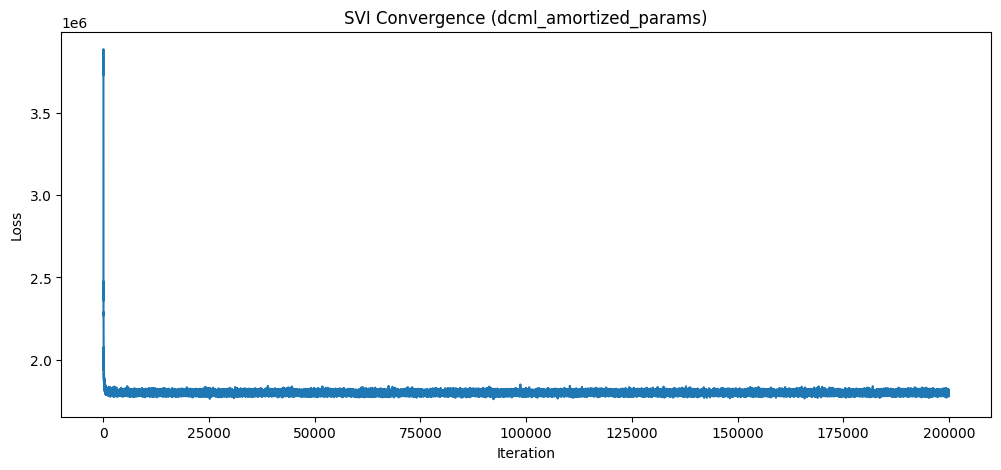

In [27]:
dcml_params, (alpha_h_history, alpha_phi_history) = infer_amortized_posteriors(npcs, len(dcml_chordtypes), dcml_obs,
                                                                              nsteps=200000, lr=0.1, plot_loss=True,
                                                                              save_as="dcml_amortized_params", collect_history=True
                                                                              )

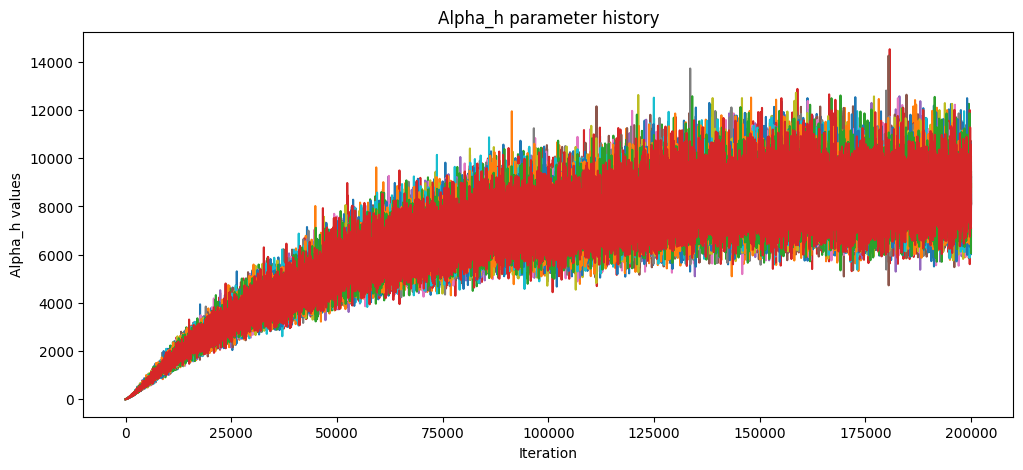

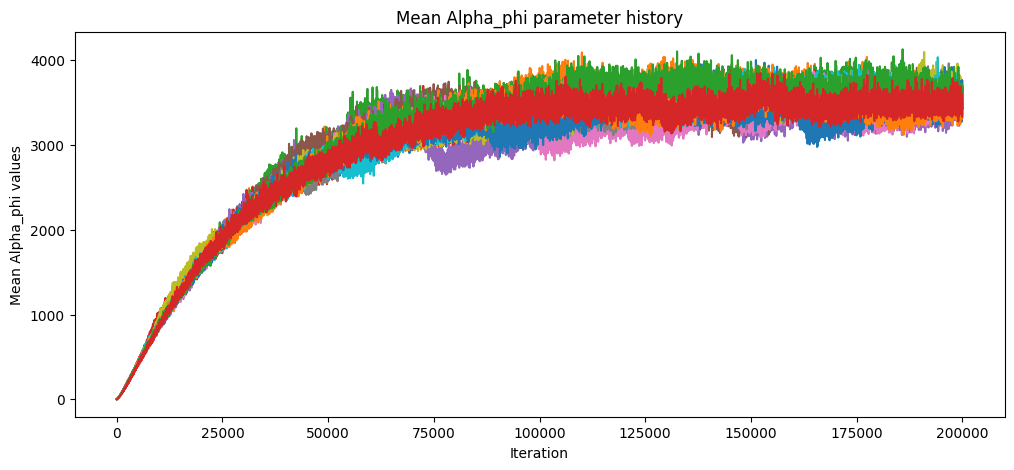

In [28]:
# Plot the parameter histories
plot_param_histories(alpha_h_history, alpha_phi_history)

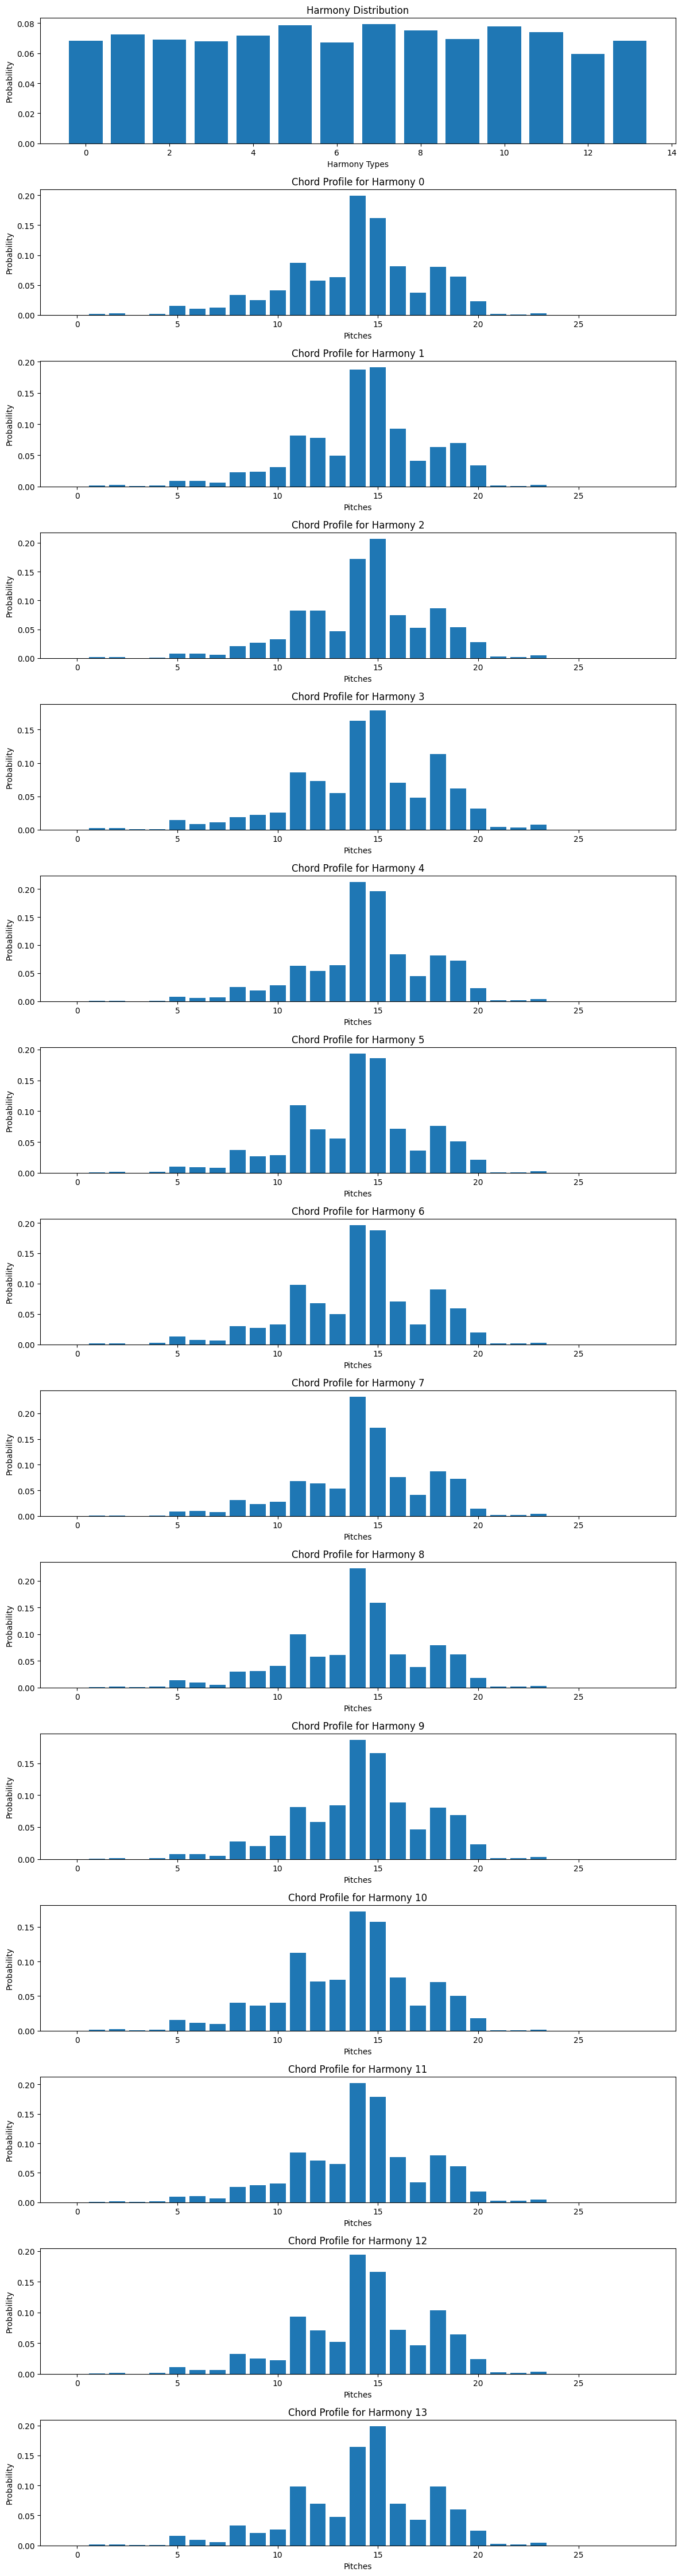

In [29]:
plot_amortized_inference_results(dcml_params, len(dcml_chordtypes), npcs, save_as="dcml_amortized_params")